In [1]:
import os
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import seaborn as sns
from shapely import wkt, LineString, Point
import pandas as pd
import cartopy.crs as ccrs
import contextily as cx
import numpy as np
import pypsa
from tqdm import tqdm

parent_dir = os.path.dirname(os.getcwd())
if not os.path.exists(parent_dir + '/figures'):
    os.makedirs(parent_dir + '/figures')
if not os.path.exists(parent_dir + '/datatables'):
    os.makedirs(parent_dir + '/datatables')

font = {'family' : 'sans-serif',
        'sans-serif' : 'Roboto',
        'size'   : 8}

plt.rc('font', **font)

In [2]:
def find_inliers_outliers(df, col1, col2, interval = 0.95):
    interval_lower = (1-interval)/2
    interval_upper = interval + interval_lower

    # Initialize a set to store outlier indices
    outlier_indices = set()
    inlier_indices = set()

    # Calculate the 2.5th and 97.5th percentiles
    lower_bound = abs(df[col1]-df[col2]).quantile(interval_lower)
    upper_bound = abs(df[col1]-df[col2]).quantile(interval_upper)
    
    # Find indices of values outside the 95% range
    outlier_indices = df[(abs(df[col1]-df[col2]) < lower_bound) | (abs(df[col1]-df[col2]) > upper_bound)].index
    inlier_indices = df[~df.index.isin(outlier_indices)].index

    # Convert the set of outlier indices to a sorted list
    return sorted(inlier_indices), sorted(outlier_indices)

INFO:pypsa.io:Imported network base.nc has buses, carriers, lines, links, shapes, transformers
INFO:pypsa.io:Imported network base.nc has buses, carriers, lines, links, shapes, transformers
INFO:pypsa.io:Imported network base.nc has buses, carriers, lines, links, shapes, transformers
INFO:pypsa.io:Imported network base.nc has buses, carriers, lines, links, shapes, transformers
/home/bobby/miniconda3/envs/pypsa-eur/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

/home/bobby/miniconda3/envs/pypsa-eur/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



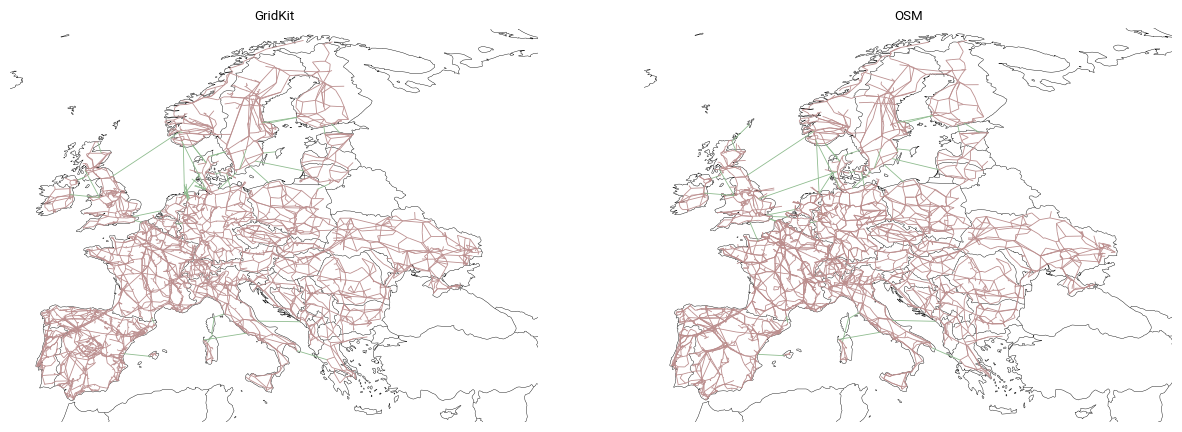

In [4]:
# n_base_gridkit = pypsa.Network("data/osm-for-pypsa-eur/entsoegridkit_nuts2/networks/base.nc")
# n_base_osm = pypsa.Network("data/osm-for-pypsa-eur/osm-prebuilt_nuts2/networks/base.nc")

n_base_gridkit = pypsa.Network("data/validation/entsoegridkit/networks/base.nc")
n_base_osm = pypsa.Network("data/validation/osm-0.5/networks/base.nc")


crs = ccrs.EqualEarth()
fig, ax = plt.subplots(1, 2, figsize=(15, 7), subplot_kw={'projection': crs})
n_base_gridkit.plot(bus_sizes=0, ax=ax[0], title='GridKit', line_widths=0.6, link_widths=0.6)
n_base_osm.plot(bus_sizes=0, ax=ax[1], title='OSM', line_widths=0.6, link_widths=0.6)
plt.show()

In [5]:
# Calculate electric parameters
n_base_gridkit.calculate_dependent_values()
n_base_osm.calculate_dependent_values()

In [6]:
print(f"Route length base gridkit network: {(n_base_gridkit.lines.length.sum() + n_base_gridkit.links.length.sum()) :.0f} km")
print(f"Route length base osm network: {(n_base_osm.lines.length.sum() + n_base_gridkit.links.length.sum()) :.0f} km")

Route length base gridkit network: 250627 km
Route length base osm network: 283392 km


In [73]:
# Keep highest length in grouped
grouped = n_base_osm.lines.groupby(["v_nom", "bus0", "bus1"]).agg({"length": "max"}).reset_index()

In [75]:
grouped.length.sum()

249166.24722000002

## Figures

### osm_map

In [11]:
# Assuming n_base_osm contains the necessary dataframes for lines, shapes, and buses

# Filter country shapes
country_shapes = n_base_osm.shapes[n_base_osm.shapes["type"] == "country"]

# Process buses dataframe
buses_osm = n_base_osm.buses.copy()
buses_osm.geometry = buses_osm.geometry.apply(wkt.loads)
buses_osm = gpd.GeoDataFrame(buses_osm, geometry="geometry", crs="EPSG:4326")

# Process lines dataframe
lines_osm = n_base_osm.lines.copy()
lines_osm.geometry = lines_osm.geometry.apply(wkt.loads)
lines_osm = gpd.GeoDataFrame(lines_osm, geometry="geometry", crs="EPSG:4326")

# Process links dataframe
links_osm = n_base_osm.links.copy()
links_osm.geometry = links_osm.geometry.apply(wkt.loads)
links_osm = gpd.GeoDataFrame(links_osm, geometry="geometry", crs="EPSG:4326")


# Define colormap for links (viridis colormap)
unique_p_nom = sorted(links_osm['p_nom'].unique())
colors_links = cm.cool(np.linspace(0, 1, len(unique_p_nom)))
cmap_links = mcolors.ListedColormap(colors_links)
norm_links = mcolors.BoundaryNorm(boundaries=np.append(unique_p_nom, unique_p_nom[-1] + 1), ncolors=len(unique_p_nom))

In [12]:
print(sorted(lines_osm.v_nom.unique()))

[220.0, 225.0, 236.0, 275.0, 300.0, 330.0, 380.0, 400.0, 420.0, 500.0, 750.0]


In [15]:
# Colors and colormap
ac_labels = ["220 - 236", "275 - 330", "380 - 420", "500 - 750"]
ac_bins = [0, 236, 330, 420, 750]
ac_colors = ['#69b586', '#FFA500', '#b02e2e', '#222222']  #
ac_cmap = mcolors.ListedColormap(ac_colors)
ac_norm = mcolors.BoundaryNorm(boundaries=range(len(ac_labels)+1), ncolors=len(ac_labels))

lines_osm["v_nom_group"] = pd.cut(lines_osm["v_nom"], bins=ac_bins, labels=ac_labels)

In [16]:
lines_osm.loc[lines_osm.v_nom ==500, ["v_nom", "v_nom_group"]]

v_nom v_nom_group
Line                                         
way/136051600-500           500.0   500 - 750
way/1136274724-500          500.0   500 - 750
way/1136276790-500          500.0   500 - 750
merged_way/136051601-500+1  500.0   500 - 750

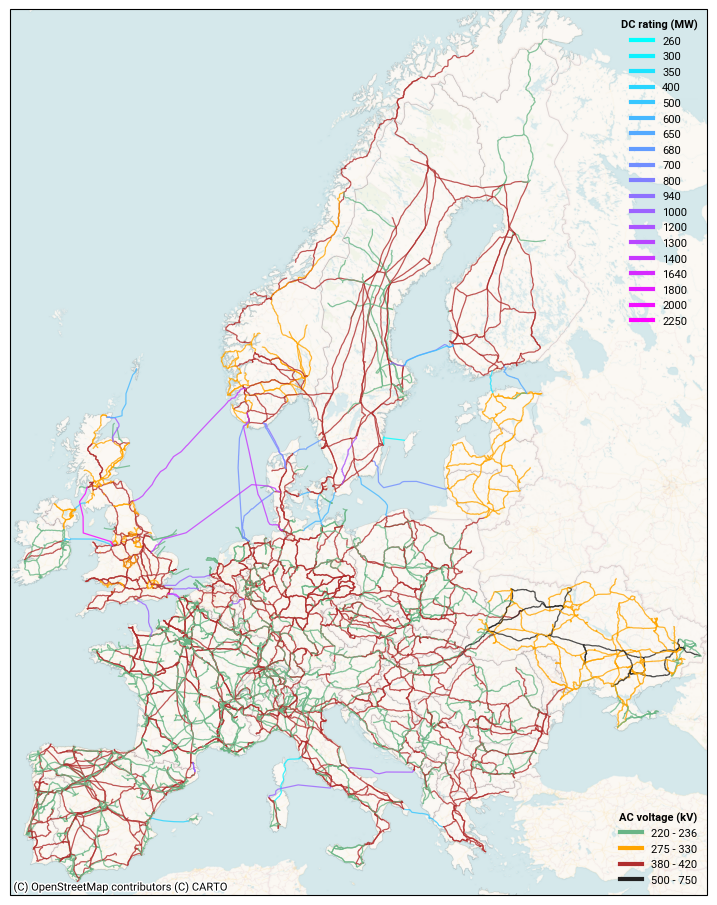

In [17]:
# Settings
crs = ccrs.Mercator()
fontsize=8
title_fontsize=8

# Set up the plot with Equal Earth projection
fig, ax = plt.subplots(1, 1, figsize=(9, 12), subplot_kw={"projection": crs})

# ax.set_facecolor("#efefef")

# Calculate the extent of the country shapes data
minx, miny, maxx, maxy = country_shapes.total_bounds
extent = [minx, maxx, miny+0.3, maxy-2]

# Set limits to zoom into the map based on the extent of country shapes
ax.set_extent(extent)

# Plots
zoomlevel = 6 #8
cx.add_basemap(ax, crs=crs, source=cx.providers.CartoDB.VoyagerNoLabels, zoom = zoomlevel)

country_shapes.to_crs(crs.proj4_init).plot(ax=ax, color="#ffffff", edgecolor="#000000", linewidth=0.5, alpha=0.1)
lines_osm.to_crs(crs.proj4_init).plot(ax=ax, column='v_nom_group', cmap=ac_cmap, linewidth=0.9, alpha=0.8, legend=True)
links_osm.to_crs(crs.proj4_init).plot(ax=ax, column='p_nom', cmap=cmap_links, norm = norm_links, linewidth=0.9, linestyle='-', alpha=0.8)
# buses_osm.to_crs(crs.proj4_init).plot(ax=ax, marker='o', color='black', markersize=1, alpha=0.5)

# Plot AC voltage levels data with legend
ac_legend_elements = [Line2D([0], [0], color=color, lw=3, label=label)
                      for color, label in zip(ac_colors, ac_labels)]
for color, label in zip(ac_colors, ac_labels):
    ax.plot([], [], color=color, label=label)  # This line adds a dummy plot to associate with the label

# Plot DC links data with legend
dc_legend_elements = [Line2D([0], [0], color=color, lw=3, label=label)
                      for color, label in zip(colors_links, [int(x) for x in unique_p_nom])]
for color, label in zip(colors_links, unique_p_nom):
    ax.plot([], [], color=color, label=label)  # This line adds a dummy plot to associate with the label

# Add both legends to the plot
ac_legend = ax.legend(handles=ac_legend_elements, title="AC voltage (kV)", loc='lower right', fontsize=fontsize, title_fontsize=title_fontsize)
dc_legend = ax.legend(handles=dc_legend_elements, title="DC rating (MW)", loc='upper right', fontsize=fontsize, title_fontsize=title_fontsize)

# Set facecolor and edgecolor of the legend frames to none for both legends
ac_legend.get_frame().set_facecolor('none')
ac_legend.get_frame().set_edgecolor('none')
dc_legend.get_frame().set_facecolor('none')
dc_legend.get_frame().set_edgecolor('none')
# Set legend title font weight to bold
ac_legend.get_title().set_fontweight('bold')
dc_legend.get_title().set_fontweight('bold')


# Add the first legend back to the figure
ax.add_artist(ac_legend)

plt.show()
# folder directory ../figures/#

fig.savefig(f"{parent_dir}/figures/fig_osm_map.pdf", format="pdf", bbox_inches="tight", pad_inches=0)


### DC example: Simplification of Moyle Interconnector

In [133]:
gdf_dc_example_before = gpd.read_file("data/example_geojson/dc_example_moyle_before.geojson")
gdf_dc_example_after = gpd.read_file("data/example_geojson/dc_example_moyle_after.geojson")

/tmp/ipykernel_25530/2960209560.py:10: UserWarning:

Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




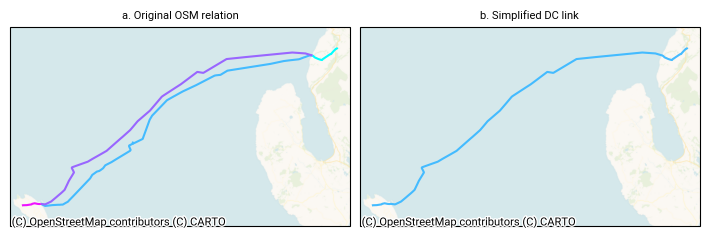

In [134]:
# Settings
crs = ccrs.Mercator()
fontsize = 8
title_fontsize = 8

# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(8.9, 3), subplot_kw={"projection": crs}, gridspec_kw={"wspace": 0.03, "hspace": 0})

# Define the extent of the plots
minx, miny, maxx, maxy = gdf_dc_example_after.buffer(0.03).total_bounds

extent = [minx, maxx, miny, maxy]
ax[0].set_extent(extent, crs=ccrs.PlateCarree())
ax[1].set_extent(extent, crs=ccrs.PlateCarree())

zoomlevel = 12
cx.add_basemap(ax[0], crs=crs, source=cx.providers.CartoDB.VoyagerNoLabels, zoom = zoomlevel)
cx.add_basemap(ax[1], crs=crs, source=cx.providers.CartoDB.VoyagerNoLabels, zoom = zoomlevel)

# Plot the before and after data on the respective axes
for idx, row in gdf_dc_example_before.iterrows():
    gdf_dc_example_before.iloc[[idx]].to_crs(crs.proj4_init).plot(ax=ax[0], color=cmap_links(idx/10*3), linewidth=1.5)

gdf_dc_example_after.to_crs(crs.proj4_init).plot(ax=ax[1], color=cmap_links(norm_links(links_osm.loc["relation/6914309", "p_nom"])), linewidth=1.5)

# Set titles
ax[0].set_title("a. Original OSM relation", fontsize=fontsize)
ax[1].set_title("b. Simplified DC link", fontsize=fontsize)

fig.savefig(f"{parent_dir}/figures/fig_dc_example.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
# Display the plot

plt.show()



### Building steps

In [135]:
gdf_preclean_lines = gpd.read_file("data/example_geojson/clean_osm_data_lines_preclean.geojson")
gdf_afterclean_lines = gpd.read_file("data/example_geojson/clean_osm_data_lines_after_internal_removal.geojson")
gdf_build_osm_lines_before = gpd.read_file("data/example_geojson/build_osm_lines_before.geojson")
gdf_build_osm_lines_after = gpd.read_file("data/example_geojson/build_osm_lines_after.geojson")
gdf_build_osm_links_before = gpd.read_file("data/example_geojson/build_osm_links_before.geojson")
gdf_build_osm_links_after = gpd.read_file("data/example_geojson/build_osm_links_after.geojson")
gdf_build_osm_converters_after = gpd.read_file("data/example_geojson/build_osm_converters_after.geojson")
gdf_build_osm_transformers_after = gpd.read_file("data/example_geojson/build_osm_transformers_after.geojson")
gdf_build_osm_buses_before = gpd.read_file("data/example_geojson/build_osm_buses_before.geojson")
gdf_build_osm_buses_after = gpd.read_file("data/example_geojson/build_osm_buses_after.geojson")
gdf_substations_polygon = gpd.read_file("data/example_geojson/substations_polygon.geojson")

In [136]:
map = gdf_build_osm_lines_before.explore(color = "red")
map = gdf_build_osm_links_before.explore(m = map, color = "blue")
map = gdf_build_osm_buses_before.explore(m = map, color = "green", popup = True)

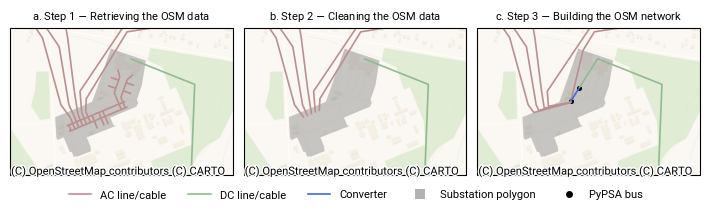

In [137]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import contextily as cx
import cartopy.crs as ccrs

# Settings
crs = ccrs.Mercator()
fontsize = 8
title_fontsize = 8

x = 12.806967
y = 41.428700

# Create a figure with three subplots side by side
fig, [ax0, ax1, ax2] = plt.subplots(1, 3, figsize=(8.9, 4.6), subplot_kw={"projection": crs}, gridspec_kw={"wspace": 0.05, "hspace": 0.05})

# Define the extent of the plots
minx, miny, maxx, maxy = x-2/300, y-1/300, x+2/300, y+1/300
linewidth = 1.2

extent = [minx, maxx, miny, maxy]
ax0.set_extent(extent, crs=ccrs.PlateCarree())
ax1.set_extent(extent, crs=ccrs.PlateCarree())
ax2.set_extent(extent, crs=ccrs.PlateCarree())

zoomlevel = 18
cx.add_basemap(ax0, crs=crs, source=cx.providers.CartoDB.VoyagerNoLabels, zoom=zoomlevel)
cx.add_basemap(ax1, crs=crs, source=cx.providers.CartoDB.VoyagerNoLabels, zoom=zoomlevel)
cx.add_basemap(ax2, crs=crs, source=cx.providers.CartoDB.VoyagerNoLabels, zoom=zoomlevel)

# Plot the data on each axis
gdf_substations_polygon.to_crs(crs.proj4_init).plot(ax=ax0, color='grey', alpha=0.1)
gdf_preclean_lines.to_crs(crs.proj4_init).plot(ax=ax0, linewidth=linewidth, color="rosybrown")
gdf_build_osm_links_before.to_crs(crs.proj4_init).plot(ax=ax0, color='darkseagreen', linewidth=linewidth)

gdf_substations_polygon.to_crs(crs.proj4_init).plot(ax=ax1, color='grey', alpha=0.1)
gdf_afterclean_lines.to_crs(crs.proj4_init).plot(ax=ax1, linewidth=linewidth, color="rosybrown")
gdf_build_osm_links_before.to_crs(crs.proj4_init).plot(ax=ax1, color='darkseagreen', linewidth=linewidth)

gdf_substations_polygon.to_crs(crs.proj4_init).plot(ax=ax2, color='grey', alpha=0.1)
gdf_build_osm_lines_after.to_crs(crs.proj4_init).plot(ax=ax2, linewidth=linewidth, color="rosybrown")
gdf_build_osm_links_after.to_crs(crs.proj4_init).plot(ax=ax2, color='darkseagreen', linewidth=linewidth)
gdf_build_osm_converters_after.to_crs(crs.proj4_init).plot(ax=ax2, color='royalblue', linewidth=linewidth)
gdf_build_osm_buses_after.to_crs(crs.proj4_init).plot(ax=ax2, marker='o', color='black', markersize=7)

# Combine legend elements
legend_elements = [
    Line2D([0], [0], color='rosybrown', lw=linewidth, label='AC line/cable'),
    Line2D([0], [0], color='darkseagreen', lw=linewidth, label='DC line/cable'),
    Line2D([0], [0], color='royalblue', lw=linewidth, label='Converter'),
    Line2D([0], [0], marker='s', color='w', label='Substation polygon', markerfacecolor='grey', markersize=7, alpha=0.6, markeredgewidth=0),
    Line2D([0], [0], marker='o', color="w", label='PyPSA bus', markerfacecolor='black', markersize=5, markeredgewidth=0)
]

# Set titles
ax0.set_title("a. Step 1 $-$ Retrieving the OSM data", fontsize=fontsize)
ax1.set_title("b. Step 2 $-$ Cleaning the OSM data", fontsize=fontsize)
ax2.set_title("c. Step 3 $-$ Building the OSM network", fontsize=fontsize)

# Add combined legend outside the plot
fig.legend(handles=legend_elements, loc='lower left', fontsize=fontsize, ncol=5, bbox_to_anchor=(0.18, 0.26), frameon=False)

# Save and display the plot
fig.savefig(f"{parent_dir}/figures/fig_all_steps.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()


### ENTSO-E stats

In [11]:
url_entsoe_stats = "https://www.entsoe.eu/publications/data/power-stats/2023/inventory_of_transmission_2023.csv"
url_entsoe_stats = "data/inventory_of_transmission_2023.csv"
df_entsoe_stats_raw = pd.read_csv(url_entsoe_stats, sep = ",", encoding='ISO-8859-1')
df_entsoe_stats_raw["Category"].unique()

array(['ACC_220kV_380kV', 'ACC_Over_380kV', 'ACL_110kV_220kV',
       'ACL_220kV', 'ACL_275kV', 'ACL_330kV', 'ACL_380_400kV',
       'ACL_750kV', 'Comments_1', 'Comments_2', 'Comments_3',
       'Comments_4', 'DCC_110kV_220V', 'DCC_220kV_380kV',
       'DCC_Over_380kV', 'Nw_220kV_110kV_lower', 'Nw_275kV_110kV_lower',
       'Nw_330kV_110kV_lower', 'Nw_330kV_220kV', 'Nw_400kV_110kV_lower',
       'Nw_400kV_220kV', 'Nw_400kV_330kV', 'Nw_750kV_400kV_lower',
       'Of_PU_>220kV', 'Of_PU_>275kV', 'Of_PU_>330kV', 'Of_PU_>400kV'],
      dtype=object)

In [12]:
# Relevant categories:
list_category = ["ACC_220kV_380kV", "ACC_Over_380kV", "ACL_220kV", "ACL_275kV", "ACL_330kV", "ACL_380_400kV", "ACL_750kV"]
df_entsoe_stats = df_entsoe_stats_raw.copy()
df_entsoe_stats = df_entsoe_stats[df_entsoe_stats["Category"].isin(list_category)]
df_entsoe_stats.head()
df_entsoe_stats_grouped = df_entsoe_stats.groupby("Country") \
    .agg({"LengthOfRoutes": "sum", "LengthOfCircuits": "sum"})
df_entsoe_stats_grouped.rename(columns = {"LengthOfRoutes": "length_routes_stats", "LengthOfCircuits": "length_circuits_stats"}, inplace = True)
df_entsoe_stats_grouped.index.name = "country"
df_entsoe_stats_grouped.head()

length_routes_stats  length_circuits_stats
country                                            
AL                    1695.0                1695.00
AT                    3342.0                6768.00
BA                       0.0                2386.02
BE                    1322.0                2265.00
BG                    5905.0                5905.00

In [13]:
def get_lines_by_country(network):
    if "country" in network.lines.columns:
        network.lines.drop(columns = "country", inplace = True)
    lines = network.lines.copy().merge(network.buses.country, left_on = "bus0", right_index = True)
    lines = lines.merge(network.buses.country, left_on = "bus1", right_index = True, suffixes = ("0", "1"))

    # New code here
    lines = lines.groupby(["bus0", "bus1", "v_nom", "country0", "country1"]).agg({"length": "max", "num_parallel": "sum"}).reset_index()
    # end
    
    # Only keep the lines within the same country
    lines = lines[lines["country0"] == lines["country1"]]
    
    # Calculate circuit length
    lines["length_routes"] = lines["length"]
    lines["length_circuits"] = lines["num_parallel"] * lines["length"]

    # Group by and sum the length of the lines
    lines_grouped = lines.groupby("country0") \
        .agg({"length_routes": "sum", "length_circuits": "sum"})
    
    # Rename index to "country"
    lines_grouped.index.name = "country"
    
    return lines_grouped

In [14]:
lines_base_gridkit = get_lines_by_country(n_base_gridkit)
lines_base_osm = get_lines_by_country(n_base_osm)
lines_base = df_entsoe_stats_grouped.merge(lines_base_gridkit, on = "country", how = "outer")
lines_base = lines_base.merge(lines_base_osm, on = "country", how = "outer", suffixes = ("_gridkit", "_osm"))
countries_before = lines_base.index.to_numpy()

In [15]:
# drop where length_circuits_stats == 0
countries_after = lines_base.index.to_numpy()
countries_config = ['AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'ME', 'MK', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'UA', 'MD']
lines_base = lines_base.loc[countries_config]
lines_base

length_routes_stats  length_circuits_stats  length_routes_gridkit  \
country                                                                      
AL                1695.00000             1695.00000            1115.355063   
AT                3342.00000             6768.00000            2823.123721   
BA                   0.00000             2386.02000            1611.848414   
BE                1322.00000             2265.00000            1206.390740   
BG                5905.00000             5905.00000            3407.117474   
CH                   0.00000             6835.00000            3374.141377   
CZ                4338.00000             5558.00000            4128.550723   
DE               18023.89000            34641.37500           17000.606057   
DK                1536.25900             2241.06010            1448.659468   
EE                1608.00000             1608.00000            1486.238092   
ES               28638.05000            41646.22800           34929.045852   
FI                6333.00000             6803.00000            6349.779503   
FR               35258.89300            49530.74900           31807.792720   
GB                   0.00000            21520.00000           11560.101095   
GR                4488.55770             6329.21590            2319.595823   
HR                2147.82000             2514.73000            1364.003126   
HU                3689.00000             4683.00000            2983.247908   
IE                2324.32000             2519.14000            2108.308875   
IT               19184.00000            22454.00000           15538.547125   
LT                1780.65000             1999.00000            2007.979367   
LU                 165.00000              314.00000             153.241163   
LV                1754.15000             1742.15000            1109.020255   
ME                 728.00000                0.00000             502.509512   
MK                 577.00000                0.00000             401.388572   
NL                2213.25417             3809.48519            1401.651998   
NO                9101.30000             9391.61000            8259.622388   
PL               13982.00000            15688.00000           11161.805175   
PT                5560.00000             6928.60000            5676.241529   
RO                8971.80000            10173.20000            7633.555378   
RS                3417.52200             3564.61020            2600.631484   
SE               10823.00000            11151.00000           13536.324787   
SI                 875.90000             1156.10000             585.064171   
SK                2413.33700             3045.06100            1950.844281   
UA                       NaN                    NaN           19774.898695   
MD                       NaN                    NaN             375.579543   

         length_circuits_gridkit  length_routes_osm  length_circuits_osm  
country                                                                   
AL                   1571.152717         1080.09273           1522.85866  
AT                   5664.136749         3068.99001           5933.61072  
BA                   1809.941833         1984.15835           2054.74378  
BE                   2196.056674         1271.69973           2002.49633  
BG                   4576.704184         3810.93324           4959.43810  
CH                   6313.396512         4199.34421           6177.65229  
CZ                   5163.741217         4230.82807           4931.50506  
DE                  36446.929297        21770.80613          34391.34859  
DK                   1859.971340         1609.15215           1867.91325  
EE                   1518.833713         1219.43191           1249.47331  
ES                  50345.889932        29686.84286          41786.68416  
FI                   6690.944094         5787.38219           6253.94522  
FR                  45214.699315        37077.08714          49122.61724

In [16]:
# Manual additions of missing data
lines_base.loc["UA", "length_circuits_stats"] = 23690 # Source: 2022, https://www.power-technology.com/data-insights/top-five-transmission-line-projects-in-the-ukraine/?cf-view
lines_base.loc["UA", "length_routes_stats"] = 21300 # Source: 2018, CIGRE presentation: https://www.cigre.org/userfiles/files/Community/NC/2018_National-power-system_Ukraine.pdf

lines_base.loc["MD", "length_circuits_stats"] = 377.34+203 # Source: 2023, Moldelectrica: https://moldelectrica-md.translate.goog/ro/network/annual_report?_x_tr_sl=auto&_x_tr_tl=en&_x_tr_hl=de&_x_tr_pto=wapp

In [17]:
lines_base

length_routes_stats  length_circuits_stats  length_routes_gridkit  \
country                                                                      
AL                1695.00000             1695.00000            1115.355063   
AT                3342.00000             6768.00000            2823.123721   
BA                   0.00000             2386.02000            1611.848414   
BE                1322.00000             2265.00000            1206.390740   
BG                5905.00000             5905.00000            3407.117474   
CH                   0.00000             6835.00000            3374.141377   
CZ                4338.00000             5558.00000            4128.550723   
DE               18023.89000            34641.37500           17000.606057   
DK                1536.25900             2241.06010            1448.659468   
EE                1608.00000             1608.00000            1486.238092   
ES               28638.05000            41646.22800           34929.045852   
FI                6333.00000             6803.00000            6349.779503   
FR               35258.89300            49530.74900           31807.792720   
GB                   0.00000            21520.00000           11560.101095   
GR                4488.55770             6329.21590            2319.595823   
HR                2147.82000             2514.73000            1364.003126   
HU                3689.00000             4683.00000            2983.247908   
IE                2324.32000             2519.14000            2108.308875   
IT               19184.00000            22454.00000           15538.547125   
LT                1780.65000             1999.00000            2007.979367   
LU                 165.00000              314.00000             153.241163   
LV                1754.15000             1742.15000            1109.020255   
ME                 728.00000                0.00000             502.509512   
MK                 577.00000                0.00000             401.388572   
NL                2213.25417             3809.48519            1401.651998   
NO                9101.30000             9391.61000            8259.622388   
PL               13982.00000            15688.00000           11161.805175   
PT                5560.00000             6928.60000            5676.241529   
RO                8971.80000            10173.20000            7633.555378   
RS                3417.52200             3564.61020            2600.631484   
SE               10823.00000            11151.00000           13536.324787   
SI                 875.90000             1156.10000             585.064171   
SK                2413.33700             3045.06100            1950.844281   
UA               21300.00000            23690.00000           19774.898695   
MD                       NaN              580.34000             375.579543   

         length_circuits_gridkit  length_routes_osm  length_circuits_osm  
country                                                                   
AL                   1571.152717         1080.09273           1522.85866  
AT                   5664.136749         3068.99001           5933.61072  
BA                   1809.941833         1984.15835           2054.74378  
BE                   2196.056674         1271.69973           2002.49633  
BG                   4576.704184         3810.93324           4959.43810  
CH                   6313.396512         4199.34421           6177.65229  
CZ                   5163.741217         4230.82807           4931.50506  
DE                  36446.929297        21770.80613          34391.34859  
DK                   1859.971340         1609.15215           1867.91325  
EE                   1518.833713         1219.43191           1249.47331  
ES                  50345.889932        29686.84286          41786.68416  
FI                   6690.944094         5787.38219           6253.94522  
FR                  45214.699315        37077.08714          49122.61724

#### scatter_length_circuits

In [18]:
lines_base

length_routes_stats  length_circuits_stats  length_routes_gridkit  \
country                                                                      
AL                1695.00000             1695.00000            1115.355063   
AT                3342.00000             6768.00000            2823.123721   
BA                   0.00000             2386.02000            1611.848414   
BE                1322.00000             2265.00000            1206.390740   
BG                5905.00000             5905.00000            3407.117474   
CH                   0.00000             6835.00000            3374.141377   
CZ                4338.00000             5558.00000            4128.550723   
DE               18023.89000            34641.37500           17000.606057   
DK                1536.25900             2241.06010            1448.659468   
EE                1608.00000             1608.00000            1486.238092   
ES               28638.05000            41646.22800           34929.045852   
FI                6333.00000             6803.00000            6349.779503   
FR               35258.89300            49530.74900           31807.792720   
GB                   0.00000            21520.00000           11560.101095   
GR                4488.55770             6329.21590            2319.595823   
HR                2147.82000             2514.73000            1364.003126   
HU                3689.00000             4683.00000            2983.247908   
IE                2324.32000             2519.14000            2108.308875   
IT               19184.00000            22454.00000           15538.547125   
LT                1780.65000             1999.00000            2007.979367   
LU                 165.00000              314.00000             153.241163   
LV                1754.15000             1742.15000            1109.020255   
ME                 728.00000                0.00000             502.509512   
MK                 577.00000                0.00000             401.388572   
NL                2213.25417             3809.48519            1401.651998   
NO                9101.30000             9391.61000            8259.622388   
PL               13982.00000            15688.00000           11161.805175   
PT                5560.00000             6928.60000            5676.241529   
RO                8971.80000            10173.20000            7633.555378   
RS                3417.52200             3564.61020            2600.631484   
SE               10823.00000            11151.00000           13536.324787   
SI                 875.90000             1156.10000             585.064171   
SK                2413.33700             3045.06100            1950.844281   
UA               21300.00000            23690.00000           19774.898695   
MD                       NaN              580.34000             375.579543   

         length_circuits_gridkit  length_routes_osm  length_circuits_osm  
country                                                                   
AL                   1571.152717         1080.09273           1522.85866  
AT                   5664.136749         3068.99001           5933.61072  
BA                   1809.941833         1984.15835           2054.74378  
BE                   2196.056674         1271.69973           2002.49633  
BG                   4576.704184         3810.93324           4959.43810  
CH                   6313.396512         4199.34421           6177.65229  
CZ                   5163.741217         4230.82807           4931.50506  
DE                  36446.929297        21770.80613          34391.34859  
DK                   1859.971340         1609.15215           1867.91325  
EE                   1518.833713         1219.43191           1249.47331  
ES                  50345.889932        29686.84286          41786.68416  
FI                   6690.944094         5787.38219           6253.94522  
FR                  45214.699315        37077.08714          49122.61724

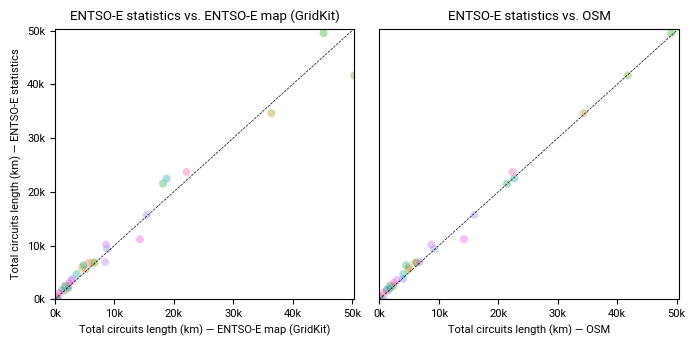

In [19]:
# Function to format thousands with 'k' suffix
def thousands_formatter(x, pos):
    return '{:.0f}k'.format(x * 1e-3)

fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
sns.scatterplot(data=lines_base, x="length_circuits_gridkit", y="length_circuits_stats", ax=ax[0], alpha=0.4, hue="country")
sns.scatterplot(data=lines_base, x="length_circuits_osm", y="length_circuits_stats", ax=ax[1], alpha=0.4, hue="country")

# remove legend
ax[0].legend().remove()
ax[1].legend().remove()

# Add 1:1 line
x_min = 0
x_max = max(lines_base["length_circuits_stats"].max(), lines_base["length_circuits_gridkit"].max())
y_min = 0
y_max = max(lines_base["length_circuits_stats"].max(), lines_base["length_circuits_gridkit"].max())
ax[0].plot([x_min, x_max], [y_min, y_max], color="black", linewidth=0.5, linestyle="--")
ax[0].set_title("ENTSO-E statistics vs. ENTSO-E map (GridKit)")
ax[0].set_xlabel("Total circuits length (km) — ENTSO-E map (GridKit)")
ax[0].set_ylabel("Total circuits length (km) — ENTSO-E statistics")
ax[1].plot([x_min, x_max], [y_min, y_max], color="black", linewidth=0.5, linestyle="--")
ax[1].set_title("ENTSO-E statistics vs. OSM")
ax[1].set_xlabel("Total circuits length (km) — OSM")

# Share common y axis
ax[1].set_yticks([])
ax[1].set_ylabel("")

# Format y-axis labels with 'k' suffix
ax[0].xaxis.set_major_formatter(mtick.FuncFormatter(thousands_formatter))
ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(thousands_formatter))
ax[1].xaxis.set_major_formatter(mtick.FuncFormatter(thousands_formatter))
ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(thousands_formatter))

# Set the same x and y limits for both subfigures
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylim(y_min, y_max)

plt.tight_layout()
fig.savefig(f"{parent_dir}/figures/fig_scatter_length_circuits.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()


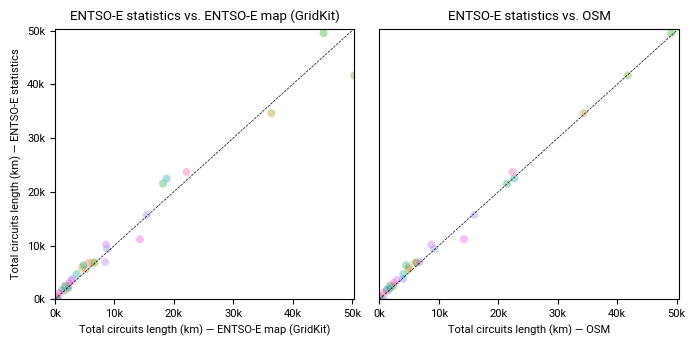

In [20]:
# Function to format thousands with 'k' suffix
def thousands_formatter(x, pos):
    return '{:.0f}k'.format(x * 1e-3)

fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
sns.scatterplot(data=lines_base, x="length_circuits_gridkit", y="length_circuits_stats", ax=ax[0], alpha=0.4, hue="country")
sns.scatterplot(data=lines_base, x="length_circuits_osm", y="length_circuits_stats", ax=ax[1], alpha=0.4, hue="country")

# remove legend
ax[0].legend().remove()
ax[1].legend().remove()

# Add 1:1 line
x_min = 0
x_max = max(lines_base["length_circuits_stats"].max(), lines_base["length_circuits_gridkit"].max())
y_min = 0
y_max = max(lines_base["length_circuits_stats"].max(), lines_base["length_circuits_gridkit"].max())
ax[0].plot([x_min, x_max], [y_min, y_max], color="black", linewidth=0.5, linestyle="--")
ax[0].set_title("ENTSO-E statistics vs. ENTSO-E map (GridKit)")
ax[0].set_xlabel("Total circuits length (km) — ENTSO-E map (GridKit)")
ax[0].set_ylabel("Total circuits length (km) — ENTSO-E statistics")
ax[1].plot([x_min, x_max], [y_min, y_max], color="black", linewidth=0.5, linestyle="--")
ax[1].set_title("ENTSO-E statistics vs. OSM")
ax[1].set_xlabel("Total circuits length (km) — OSM")

# Share common y axis
ax[1].set_yticks([])
ax[1].set_ylabel("")

# Format y-axis labels with 'k' suffix
ax[0].xaxis.set_major_formatter(mtick.FuncFormatter(thousands_formatter))
ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(thousands_formatter))
ax[1].xaxis.set_major_formatter(mtick.FuncFormatter(thousands_formatter))
ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(thousands_formatter))

# Set the same x and y limits for both subfigures
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylim(y_min, y_max)

plt.tight_layout()
fig.savefig(f"{parent_dir}/figures/fig_scatter_length_circuits.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()


#### bar_length_circuits

In [21]:
# Melt the data for Seaborn's barplot
lines_circuits_long = lines_base.reset_index() \
    .melt(
        id_vars=["country"], 
        value_vars=["length_circuits_osm", "length_circuits_gridkit", "length_circuits_stats",],
        var_name="parameter", value_name="length"
        ) \
    .set_index("country")

lines_circuits_long["parameter"] = lines_circuits_long["parameter"].map({
    "length_circuits_osm": "OSM",
    "length_circuits_gridkit": "ENTSO-E map",
    "length_circuits_stats": "Reference (ENTSO-E inventory)",
})


In [22]:
# Melt the data for Seaborn's barplot
lines_routes_long = lines_base.reset_index() \
    .melt(
        id_vars=["country"], 
        value_vars=["length_routes_osm", "length_routes_gridkit", "length_routes_stats",],
        var_name="parameter", value_name="length"
        ) \
    .set_index("country")

lines_routes_long["parameter"] = lines_routes_long["parameter"].map({
    "length_routes_osm": "OSM",
    "length_routes_gridkit": "ENTSO-E map",
    "length_routes_stats": "Reference (ENTSO-E inventory)",
})

In [23]:
# fillna in column length_circuits_stats
lines_circuits_long.loc[:, "length"] = lines_circuits_long.length.fillna(0)
lines_routes_long.loc[:, "length"] = lines_routes_long.length.fillna(0)

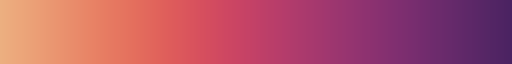

In [24]:
sns.color_palette("flare", as_cmap=True)

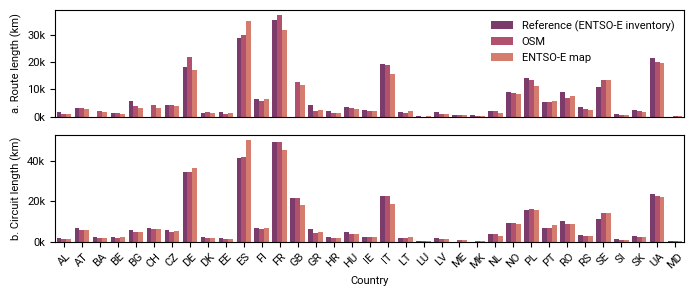

In [25]:
hue_order = ["Reference (ENTSO-E inventory)", "OSM", "ENTSO-E map"]

color_palette = sns.color_palette("flare", n_colors=3)[::-1]

fontsize = 8

# Plot
fig, ax = plt.subplots(2, 1, figsize=(7, 3))

# Bar plots
sns.color_palette("flare")
sns.barplot(data=lines_routes_long, x="country", y="length", hue="parameter", ax=ax[0], hue_order=hue_order, palette=color_palette)
sns.barplot(data=lines_circuits_long, x="country", y="length", hue="parameter", ax=ax[1], hue_order=hue_order, palette=color_palette)

ax[0].legend(title='', loc='upper right', fontsize=fontsize)
# background color of legend red
ax[0].get_legend().get_frame().set_facecolor('None')
ax[0].get_legend().get_frame().set_linewidth(0.0)
# common x axis for ax[0] and ax[1]
ax[0].set_xticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("a. Route length (km)")
ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(thousands_formatter))

ax[1].set_xlabel("Country")
ax[1].set_ylabel("b. Circuit length (km)")
ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(thousands_formatter))
ax[1].legend().remove()

for i in range(2):
    ax[i].title.set_fontsize(fontsize)

plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
fig.savefig(f"{parent_dir}/figures/fig_bar_lengths.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()


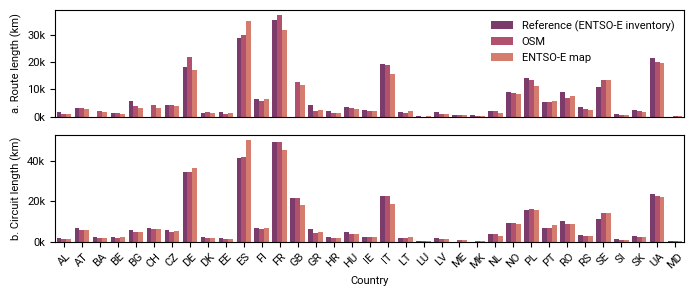

In [26]:
hue_order = ["Reference (ENTSO-E inventory)", "OSM", "ENTSO-E map"]

color_palette = sns.color_palette("flare", n_colors=3)[::-1]

fontsize = 8

# Plot
fig, ax = plt.subplots(2, 1, figsize=(7, 3))

# Bar plots
sns.color_palette("flare")
sns.barplot(data=lines_routes_long, x="country", y="length", hue="parameter", ax=ax[0], hue_order=hue_order, palette=color_palette)
sns.barplot(data=lines_circuits_long, x="country", y="length", hue="parameter", ax=ax[1], hue_order=hue_order, palette=color_palette)

ax[0].legend(title='', loc='upper right', fontsize=fontsize)
# background color of legend red
ax[0].get_legend().get_frame().set_facecolor('None')
ax[0].get_legend().get_frame().set_linewidth(0.0)
# common x axis for ax[0] and ax[1]
ax[0].set_xticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("a. Route length (km)")
ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(thousands_formatter))

ax[1].set_xlabel("Country")
ax[1].set_ylabel("b. Circuit length (km)")
ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(thousands_formatter))
ax[1].legend().remove()

for i in range(2):
    ax[i].title.set_fontsize(fontsize)

plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
fig.savefig(f"{parent_dir}/figures/fig_bar_lengths.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()


#### scatter_line_volumes

In [27]:
# Define function that returns gdf_metrics using the input gdf_regions and 
# gdf_lines
def getMetrics(gdf_regions, gdf_lines):
    print("Obtain list of regions that contain lines.")

    # Obtain a sorted list of region codes that intersect with the lines
    regions_intersect = sorted(
          gpd.overlay(gdf_lines.reset_index(), gdf_regions.reset_index(), how = "intersection")["region_code"] \
            .unique()
          )
    print("Done.\n")
    
    print("Start processing of regions:")
    gdf_metrics = gpd.GeoDataFrame(
        columns=["region_code", "Line", "geometry", "s_nom", "v_nom", "length"], 
        geometry="geometry"
        ) \
          .set_index(["region_code", "Line"])
    
    # for idx_region, region in gdf_regions.iterrows():
    for idx_region in tqdm(regions_intersect, position=0, leave=True):
        gdf_lines_region = gpd.overlay(
            gdf_lines.reset_index(), 
            gdf_regions.loc[[idx_region]].reset_index(), 
            how = "intersection"
            ) \
              .set_index(["region_code", "Line"])

        gdf_metrics = pd.concat([
            gdf_metrics, 
            gdf_lines_region[["geometry", "s_nom", "v_nom", "length"]]
            ])
        # print("Region", idx_region, "processed.")
    print("Processing finished.\n")

    print("Calculate line volumes...")
    gdf_metrics["line_volume"] = gdf_metrics["length"] * gdf_metrics["s_nom"]
    print("Complete.")
    
    # Return new GeoDataFrame containing the metrics
    return gdf_metrics

In [28]:
# Define function to create lines using the start bus and end bus coordinates.
# This method yields point-to-point straight lines, returned as list of 
# shapely.geometry.linestring.LineString

def lineGeometry(network):
    geometry = [LineString(
        [(network.buses.loc[row.bus0]["x"], network.buses.loc[row.bus0]["y"]), 
         (network.buses.loc[row.bus1]["x"], network.buses.loc[row.bus1]["y"])]
         ) \
            for idx, row in network.lines.iterrows()]
    return geometry

def linkGeometry(network):
    geometry = [LineString(
        [(network.buses.loc[row.bus0]["x"], network.buses.loc[row.bus0]["y"]), 
         (network.buses.loc[row.bus1]["x"], network.buses.loc[row.bus1]["y"])]
         ) \
            for idx, row in network.links.iterrows()]
    return geometry

In [29]:
def getLineVolume(n_base_gridkit, n_base_osm, nuts):
    url_nuts2 = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_01M_2021_4326_LEVL_2.geojson"
    url_nuts1 = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_01M_2021_4326_LEVL_1.geojson"
    url_nuts0 = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_01M_2021_4326_LEVL_0.geojson"
    url_nuts2 = "geojson/NUTS_RG_01M_2021_4326_LEVL_2.geojson"
    url_nuts1 = "geojson/NUTS_RG_01M_2021_4326_LEVL_1.geojson"
    url_nuts0 = "geojson/NUTS_RG_01M_2021_4326_LEVL_0.geojson"

    if nuts == "NUTS0":
        output_path = f"{parent_dir}/figures/nuts0"
        gdf_nuts = gpd.read_file(url_nuts0) \
            .drop(columns=["NUTS_ID", "LEVL_CODE", "NUTS_NAME", "MOUNT_TYPE", "URBN_TYPE", "COAST_TYPE", "FID"])
        
        adm = "ADM0"

        url_ba = "https://github.com/wmgeolab/geoBoundaries/raw/905b0ba/" \
        "releaseData/gbOpen/BIH/ADM0/geoBoundaries-BIH-ADM0.geojson"
        url_ba = "geojson/geoBoundaries-BIH-ADM0.geojson"

        url_ua = "https://github.com/wmgeolab/geoBoundaries/raw/905b0ba/" \
        "releaseData/gbOpen/UKR/ADM0/geoBoundaries-UKR-ADM0.geojson"
        url_ua = "geojson/geoBoundaries-UKR-ADM0.geojson"

    elif nuts == "NUTS1":
        output_path = f"{parent_dir}/figures/nuts1"
        gdf_nuts = gpd.read_file(url_nuts1) \
            .drop(columns=["NUTS_ID", "LEVL_CODE", "NUTS_NAME", "MOUNT_TYPE", "URBN_TYPE", "COAST_TYPE", "FID"])

        adm = "ADM1"

        url_ba = "https://github.com/wmgeolab/geoBoundaries/raw/905b0ba/" \
        "releaseData/gbOpen/BIH/ADM1/geoBoundaries-BIH-ADM1.geojson"
        url_ba = "geojson/geoBoundaries-BIH-ADM1.geojson"

        url_ua = "https://github.com/wmgeolab/geoBoundaries/raw/905b0ba/" \
        "releaseData/gbOpen/UKR/ADM1/geoBoundaries-UKR-ADM1.geojson"
        url_ua = "geojson/geoBoundaries-UKR-ADM1.geojson"
        
    elif nuts == "NUTS2":
        output_path = f"{parent_dir}/figures/nuts2"
        gdf_nuts = gpd.read_file(url_nuts2) \
            .drop(columns=["NUTS_ID", "LEVL_CODE", "NUTS_NAME", "MOUNT_TYPE", "URBN_TYPE", "COAST_TYPE", "FID"])
        
        # Keep ADM level at ADM1
        adm = "ADM2"

        url_ba = "https://github.com/wmgeolab/geoBoundaries/raw/905b0ba/" \
        "releaseData/gbOpen/BIH/ADM2/geoBoundaries-BIH-ADM2.geojson"
        url_ba = "geojson/geoBoundaries-BIH-ADM2.geojson"

        url_ua = "https://github.com/wmgeolab/geoBoundaries/raw/905b0ba/" \
        "releaseData/gbOpen/UKR/ADM2/geoBoundaries-UKR-ADM2.geojson"
        url_ua = "geojson/geoBoundaries-UKR-ADM2.geojson"
        
    else:
        print("Invalid NUTS resolution. Please choose either 'NUTS1, 'NUTS2', or 'NUTS3'.")

    if not os.path.exists(output_path):
            os.makedirs(output_path)

    gdf_nuts.columns

    # Rename columns
    gdf_nuts["type"] = nuts
    gdf_nuts.rename(columns = {"CNTR_CODE": "country_code", "id": "region_code", "NAME_LATN": "name"}, inplace = True)
    gdf_nuts.reindex(columns = ["region_code", "name", "country_code", "type", "geometry"])
    gdf_nuts.columns

    # Rename Eurostat country code for "EL" to "GR"
    gdf_nuts["country_code"] = gdf_nuts["country_code"].replace("EL", "GR")

    # Rename region_code prefix "EL" to "GR" for consistency with updated country code for Greece
    gdf_nuts["region_code"] = gdf_nuts["region_code"].str.replace("EL", "GR")
    gdf_nuts.columns

    # BA
    gdf_ba = gpd.read_file(url_ba).drop(columns=["shapeGroup", "shapeType"])
    gdf_ba.rename(columns = {"shapeName": "name", "shapeISO": "region_code"}, inplace = True)
    gdf_ba["region_code"] = gdf_ba["region_code"].str.replace("-", "")
    gdf_ba["country_code"], gdf_ba["type"] = ["BA", adm]
    if nuts == "NUTS2": gdf_ba["region_code"] = gdf_ba["country_code"] + gdf_ba["shapeID"]
    gdf_ba = gdf_ba.reindex(columns = ["region_code", "name", "country_code", "type", "geometry"])
    gdf_ba.columns

    # UA
    gdf_ua = gpd.read_file(url_ua).drop(columns=["shapeGroup", "shapeType"])
    gdf_ua.rename(columns = {"shapeName": "name", "shapeISO": "region_code"}, inplace = True)
    gdf_ua["region_code"] = gdf_ua["region_code"].str.replace("-", "")
    gdf_ua["country_code"], gdf_ua["type"] = ["UA", adm]
    if nuts == "NUTS2": gdf_ua["region_code"] = gdf_ua["country_code"] + gdf_ua["shapeID"]
    gdf_ua = gdf_ua.reindex(columns = ["region_code", "name", "country_code", "type", "geometry"])
    gdf_ua.columns

    gdf_regions = pd.concat([gdf_nuts, gdf_ba, gdf_ua])
    gdf_regions = gdf_regions[(gdf_regions["country_code"] != "IS") & (gdf_regions["country_code"] != "TR")]

    # Set index of gdf_regions to region_code
    gdf_regions.set_index("region_code", inplace = True)

    gdf_lines_gridkit = gpd.GeoDataFrame(n_base_gridkit.lines, geometry = lineGeometry(n_base_gridkit), crs = "EPSG:4326")
    gdf_lines_osm = gpd.GeoDataFrame(n_base_osm.lines, geometry = lineGeometry(n_base_osm), crs = "EPSG:4326")

    metrics_lines_gridkit = getMetrics(gdf_regions, gdf_lines_gridkit)
    metrics_lines_osm = getMetrics(gdf_regions, gdf_lines_osm)

    # Group metrics by region_code:
    metrics_lines_gridkit_grouped = metrics_lines_gridkit.groupby(["region_code"]) \
        .agg({"length": "sum", "line_volume": "sum"})

    metrics_lines_osm_grouped = metrics_lines_osm.groupby(["region_code"]) \
        .agg({"length": "sum", "line_volume": "sum"})

    metrics_lines_grouped = metrics_lines_gridkit_grouped.merge(metrics_lines_osm_grouped, on = "region_code", how = "inner", suffixes = ("_gridkit", "_osm"))
    metrics_lines_grouped["country"] = metrics_lines_grouped.index.str[:2]


    return gdf_regions, metrics_lines_gridkit, metrics_lines_osm, metrics_lines_grouped 

In [30]:
gdf_regions_nuts1, metrics_lines_gridkit_nuts1, metrics_lines_osm_nuts1, metrics_lines_grouped_nuts1 = getLineVolume(n_base_gridkit, n_base_osm, "NUTS1")

Obtain list of regions that contain lines.
Done.

Start processing of regions:


  0%|          | 0/131 [00:00<?, ?it/s]/tmp/ipykernel_54166/4130048508.py:29: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

100%|██████████| 131/131 [00:05<00:00, 23.71it/s]


Processing finished.

Calculate line volumes...
Complete.
Obtain list of regions that contain lines.
Done.

Start processing of regions:


  0%|          | 0/132 [00:00<?, ?it/s]/tmp/ipykernel_54166/4130048508.py:29: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

100%|██████████| 132/132 [00:07<00:00, 18.65it/s]

Processing finished.

Calculate line volumes...
Complete.


In [31]:
gdf_regions_nuts2, metrics_lines_gridkit_nuts2, metrics_lines_osm_nuts2, metrics_lines_grouped_nuts2 = getLineVolume(n_base_gridkit, n_base_osm, "NUTS2")

Obtain list of regions that contain lines.
Done.

Start processing of regions:


  0%|          | 0/494 [00:00<?, ?it/s]/tmp/ipykernel_54166/4130048508.py:29: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

100%|██████████| 494/494 [00:07<00:00, 63.55it/s]


Processing finished.

Calculate line volumes...
Complete.
Obtain list of regions that contain lines.
Done.

Start processing of regions:


  0%|          | 0/492 [00:00<?, ?it/s]/tmp/ipykernel_54166/4130048508.py:29: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

100%|██████████| 492/492 [00:08<00:00, 58.32it/s]

Processing finished.

Calculate line volumes...
Complete.


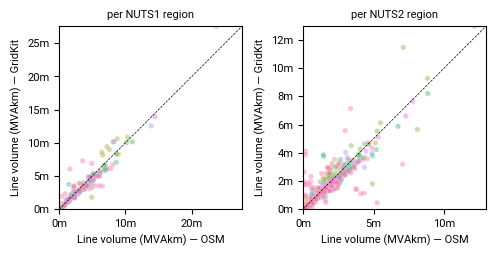

In [33]:
def millions_formatter(x, pos):
    return '{:.0f}m'.format(x * 1e-6)

fontsize = 8
# change font size of titles

fig, ax = plt.subplots(1, 2, figsize=(5, 2.7))
sns.scatterplot(data = metrics_lines_grouped_nuts1, x="line_volume_osm", y="line_volume_gridkit", ax=ax[0], alpha=0.4, hue="country", s=15)
sns.scatterplot(data = metrics_lines_grouped_nuts2, x="line_volume_osm", y="line_volume_gridkit", ax=ax[1], alpha=0.4, hue="country", s=15)

# remove legend
ax[0].legend().remove()
ax[1].legend().remove()


# Add 1:1 line
x_min = 0
x_max = max(metrics_lines_grouped_nuts1["line_volume_gridkit"].max(), metrics_lines_grouped_nuts1["line_volume_osm"].max())
y_min = 0
y_max = max(metrics_lines_grouped_nuts1["line_volume_gridkit"].max(), metrics_lines_grouped_nuts1["line_volume_osm"].max())
ax[0].plot([x_min, x_max], [y_min, y_max], color="black", linewidth=0.5, linestyle="--")
ax[0].set_title("per NUTS1 region")
ax[0].set_xlabel("Line volume (MVAkm) — OSM")
ax[0].set_ylabel("Line volume (MVAkm) — GridKit")
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)
ax[0].xaxis.set_major_formatter(mtick.FuncFormatter(millions_formatter))
ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(millions_formatter))

x_min = 0
x_max = max(metrics_lines_grouped_nuts2["line_volume_gridkit"].max(), metrics_lines_grouped_nuts2["line_volume_osm"].max())
y_min = 0
y_max = max(metrics_lines_grouped_nuts2["line_volume_gridkit"].max(), metrics_lines_grouped_nuts2["line_volume_osm"].max())
ax[1].plot([x_min, x_max], [y_min, y_max], color="black", linewidth=0.5, linestyle="--")
ax[1].set_title("per NUTS2 region")
ax[1].set_xlabel("Line volume (MVAkm) — OSM")
ax[1].set_ylabel("Line volume (MVAkm) — GridKit")
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylim(y_min, y_max)
ax[1].xaxis.set_major_formatter(mtick.FuncFormatter(millions_formatter))
ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(millions_formatter))

ax[0].set_aspect('equal', adjustable='box')
ax[1].set_aspect('equal', adjustable='box')

for i in range(2):
    ax[i].title.set_fontsize(fontsize)

plt.tight_layout()
fig.savefig(f"{parent_dir}/figures/fig_scatter_line_volume.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()


#### scatter_crossregion_capacity

In [34]:
def get_crossborder_metrics(network, gdf_regions_nuts):   
    df_lines = network.lines.copy()
    df_buses = network.buses.copy()
    df_lines = df_lines[["bus0", "bus1", "v_nom", "s_nom", "num_parallel", "length"]]
    df_lines["bus0_point"] = df_lines["bus0"].apply(lambda bus: Point(df_buses.loc[bus]["x"], df_buses.loc[bus]["y"]))
    df_lines["bus1_point"] = df_lines["bus1"].apply(lambda bus: Point(df_buses.loc[bus]["x"], df_buses.loc[bus]["y"]))

    bus0_nuts = gpd.sjoin(
        gpd.GeoDataFrame(df_lines, geometry = df_lines["bus0_point"], crs = "EPSG:4326"),
        gdf_regions_nuts.reset_index()[["region_code", "geometry"]],
        how = "left", predicate = "within"
        )["region_code"]
    bus0_nuts = bus0_nuts[~bus0_nuts.index.duplicated(keep = "first")] # only keep first occurence of index
    df_lines["bus0_nuts"] = bus0_nuts


    bus1_nuts = gpd.sjoin(
        gpd.GeoDataFrame(df_lines, geometry = df_lines["bus1_point"], crs = "EPSG:4326"),
        gdf_regions_nuts.reset_index()[["region_code", "geometry"]],
        how = "left", predicate = "within"
        )["region_code"]

    bus1_nuts = bus1_nuts[~bus1_nuts.index.duplicated(keep = "first")] # only keep first occurence of index
    df_lines["bus1_nuts"] = bus1_nuts

    df_lines = df_lines.dropna(subset = ["bus0_nuts", "bus1_nuts"])
    df_lines = df_lines[df_lines["bus0_nuts"] != df_lines["bus1_nuts"]]
    df_lines.loc[:, "border"] = df_lines.apply(lambda row: min(str(row["bus0_nuts"]), str(row["bus1_nuts"])) + "-" + max(str(row["bus0_nuts"]), str(row["bus1_nuts"])), axis = 1)
    df_lines_grouped = df_lines.groupby("border").agg({"s_nom": "sum", "num_parallel": "sum"})
    return df_lines_grouped

In [35]:
metrics_lines_gridkit_crossborder = get_crossborder_metrics(n_base_gridkit, gdf_regions_nuts1)
metrics_lines_osm_crossborder = get_crossborder_metrics(n_base_osm, gdf_regions_nuts1)

In [36]:
metrics_crossborder = metrics_lines_gridkit_crossborder.merge(
    metrics_lines_osm_crossborder, 
    left_index = True, 
    right_index = True, 
    suffixes = ["_gridkit", "_osm"], 
    how = "inner"
    )

In [37]:
metrics_crossborder

s_nom_gridkit  num_parallel_gridkit     s_nom_osm  num_parallel_osm
border                                                                      
AL0-GR5    1698.102612                   1.0   1787.476433               1.0
AL0-ME0    2189.658631                   2.0   2279.032453               2.0
AT1-AT2    4379.317262                   4.0   4379.317262               4.0
AT1-AT3    5362.429300                   6.0   6345.541339               8.0
AT1-CZ0    4379.317262                   4.0   4558.064905               4.0
...                ...                   ...           ...               ...
UKH-UKI   14523.246021                  11.0  18154.057527              15.0
UKH-UKJ   15595.731882                  10.0  16143.146539              10.0
UKI-UKJ    5027.277469                   5.0   8127.431908               6.0
UKJ-UKK   10188.615670                   6.0  10724.858600               6.0
UKK-UKL    8803.321435                   6.0   8993.240806               6.0

[229 rows x 4 columns]

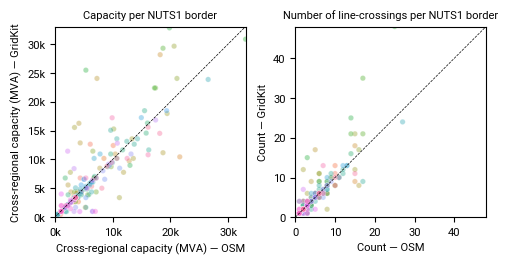

In [38]:
fontsize = 8

fig, ax = plt.subplots(1, 2, figsize=(5, 2.7))
sns.scatterplot(data = metrics_crossborder, x="s_nom_osm", y="s_nom_gridkit", ax=ax[0], alpha=0.4, hue="border", s=15)
sns.scatterplot(data = metrics_crossborder, x="num_parallel_osm", y="num_parallel_gridkit", ax=ax[1], alpha=0.4, hue="border", s=15)

# remove legend
ax[0].legend().remove()
ax[1].legend().remove()


# Add 1:1 line
x_min = 0
x_max = max(metrics_crossborder["s_nom_gridkit"].max(), metrics_crossborder["s_nom_osm"].max())
y_min = 0
y_max = max(metrics_crossborder["s_nom_gridkit"].max(), metrics_crossborder["s_nom_osm"].max())
ax[0].plot([x_min, x_max], [y_min, y_max], color="black", linewidth=0.5, linestyle="--")
ax[0].set_title("Capacity per NUTS1 border")
ax[0].set_xlabel("Cross-regional capacity (MVA) — OSM")
ax[0].set_ylabel("Cross-regional capacity (MVA) — GridKit")
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)
ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(thousands_formatter))
ax[0].xaxis.set_major_formatter(mtick.FuncFormatter(thousands_formatter))


x_min = 0
x_max = max(metrics_crossborder["num_parallel_gridkit"].max(), metrics_crossborder["num_parallel_osm"].max())
y_min = 0
y_max = max(metrics_crossborder["num_parallel_gridkit"].max(), metrics_crossborder["num_parallel_osm"].max())
ax[1].plot([x_min, x_max], [y_min, y_max], color="black", linewidth=0.5, linestyle="--")
ax[1].set_title("Number of line-crossings per NUTS1 border")
ax[1].set_xlabel("Count — OSM")
ax[1].set_ylabel("Count — GridKit")
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylim(y_min, y_max)

ax[0].set_aspect('equal', adjustable='box')
ax[1].set_aspect('equal', adjustable='box')

for i in range(2):
    ax[i].title.set_fontsize(fontsize)

plt.tight_layout()
fig.savefig(f"{parent_dir}/figures/fig_scatter_cross-regional_capacity.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()


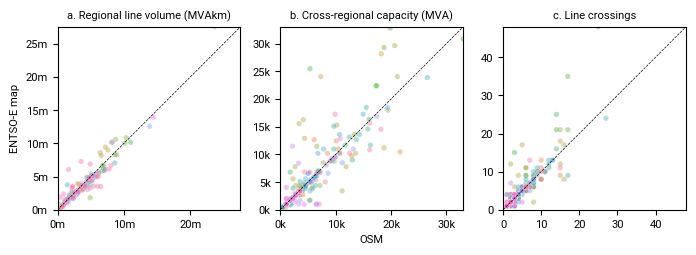

In [39]:
# Joined plot
fontsize = 8
# change font size of titles

# Function to format thousands with 'k' suffix
def millions_formatter(x, pos):
    return '{:.0f}m'.format(x * 1e-6)

fig, ax = plt.subplots(1, 3, figsize=(7, 2.4))
sns.scatterplot(data = metrics_lines_grouped_nuts1, x="line_volume_osm", y="line_volume_gridkit", ax=ax[0], alpha=0.4, hue="country", s=15)
sns.scatterplot(data = metrics_crossborder, x="s_nom_osm", y="s_nom_gridkit", ax=ax[1], alpha=0.4, hue="border", s=15)
sns.scatterplot(data = metrics_crossborder, x="num_parallel_osm", y="num_parallel_gridkit", ax=ax[2], alpha=0.4, hue="border", s=15)

# remove legend
ax[0].legend().remove()
ax[1].legend().remove()
ax[2].legend().remove()


# Line volume
x_min = 0
x_max = max(metrics_lines_grouped_nuts1["line_volume_gridkit"].max(), metrics_lines_grouped_nuts1["line_volume_osm"].max())
y_min = 0
y_max = max(metrics_lines_grouped_nuts1["line_volume_gridkit"].max(), metrics_lines_grouped_nuts1["line_volume_osm"].max())
ax[0].plot([x_min, x_max], [y_min, y_max], color="black", linewidth=0.5, linestyle="--")
ax[0].set_title("a. Regional line volume (MVAkm)")
ax[0].set_xlabel("")
ax[0].set_ylabel("ENTSO-E map")
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)
ax[0].xaxis.set_major_formatter(mtick.FuncFormatter(millions_formatter))
ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(millions_formatter))

x_min = 0
x_max = max(metrics_crossborder["s_nom_gridkit"].max(), metrics_crossborder["s_nom_osm"].max())
y_min = 0
y_max = max(metrics_crossborder["s_nom_gridkit"].max(), metrics_crossborder["s_nom_osm"].max())
ax[1].plot([x_min, x_max], [y_min, y_max], color="black", linewidth=0.5, linestyle="--")
ax[1].set_title("b. Cross-regional capacity (MVA)")
ax[1].set_xlabel("OSM")
ax[1].set_ylabel("")
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylim(y_min, y_max)
ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(thousands_formatter))
ax[1].xaxis.set_major_formatter(mtick.FuncFormatter(thousands_formatter))


x_min = 0
x_max = max(metrics_crossborder["num_parallel_gridkit"].max(), metrics_crossborder["num_parallel_osm"].max())
y_min = 0
y_max = max(metrics_crossborder["num_parallel_gridkit"].max(), metrics_crossborder["num_parallel_osm"].max())
ax[2].plot([x_min, x_max], [y_min, y_max], color="black", linewidth=0.5, linestyle="--")
ax[2].set_title("c. Line crossings")
ax[2].set_xlabel("")
ax[2].set_ylabel("")
ax[2].set_xlim(x_min, x_max)
ax[2].set_ylim(y_min, y_max)

ax[0].set_aspect('equal', adjustable='box')
ax[1].set_aspect('equal', adjustable='box')
ax[2].set_aspect('equal', adjustable='box')

for i in range(3):
    ax[i].title.set_fontsize(fontsize)

plt.tight_layout()
fig.savefig(f"{parent_dir}/figures/fig_scatter_joined.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()


In [40]:
find_inliers_outliers(metrics_crossborder, "s_nom_gridkit", "s_nom_osm", 0.8)[1]

['AT3-DE2',
 'BG3-BG4',
 'CH0-DE1',
 'DE1-DE2',
 'DE1-DE7',
 'DE1-DEB',
 'DE3-DE4',
 'DE6-DEF',
 'DE7-DEA',
 'DE9-DEA',
 'ES2-ES4',
 'ES2-ES5',
 'ES4-ES5',
 'ES4-ES6',
 'FRJ-FRL',
 'UA05-UA32',
 'UA12-UA35',
 'UA12-UA48',
 'UA18-UA32',
 'UA46-UA56',
 'UKE-UKF',
 'UKF-UKG']

In [41]:
metrics_crossborder

s_nom_gridkit  num_parallel_gridkit     s_nom_osm  num_parallel_osm
border                                                                      
AL0-GR5    1698.102612                   1.0   1787.476433               1.0
AL0-ME0    2189.658631                   2.0   2279.032453               2.0
AT1-AT2    4379.317262                   4.0   4379.317262               4.0
AT1-AT3    5362.429300                   6.0   6345.541339               8.0
AT1-CZ0    4379.317262                   4.0   4558.064905               4.0
...                ...                   ...           ...               ...
UKH-UKI   14523.246021                  11.0  18154.057527              15.0
UKH-UKJ   15595.731882                  10.0  16143.146539              10.0
UKI-UKJ    5027.277469                   5.0   8127.431908               6.0
UKJ-UKK   10188.615670                   6.0  10724.858600               6.0
UKK-UKL    8803.321435                   6.0   8993.240806               6.0

[229 rows x 4 columns]

In [42]:
# interactive plotly version
import plotly.express as px

fig = px.scatter(metrics_crossborder, x="s_nom_osm", y="s_nom_gridkit", color=metrics_crossborder.index, hover_name=metrics_crossborder.index)
fig.update_traces(marker=dict(size=5))

fig.update_layout(
    showlegend=True,
    width=600,
    height=500
)
fig.show()


### Model results

In [43]:
import os
import yaml
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import seaborn as sns
from shapely import wkt, LineString, Point
import pandas as pd
import cartopy.crs as ccrs
import numpy as np
import pypsa
from tqdm import tqdm

parent_dir = os.path.dirname(os.getcwd())
if not os.path.exists(parent_dir + '/figures'):
    os.makedirs(parent_dir + '/figures')
if not os.path.exists(parent_dir + '/datatables'):
    os.makedirs(parent_dir + '/datatables')

font = {'family' : 'sans-serif',
        'sans-serif' : 'Roboto',
        'size'   : 8}

plt.rc('font', **font)

In [197]:
# n_results_gridkit = pypsa.Network("data/osm-for-pypsa-eur/entsoegridkit_nuts2/networks/elec_s_318_ec_lv1.0_.nc")
# n_results_osm = pypsa.Network("data/osm-for-pypsa-eur/osm-prebuilt_nuts2/networks/elec_s_318_ec_lv1.0_.nc")

n_results_gridkit = pypsa.Network("data/validation/entsoegridkit/networks/base_s_318_elec_lv1.0_.nc")
n_results_osm = pypsa.Network("data/osm-for-pypsa-eur/osm-prebuilt_nuts2/networks/base_s_318_elec_lv1.0_.nc")

nuts_regions = gpd.read_file("busmaps/nuts2_regions.geojson")
nuts_regions.set_index("region_code", inplace = True)

INFO:pypsa.io:Imported network elec_s_318_ec_lv1.0_.nc has buses, carriers, generators, global_constraints, lines, links, loads, shapes, storage_units, stores
INFO:pypsa.io:Imported network elec_s_318_ec_lv1.0_.nc has buses, carriers, generators, global_constraints, lines, links, loads, shapes, storage_units, stores


In [198]:
# Objective values
print(f"Objective function GridKit: {n_results_gridkit.objective/1e9:.1f} bn €")
print(f"Objective function OSM: {n_results_osm.objective/1e9:.1f} bn €")

Objective function GridKit: 91.8 bn €
Objective function OSM: 90.8 bn €


In [199]:
common_index = n_results_gridkit.buses[n_results_gridkit.buses.v_nom == 380].index.get_level_values("Bus").intersection(n_results_osm.buses[n_results_osm.buses.v_nom == 380].index.get_level_values("Bus"))

In [200]:
curtailment_gridkit = n_results_gridkit.statistics.curtailment(comps=["Generator"], groupby=["bus"]).droplevel("component").loc[common_index]
curtailment_osm = n_results_osm.statistics.curtailment(comps=["Generator"], groupby=["bus"]).droplevel("component").loc[common_index]

print(f"Curtailment GridKit: {curtailment_gridkit.sum()/1e6: .1f} TWh")
print(f"Curtailment OSM: {curtailment_osm.sum()/1e6: .1f} Twh")
print(f"Absolute difference: {(curtailment_osm.sum()-curtailment_gridkit.sum())/1e6: .1f} TWh")
print(f"Percentage difference: {100*(curtailment_osm.sum()-curtailment_gridkit.sum())/curtailment_gridkit.sum(): .2f} %")


Curtailment GridKit:  2177.9 TWh
Curtailment OSM:  2175.6 Twh
Absolute difference: -2.3 TWh
Percentage difference: -0.11 %


In [201]:
optimal_supply_gridkit = n_results_gridkit.statistics.supply(comps=["Generator"], groupby=["bus","carrier"]).droplevel("component").loc[common_index]
optimal_supply_osm = n_results_osm.statistics.supply(comps=["Generator"], groupby=["bus","carrier"]).droplevel("component").loc[common_index]
delta_optimal_supply = optimal_supply_osm - optimal_supply_gridkit

print(f"Optimal supply GridKit: {optimal_supply_gridkit.sum()/1e6: .1f} TWh")
print(f"Optimal supply OSM: {optimal_supply_osm.sum()/1e6: .1f} TWh")
print(f"Absolute difference: {(optimal_supply_osm.sum()-optimal_supply_gridkit.sum())/1e6: .1f} TWh")
print(f"Percentage difference: {100*(optimal_supply_osm.sum()-optimal_supply_gridkit.sum())/optimal_supply_osm.sum(): .2f} %")

Optimal supply GridKit:  3120.0 TWh
Optimal supply OSM:  3110.0 TWh
Absolute difference: -10.0 TWh
Percentage difference: -0.32 %


In [202]:
nuts_regions

name country_code     type  \
region_code                                               
DE12                    Karlsruhe           DE    NUTS2   
CH05                   Ostschweiz           CH    NUTS2   
CZ02                Střední Čechy           CZ    NUTS2   
CH01             Région lémanique           CH    NUTS2   
BE24         Prov. Vlaams-Brabant           BE    NUTS2   
...                           ...          ...      ...   
MD3142                       3142           MD  Voronoi   
MD3152                       3152           MD  Voronoi   
MD3246                       3246           MD  Voronoi   
MD7049                       7049           MD  Voronoi   
MD8855                       8855           MD  Voronoi   

                                                      geometry  
region_code                                                     
DE12         MULTIPOLYGON (((9.60382 49.42658, 9.57113 49.4...  
CH05         MULTIPOLYGON (((8.61383 47.80108, 8.62155 47.7...  
CZ02         MULTIPOLYGON (((15.14677 50.52294, 15.14161 50...  
CH01         MULTIPOLYGON (((6.78005 46.85264, 6.74231 46.8...  
BE24         POLYGON ((5.10348 50.70906, 5.09468 50.70367, ...  
...                                                        ...  
MD3142       POLYGON ((28.93464 47.38601, 29.3625 47.34172,...  
MD3152       POLYGON ((28.54589 46.47461, 28.94374 46.29867...  
MD3246       POLYGON ((28.50827 47.74951, 27.92919 47.06674...  
MD7049       POLYGON ((29.51 47.06789, 29.51146 47.06602, 2...  
MD8855       POLYGON ((28.52033 45.60203, 28.5231 45.59324,...  

[345 rows x 4 columns]

In [203]:
# clip nuts_regions to the extent of the network
country_mask = gpd.read_file("geojson/country_shapes.geojson").union_all()
nuts_regions = gpd.clip(nuts_regions, country_mask)

In [204]:
nuts_results = nuts_regions.loc[common_index].copy()
nuts_results = nuts_results.assign(curtailment_gridkit=curtailment_gridkit)
nuts_results = nuts_results.assign(curtailment_osm=curtailment_osm)
nuts_results = nuts_results.assign(delta_curtailment=curtailment_osm-curtailment_gridkit)
nuts_results = nuts_results.assign(optimal_supply_gridkit=optimal_supply_gridkit.groupby("bus").sum())
nuts_results = nuts_results.assign(optimal_supply_osm=optimal_supply_osm.groupby("bus").sum())
nuts_results = nuts_results.assign(delta_optimal_supply=nuts_results["optimal_supply_osm"]-nuts_results["optimal_supply_gridkit"])

In [205]:
n_results_gridkit.lines["p0_sum"] = n_results_gridkit.lines_t.p0.sum()
n_results_osm.lines["p0_sum"] = n_results_osm.lines_t.p0.sum()

n_results_gridkit.links["p0_sum"] = n_results_gridkit.links_t.p0.sum()
n_results_osm.links["p0_sum"] = n_results_osm.links_t.p0.sum()

In [206]:
def sort_buses_flow(row):
    alphabetic_bus_first = row["bus0"] == min(row["bus0"], row["bus1"])

    if alphabetic_bus_first:
        return row
    else:
        bus0_old = row["bus0"]
        bus1_old = row["bus1"]
        row["bus0"] = bus1_old
        row["bus1"] = bus0_old
        row["p0_sum"] = -row["p0_sum"]
        return row


In [207]:
delta_links_gridkit = n_results_gridkit.links[n_results_gridkit.links.carrier == "DC"].copy()[["bus0", "bus1", "p0_sum"]].reset_index()
delta_links_gridkit["border"] = delta_links_gridkit.apply(lambda row: min(str(row["bus0"]), str(row["bus1"])) + "-" + max(str(row["bus0"]), str(row["bus1"])), axis = 1)
delta_links_gridkit = delta_links_gridkit.apply(lambda row: sort_buses_flow(row), axis=1)
delta_links_gridkit = delta_links_gridkit.groupby("border").agg({"p0_sum": "sum"})


delta_links_osm = n_results_osm.links[n_results_osm.links.carrier == "DC"].copy()[["bus0", "bus1", "p0_sum"]].reset_index()
delta_links_osm["border"] = delta_links_osm.apply(lambda row: min(str(row["bus0"]), str(row["bus1"])) + "-" + max(str(row["bus0"]), str(row["bus1"])), axis = 1)
delta_links_osm = delta_links_osm.apply(lambda row: sort_buses_flow(row), axis=1)
delta_links_osm = delta_links_osm.groupby("border").agg({"p0_sum": "sum"})

delta_links = delta_links_gridkit.merge(delta_links_osm, left_index = True, right_index = True, suffixes = ("_gridkit", "_osm"), how = "outer")
delta_links.fillna({"p0_sum_gridkit": 0, "p0_sum_osm": 0}, inplace = True)

delta_links["p0_sum_abs_delta"] = delta_links["p0_sum_osm"].abs() - delta_links["p0_sum_gridkit"].abs()

delta_links.reset_index(inplace = True)
delta_links["bus0"] = delta_links.apply(lambda row: row["border"].split("-")[0], axis = 1)
delta_links["bus1"] = delta_links.apply(lambda row: row["border"].split("-")[1], axis = 1)

delta_links = delta_links.merge(n_results_osm.buses.reset_index()[["Bus", "x", "y"]], left_on="bus0", right_on="Bus", how = "left").drop(columns="Bus")
delta_links = delta_links.merge(n_results_osm.buses.reset_index()[["Bus", "x", "y"]], left_on="bus1", right_on="Bus", how = "left", suffixes=("0", "1")).drop(columns="Bus")

###
delta_links.set_index("bus0", inplace=True)
buses_subset = delta_links[delta_links.x0.isna() | delta_links.y0.isna()].merge(n_results_gridkit.buses[["x", "y"]], how = "left", left_index=True, right_index=True)[["x", "y"]]
delta_links[delta_links.x0.isna() | delta_links.y0.isna()]
delta_links.loc[delta_links.x0.isna() | delta_links.y0.isna(), ["x0"]] = buses_subset["x"]
delta_links.loc[delta_links.x0.isna() | delta_links.y0.isna(), ["y0"]] = buses_subset["y"]

###
delta_links.reset_index(inplace=True)
delta_links.set_index("bus1", inplace=True)
buses_subset = delta_links[delta_links.x1.isna() | delta_links.y1.isna()].merge(n_results_gridkit.buses[["x", "y"]], how = "left", left_index=True, right_index=True)[["x", "y"]]
delta_links[delta_links.x1.isna() | delta_links.y1.isna()]
delta_links.loc[delta_links.x1.isna() | delta_links.y1.isna(), ["x1"]] = buses_subset["x"]
delta_links.loc[delta_links.x1.isna() | delta_links.y1.isna(), ["y1"]] = buses_subset["y"]

delta_links.reset_index(inplace=True)
delta_links.set_index("border", inplace=True)
delta_links

###
delta_links["geometry"] = delta_links.apply(lambda row: LineString([(row["x0"], row["y0"]), (row["x1"], row["y1"])]), axis=1)
delta_links = gpd.GeoDataFrame(delta_links, geometry="geometry", crs="EPSG:4326")

delta_links["p0_sum_abs_delta_rel"] = delta_links["p0_sum_abs_delta"]/delta_links["p0_sum_osm"].abs()
# find where values are inf
delta_links.loc[delta_links["p0_sum_abs_delta_rel"] == np.inf, "p0_sum_abs_delta_rel"] = 1
delta_links.loc[delta_links["p0_sum_abs_delta_rel"] == -1*np.inf, "p0_sum_abs_delta_rel"] = -1

delta_links.fillna({"p0_sum_abs_delta_rel": 0}, inplace = True)

# Only keep changes bigger than 5%
delta_links = delta_links[delta_links["p0_sum_abs_delta_rel"].abs() > 0]
delta_links

bus1  bus0  p0_sum_gridkit    p0_sum_osm  p0_sum_abs_delta  \
border                                                                  
BE25-GBJ4  GBJ4  BE25    0.000000e+00 -3.971326e+06      3.971326e+06   
BE33-DEA2  DEA2  BE33    3.919963e+06  5.683462e+06      1.763498e+06   
DE80-DK02  DK02  DE80   -3.546393e+06 -3.706306e+06      1.599128e+05   
DEF0-NO09  NO09  DEF0   -3.954067e+06 -3.847288e+06     -1.067797e+05   
DEF0-SE22  SE22  DEF0   -1.458184e+06 -2.016497e+06      5.583132e+05   
DK02-DK03  DK03  DK02    1.270062e+06  1.992309e+06      7.222467e+05   
DK03-GBF3  GBF3  DK03    0.000000e+00  1.698914e+05      1.698914e+05   
DK03-NL11  NL11  DK03    2.458485e+06  4.013046e+06      1.554561e+06   
DK04-NO09  NO09  DK04   -1.045309e+06 -1.600176e+06      5.548670e+05   
DK05-SE23  SE23  DK05   -9.836643e+05 -3.955907e+05     -5.880736e+05   
EE00-FI1B  FI1B  EE00   -2.034802e+06 -2.427888e+06      3.930859e+05   
ES51-FRJ1  FRJ1  ES51   -2.092540e+05  6.973508e+05      4.880967e+05   
ES52-ES53  ES53  ES52    2.272704e+06  2.032923e+06     -2.397810e+05   
FI19-SE12  SE12  FI19   -3.525373e+06 -2.282989e+06     -1.242383e+06   
FI19-SE31  SE31  FI19   -5.961521e+06 -5.177823e+06     -7.836979e+05   
FRD1-GBJ3  GBJ3  FRD1    0.000000e+00  5.957904e+05      5.957904e+05   
FRE1-GBJ4  GBJ4  FRE1    2.250080e+06 -2.427653e+04     -2.225803e+06   
FRM0-ITG2  ITG2  FRM0   -1.375772e+06 -1.009064e+06     -3.667085e+05   
FRM0-ITI1  ITI1  FRM0   -6.008101e+05  3.249024e+05     -2.759077e+05   
GBC2-NO09  NO09  GBC2   -2.875217e+06  0.000000e+00     -2.875217e+06   
GBC2-NO0A  NO0A  GBC2    0.000000e+00 -2.322004e+06      2.322004e+06   
GBJ4-NL33  NL33  GBJ4    3.031326e+06  4.790880e+06      1.759554e+06   
GBL2-GBM9  GBM9  GBL2   -7.407136e+06 -3.405182e+06     -4.001953e+06   
GBL2-IE06  IE06  GBL2    7.394262e+05  3.966223e+05     -3.428039e+05   
GBM9-GBN0  GBN0  GBM9    1.592389e+06  2.654739e+06      1.062350e+06   
GR54-ITF4  ITF4  GR54   -3.842549e+05 -1.139519e+06      7.552636e+05   
ITF1-ME00  ME00  ITF1    3.314535e+06  4.490015e+06      1.175480e+06   
ITG2-ITI4  ITI4  ITG2    3.362559e+06  4.747158e+06      1.384598e+06   
LT02-PL62  PL62  LT02    9.049934e+06  0.000000e+00     -9.049934e+06   
LT02-SE21  SE21  LT02   -3.783908e+06 -3.925531e+06      1.416234e+05   
NL11-NO09  NO09  NL11   -1.937038e+06 -2.041704e+06      1.046661e+05   
PL63-SE22  SE22  PL63   -2.280776e+06 -2.422782e+06      1.420062e+05   
SE21-SE22  SE22  SE21    0.000000e+00 -1.325920e+06      1.325920e+06   

                  x0         y0         x1         y1  \
border                                                  
BE25-GBJ4   3.330033  51.091533   0.944822  51.254911   
BE33-DEA2   5.540917  50.566000   6.956184  50.861868   
DE80-DK02  12.436500  53.725900  12.295200  55.260580   
DEF0-NO09   9.847635  53.941494   8.341713  59.177264   
DEF0-SE22   9.847635  53.941494  13.401017  55.955244   
DK02-DK03  12.295200  55.260580   9.452060  55.383813   
DK03-GBF3   9.452060  55.383813  -0.148650  52.887400   
DK03-NL11   9.452060  55.383813   6.921380  53.148660   
DK04-NO09   9.773362  56.164900   8.341713  59.177264   
DK05-SE23   9.859350  56.885667  12.815696  57.521535   
EE00-FI1B  25.473232  58.657300  24.949594  60.376194   
ES51-FRJ1   1.640180  41.619700   3.544433  43.663267   
ES52-ES53  -0.606815  39.053382   2.700000  39.603340   
FI19-SE12  22.887110  62.159807  16.359595  59.367636   
FI19-SE31  22.887110  62.159807  15.636879  61.097851   
FRD1-GBJ3  -0.530120  48.921900  -1.163750  51.023333   
FRE1-GBJ4   2.691084  50.547058   0.944822  51.254911   
FRM0-ITG2   9.450600  42.528800   8.768673  39.930091   
FRM0-ITI1   9.450600  42.528800  10.972950  43.567350   
GBC2-NO09  -1.646633  55.001083   8.341713  59.177264   
GBC2-NO0A  -1.646633  55.001083   6.160864  60.532843   
GBJ4-NL33   0.944822  51.254911   4.452383  51.953567   
GBL2-GBM9  -3.124478  52.053644  -3.851847  55.517607   
GBL2-IE06  -3.124478  52.05364

In [208]:
delta_lines_gridkit = n_results_gridkit.lines.copy()[["bus0", "bus1", "p0_sum", "s_nom_max"]].reset_index()
delta_lines_gridkit["border"] = delta_lines_gridkit.apply(lambda row: min(str(row["bus0"]), str(row["bus1"])) + "-" + max(str(row["bus0"]), str(row["bus1"])), axis = 1)
delta_lines_gridkit = delta_lines_gridkit.apply(lambda row: sort_buses_flow(row), axis=1)
delta_lines_gridkit = delta_lines_gridkit.groupby("border").agg({"p0_sum": "sum", "s_nom_max": "sum"})


delta_lines_osm = n_results_osm.lines.copy()[["bus0", "bus1", "p0_sum", "s_nom_max"]].reset_index()
delta_lines_osm["border"] = delta_lines_osm.apply(lambda row: min(str(row["bus0"]), str(row["bus1"])) + "-" + max(str(row["bus0"]), str(row["bus1"])), axis = 1)
delta_lines_osm = delta_lines_osm.apply(lambda row: sort_buses_flow(row), axis=1)
delta_lines_osm = delta_lines_osm.groupby("border").agg({"p0_sum": "sum", "s_nom_max": "sum"})

delta_lines = delta_lines_gridkit.merge(delta_lines_osm, left_index = True, right_index = True, suffixes = ("_gridkit", "_osm"), how = "outer")
delta_lines.fillna({"p0_sum_gridkit": 0, "p0_sum_osm": 0}, inplace = True)
delta_lines.fillna({"s_nom_max_gridkit": 0, "s_nom_max_osm": 0}, inplace = True)

delta_lines["p0_sum_abs_delta"] = delta_lines["p0_sum_osm"].abs() - delta_lines["p0_sum_gridkit"].abs()
delta_lines["s_nom_max_delta"] = delta_lines["s_nom_max_osm"] - delta_lines["s_nom_max_gridkit"]

delta_lines.reset_index(inplace = True)
delta_lines["bus0"] = delta_lines.apply(lambda row: row["border"].split("-")[0], axis = 1)
delta_lines["bus1"] = delta_lines.apply(lambda row: row["border"].split("-")[1], axis = 1)

delta_lines = delta_lines.merge(n_results_osm.buses.reset_index()[["Bus", "x", "y"]], left_on="bus0", right_on="Bus", how = "left").drop(columns="Bus")
delta_lines = delta_lines.merge(n_results_osm.buses.reset_index()[["Bus", "x", "y"]], left_on="bus1", right_on="Bus", how = "left", suffixes=("0", "1")).drop(columns="Bus")

###
delta_lines.set_index("bus0", inplace=True)
buses_subset = delta_lines[delta_lines.x0.isna() | delta_lines.y0.isna()].merge(n_results_gridkit.buses[["x", "y"]], how = "left", left_index=True, right_index=True)[["x", "y"]]
delta_lines[delta_lines.x0.isna() | delta_lines.y0.isna()]
delta_lines.loc[delta_lines.x0.isna() | delta_lines.y0.isna(), ["x0"]] = buses_subset["x"]
delta_lines.loc[delta_lines.x0.isna() | delta_lines.y0.isna(), ["y0"]] = buses_subset["y"]

###
delta_lines.reset_index(inplace=True)
delta_lines.set_index("bus1", inplace=True)
buses_subset = delta_lines[delta_lines.x1.isna() | delta_lines.y1.isna()].merge(n_results_gridkit.buses[["x", "y"]], how = "left", left_index=True, right_index=True)[["x", "y"]]
delta_lines[delta_lines.x1.isna() | delta_lines.y1.isna()]
delta_lines.loc[delta_lines.x1.isna() | delta_lines.y1.isna(), ["x1"]] = buses_subset["x"]
delta_lines.loc[delta_lines.x1.isna() | delta_lines.y1.isna(), ["y1"]] = buses_subset["y"]

delta_lines.reset_index(inplace=True)
delta_lines.set_index("border", inplace=True)
delta_lines

###
delta_lines["geometry"] = delta_lines.apply(lambda row: LineString([(row["x0"], row["y0"]), (row["x1"], row["y1"])]), axis=1)
delta_lines = gpd.GeoDataFrame(delta_lines, geometry="geometry", crs="EPSG:4326")

delta_lines["p0_sum_abs_delta_rel"] = delta_lines["p0_sum_abs_delta"]/delta_lines["p0_sum_gridkit"].abs()
# find where values are inf
delta_lines.loc[delta_lines["p0_sum_abs_delta_rel"] == np.inf, "p0_sum_abs_delta_rel"] = 1
delta_lines.loc[delta_lines["p0_sum_abs_delta_rel"] == -1*np.inf, "p0_sum_abs_delta_rel"] = -1

delta_lines.fillna({"p0_sum_abs_delta_rel": 0}, inplace = True)

# Only keep changes bigger than 5%
delta_lines = delta_lines[delta_lines["p0_sum_abs_delta_rel"].abs() > 0]

delta_lines

bus1  bus0  p0_sum_gridkit  s_nom_max_gridkit    p0_sum_osm  \
border                                                                   
AL01-AL02  AL02  AL01   -6.177111e+06       26837.097358 -4.939183e+06   
AL01-AL03  AL03  AL01   -6.280080e+05       20491.556019 -6.812487e+05   
AL01-ME00  ME00  AL01    3.725887e+06       22189.658631  3.919258e+06   
AL01-RS21  RS21  AL01    1.277781e+06       20491.556019  1.216352e+06   
AL01-RS22  RS22  AL01    3.229945e+06       21698.102612  2.918046e+06   
...         ...   ...             ...                ...           ...   
UA59-UA63  UA63  UA59    1.276121e+06       21005.455494  1.865019e+06   
UA59-UA74  UA74  UA59    1.178941e+06       21005.455494  3.508397e+05   
UA61-UA68  UA68  UA61    1.866972e+05       21005.455494 -1.433714e+06   
UA61-UA77  UA77  UA61    5.264476e+05       21005.455494  0.000000e+00   
UA68-UA77  UA77  UA68    4.404980e+05       21005.455494  1.358974e+06   

           s_nom_max_osm  p0_sum_abs_delta  s_nom_max_delta         x0  \
border                                                                   
AL01-AL02   26524.288982     -1.237928e+06      -312.808376  19.691860   
AL01-AL03   20491.556019      5.324068e+04         0.000000  19.691860   
AL01-ME00   22279.032453      1.933709e+05        89.373822  19.691860   
AL01-RS21   20491.556019     -6.142860e+04         0.000000  19.691860   
AL01-RS22   21787.476433     -3.118999e+05        89.373822  19.691860   
...                  ...               ...              ...        ...   
UA59-UA63   21106.001043      5.888982e+05       100.545549  34.148700   
UA59-UA74   21106.001043     -8.281015e+05       100.545549  34.148700   
UA61-UA68   21106.001043      1.247017e+06       100.545549  25.633700   
UA61-UA77       0.000000     -5.264476e+05    -21005.455494  25.633700   
UA68-UA77   21106.001043      9.184758e+05       100.545549  26.815575   

                  y0         x1         y1  \
border                                       
AL01-AL02  41.982040  19.854433  41.267600   
AL01-AL03  41.982040  20.218250  40.700200   
AL01-ME00  41.982040  19.159300  42.755330   
AL01-RS21  41.982040  20.549060  43.519527   
AL01-RS22  41.982040  21.774493  43.407764   
...              ...        ...        ...   
UA59-UA63  50.933125  36.434418  49.542673   
UA59-UA74  50.933125  31.577150  51.335100   
UA61-UA68  49.489100  26.815575  49.624700   
UA61-UA77  49.489100  26.638750  48.476300   
UA68-UA77  49.624700  26.638750  48.476300   

                                                    geometry  \
border                                                         
AL01-AL02   LINESTRING (19.69186 41.98204, 19.85443 41.2676)   
AL01-AL03   LINESTRING (19.69186 41.98204, 20.21825 40.7002)   
AL01-ME00   LINESTRING (19.69186 41.98204, 19.1593 42.75533)   
AL01-RS21  LINESTRING (19.69186 41.98204, 20.54906 43.51953)   
AL01-RS22  LINESTRING (19.69186 41.98204, 21.77449 43.40776)   
...                                                      ...   
UA59-UA63   LINESTRING (34.1487 50.93312, 36.43442 49.54267)   
UA59-UA74    LINESTRING (34.1487 50.93312, 31.57715 51.3351)   
UA61-UA68     LINESTRING (25.6337 49.4891, 26.81558 49.6247)   
UA61-UA77     LINESTRING (25.6337 49.4891, 26.63875 48.4763)   
UA68-UA77    LINESTRING (26.81558 49.6247, 26.63875 48.4763)   

           p0_sum_abs_delta_rel  
border                           
AL01-AL02             -0.200406  
AL01-AL03              0.084777  
AL01-ME00              0.051899  
AL01-RS21             -0.048074  
AL01-RS22             -0.096565  
...                         ...  
UA59-UA63              0.461475  
UA59-UA74             -0.702411  
UA61-UA68              6.679354  
UA61-UA77             -1.000000  
UA68-UA77              2.085085  

[633 rows x 14 columns]

In [209]:
vmax = 80*1e6

In [210]:
cmap_curtailment = mcolors.LinearSegmentedColormap.from_list("", ["whitesmoke", "royalblue"])
norm_curtailment = mcolors.Normalize(vmin=0, vmax=max(curtailment_gridkit.max(), curtailment_osm.max()))
norm_curtailment = mcolors.Normalize(vmin=0, vmax=vmax)

In [211]:
cmap_delta_curtailment = mcolors.LinearSegmentedColormap.from_list("", ["rosybrown", "whitesmoke", "royalblue"])
norm_delta_curtailment = mcolors.TwoSlopeNorm(vmin=-max(curtailment_gridkit.max(), curtailment_osm.max()), 
                                              vcenter=0, 
                                              vmax=max(curtailment_gridkit.max(), curtailment_osm.max()))
norm_delta_curtailment = mcolors.TwoSlopeNorm(vmin=-vmax, 
                                              vcenter=0, 
                                              vmax=vmax)

In [212]:
cmap_delta_lines = mcolors.LinearSegmentedColormap.from_list("", ["rosybrown", "whitesmoke", "royalblue"])
norm_delta_lines = mcolors.TwoSlopeNorm(vmin=-2, 
                                        vcenter=0, 
                                        vmax=2)

In [213]:
config = yaml.safe_load(open("data/config.yaml", "r"))
tech_colors = config["plotting"]["tech_colors"]
techs = optimal_supply_gridkit.index.get_level_values("carrier").unique().intersection(optimal_supply_osm.index.get_level_values("carrier").unique())
tech_colors_subset = {tech: tech_colors[tech] for tech in techs}

In [214]:
def add_clean_axes(fig, position, clean = True):
    ax = fig.add_axes(position)
    ax.patch.set_alpha(0)  # Optional: make background transparent
    if clean:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    return ax

In [215]:
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches, add_legend_semicircles

/home/bobby/miniconda3/envs/pypsa-eur-dev/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

/home/bobby/miniconda3/envs/pypsa-eur-dev/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



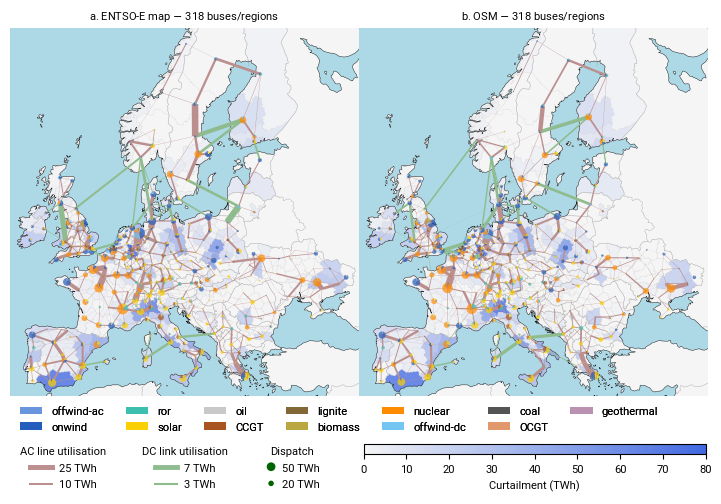

In [216]:
minx, miny, maxx, maxy = nuts_results.geometry.total_bounds
extent = [minx-1, maxx+0.5, miny-0.5, maxy-5.5]

linewidth_factor = 1e6*7
linkwidth_factor = 1e6*2
bus_size_factor = 1e8*2

def mwh_to_twh_formatter(x, pos):
    return '{:.0f}'.format(x * 1e-6)

crs = ccrs.Mercator()
fontsize = 8

# Set up the plot with Equal Earth projection
fig, ax = plt.subplots(1, 2, figsize=(9, 5), subplot_kw={"projection": crs}, gridspec_kw={"wspace": 0, "hspace": 0})

# Plots
nuts_results.to_crs(crs.proj4_init).plot(ax=ax[0], color=cmap_curtailment(norm_curtailment(nuts_results.curtailment_gridkit)), edgecolor="#ccc", linewidth=0.1)
n_results_gridkit.plot(ax=ax[0],
                       bus_sizes = optimal_supply_gridkit/bus_size_factor,
                       line_widths=n_results_gridkit.lines_t.p0.sum().abs()/linewidth_factor, link_widths=n_results_gridkit.links_t.p0.sum().abs()/linkwidth_factor, color_geomap=True, bus_alpha=0.7)
ax[0].set_title('a. ENTSO-E map $-$ 318 buses/regions')

nuts_results.to_crs(crs.proj4_init).plot(ax=ax[1], color=cmap_curtailment(norm_curtailment(nuts_results.curtailment_osm)), edgecolor="#ccc", linewidth=0.1)
n_results_osm.plot(
    ax=ax[1],bus_sizes = optimal_supply_osm/bus_size_factor,
    line_widths=n_results_osm.lines_t.p0.sum().abs()/linewidth_factor,
    link_widths=n_results_osm.links_t.p0.sum().abs()/linkwidth_factor, 
    color_geomap=True, 
    bus_alpha=0.7)           
ax[1].set_title('b. OSM $-$ 318 buses/regions')

ax[0].set_extent(extent)
ax[1].set_extent(extent)

# change font size of titles
for i in range(2):
    ax[i].title.set_fontsize(fontsize)

ax_cbar_curtailment = fig.add_axes([0.518, 0.01, 0.38, 0.02])
cbar_curtailment = fig.colorbar(cm.ScalarMappable(norm=norm_curtailment, cmap=cmap_curtailment), cax=ax_cbar_curtailment, orientation='horizontal')
ax_cbar_curtailment.xaxis.set_major_formatter(mtick.FuncFormatter(mwh_to_twh_formatter))
cbar_curtailment.set_label('Curtailment (TWh)', fontsize=fontsize)

sizes = [25, 10]
labels = [f"{s} TWh" for s in sizes]
scale = 1e6 / linewidth_factor
sizes = [s * scale for s in sizes]

# Line utilisation
legend_kw = dict(
    loc="lower left",
    bbox_to_anchor=(0,-0.28),
    frameon=False,
    labelspacing=0.6,
    handletextpad=0.6,
    title="AC line utilisation",
)

add_legend_lines(
    ax[0],
    sizes,
    labels,
    patch_kw=dict(color="rosybrown"),
    legend_kw=legend_kw,
)

sizes = [7, 3]
labels = [f"{s} TWh" for s in sizes]
scale = 1e6 / linkwidth_factor
sizes = [s * scale for s in sizes]

# Link utilisation
legend_kw = dict(
    loc="lower left",
    bbox_to_anchor=(0.35,-0.28),
    frameon=False,
    labelspacing=0.6,
    handletextpad=0.6,
    title="DC link utilisation",
)

add_legend_lines(
    ax[0],
    sizes,
    labels,
    patch_kw=dict(color="darkseagreen"),
    legend_kw=legend_kw,
)

legend_kw = dict(
    loc="lower left",
    bbox_to_anchor=(0.7, -0.28),
    labelspacing=0.6,
    handletextpad=-0.4,
    frameon=False,
    title = "Dispatch"
)

# Circles

sizes = [50, 20]
labels = [f"{s} TWh" for s in sizes]
sizes = [s / bus_size_factor * 1e6 for s in sizes]

add_legend_circles(
    ax[0],
    sizes,
    labels,
    # srid=n.srid,
    patch_kw=dict(facecolor="darkgreen"),
    legend_kw=legend_kw,
)

labels = [f"{s} GWh" for s in sizes]
sizes = [s * scale for s in sizes]

colors = list(tech_colors_subset.values())
labels = list(tech_colors_subset.keys())

legend_kw = dict(
    loc="upper left",
    bbox_to_anchor=(0, 0),
    ncol=7,
    frameon=False,
)

add_legend_patches(ax[0], colors, labels, legend_kw=legend_kw)

plt.show()

fig.savefig(f"{parent_dir}/figures/fig_results_sidebyside.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

/home/bobby/miniconda3/envs/pypsa-eur-dev/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



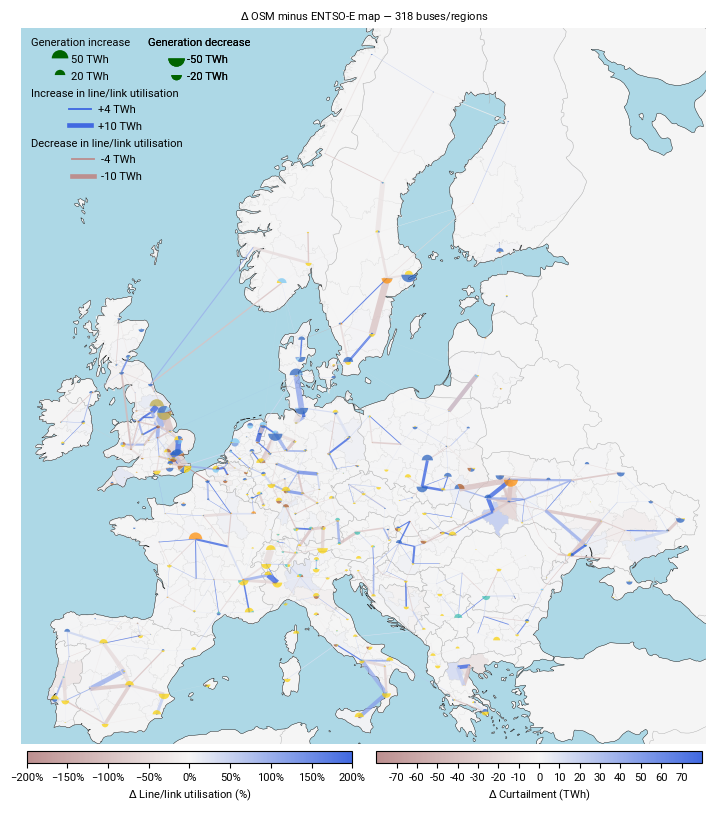

In [217]:
### Delta

minx, miny, maxx, maxy = nuts_results.geometry.total_bounds
extent = [minx-1, maxx+0.5, miny, maxy-5.5]

linewidth_factor = 1e6*3
bus_size_factor = 1e8*2

def mwh_to_twh_formatter(x, pos):
    return '{:.0f}'.format(x * 1e-6)

crs = ccrs.Mercator()
fontsize = 8

# Set up the plot with Equal Earth projection
fig, ax = plt.subplots(1, 1, figsize=(9.3, 9.3), subplot_kw={"projection": crs}, gridspec_kw={"wspace": 0, "hspace": 0})

nuts_results.to_crs(crs.proj4_init).plot(ax=ax, color=cmap_delta_curtailment(norm_delta_curtailment(nuts_results.delta_curtailment)), edgecolor="#ccc", linewidth=0.1)
n_results_osm.plot(
    ax=ax,
    bus_sizes = delta_optimal_supply/bus_size_factor, 
    line_widths=0,
    link_widths=0, color_geomap=True, bus_alpha=0.7, bus_split_circles=True)

delta_lines.to_crs(crs.proj4_init).plot(ax=ax, column='p0_sum_abs_delta_rel', cmap=cmap_delta_lines, norm = norm_delta_lines, linewidth=abs(delta_lines.p0_sum_abs_delta)/linewidth_factor, alpha=0.8, colors=cmap_delta_lines(norm_delta_lines(delta_lines.p0_sum_abs_delta_rel)))
delta_links.to_crs(crs.proj4_init).plot(ax=ax, column='p0_sum_abs_delta_rel', cmap=cmap_delta_lines, norm = norm_delta_lines, linewidth=abs(delta_links.p0_sum_abs_delta)/linewidth_factor, alpha=0.8, colors=cmap_delta_lines(norm_delta_lines(delta_links.p0_sum_abs_delta_rel)))
ax.set_title(r'$\Delta$ OSM minus ENTSO-E map $-$ 318 buses/regions')

# Set limits to zoom into the map based on the extent of country shapes
ax.set_extent(extent)
ax.title.set_fontsize(fontsize)

ax_cbar_delta_lines= fig.add_axes([0.15, 0.09, 0.35, 0.012])
cbar_delta_lines = fig.colorbar(cm.ScalarMappable(norm=norm_delta_lines, cmap=cmap_delta_lines), cax=ax_cbar_delta_lines, orientation='horizontal')
# ax_cbar_delta_lines.xaxis.set_major_formatter(mtick.FuncFormatter(mwh_to_twh_formatter))
cbar_delta_lines.set_label(r'$\Delta$ Line/link utilisation (%)', fontsize=fontsize)
# Convert cbar axis labels to % by multiplying by 100
ax_cbar_delta_lines.xaxis.set_major_formatter(mtick.PercentFormatter(1))

ax_cbar_delta_curtailment = fig.add_axes([0.526, 0.09, 0.35, 0.012])
cbar_delta_curtailment = fig.colorbar(cm.ScalarMappable(norm=norm_delta_curtailment, cmap=cmap_delta_curtailment), cax=ax_cbar_delta_curtailment, orientation='horizontal')
cbar_delta_curtailment.set_label(r'$\Delta$ Curtailment (TWh)', fontsize=fontsize)

ticks = np.arange(-70, 80, 10)*1e6
cbar_delta_curtailment.set_ticks(ticks)
ax_cbar_delta_curtailment.xaxis.set_major_formatter(mtick.FuncFormatter(mwh_to_twh_formatter))


# Delta lines
sizes = [4, 10]
labels = [f"+{s} TWh" for s in sizes]
scale = 1e6 / linewidth_factor
sizes = [s * scale for s in sizes]

legend_kw = dict(
    loc="upper left",
    bbox_to_anchor=(0, 0.93),
    frameon=False,
    labelspacing=0.6,
    handletextpad=0.6,
    title="Increase in line/link utilisation",
)


add_legend_lines(
    ax,
    sizes,
    labels,
    patch_kw=dict(color="royalblue"),
    legend_kw=legend_kw,
)

sizes = [4, 10]
labels = [f"-{s} TWh" for s in sizes]
scale = 1e6 / linewidth_factor
sizes = [s * scale for s in sizes]

legend_kw = dict(
    loc="upper left",
    bbox_to_anchor=(0, 0.86),
    frameon=False,
    labelspacing=0.6,
    handletextpad=0.6,
    title="Decrease in line/link utilisation",
)

add_legend_lines(
    ax,
    sizes,
    labels,
    patch_kw=dict(color="rosybrown"),
    legend_kw=legend_kw,
)

# Semicircles

legend_kw = dict(
    loc="upper left",
    bbox_to_anchor=(0, 1),
    labelspacing=0.6,
    handletextpad=-0.4,
    frameon=False,
    title = "Generation increase"
)

sizes = [50, 20]
labels = [f"{s} TWh" for s in sizes]
sizes = [s / bus_size_factor * 1e6 for s in sizes]

add_legend_semicircles(
    ax,
    sizes,
    labels,
    # srid=n.srid,
    patch_kw=dict(facecolor="darkgreen"),
    legend_kw=legend_kw,
)

# Semicircles

legend_kw = dict(
    loc="upper left",
    bbox_to_anchor=(0.17, 1),
    labelspacing=0.6,
    handletextpad=-0.4,
    frameon=False,
    title = "Generation decrease"
)

sizes = [-50, -20]
labels = [f"{s} TWh" for s in sizes]
sizes = [s / bus_size_factor * 1e6 for s in sizes]

add_legend_semicircles(
    ax,
    sizes,
    labels,
    # srid=n.srid,
    patch_kw=dict(facecolor="darkgreen"),
    legend_kw=legend_kw,
)

plt.show()

fig.savefig(f"{parent_dir}/figures/fig_results_delta.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

In [218]:
n_results_gridkit.statistics.curtailment(comps=["Generator"], groupby=["bus"]).droplevel("component").loc[common_index]
#

Bus
AL01    7.205740e+03
AL02    1.080097e+03
AL03    1.025223e+06
AT11    5.931948e+04
AT12    1.040201e+04
            ...     
UA65    2.328256e+02
UA68    1.838744e+02
UA71    2.589738e+02
UA74    2.102102e+02
UA77    1.946416e+04
Name: generators, Length: 312, dtype: float64

#### Additional maps for appendix

In [219]:
optimal_capacity_gridkit = n_results_gridkit.statistics.optimal_capacity(comps=["Generator"], groupby=["bus","carrier"]).droplevel("component").loc[common_index]
optimal_capacity_osm = n_results_osm.statistics.optimal_capacity(comps=["Generator"], groupby=["bus","carrier"]).droplevel("component").loc[common_index]

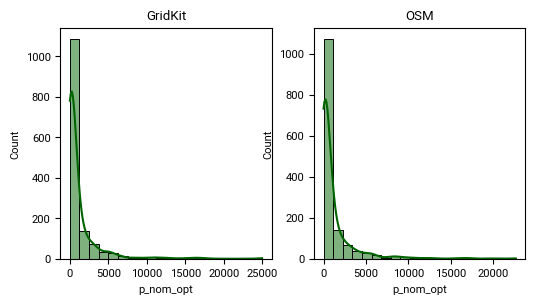

In [220]:
# histogram of optimal capacities
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
sns.histplot(optimal_capacity_gridkit, ax=ax[0], bins=20, color="darkgreen", kde=True)
sns.histplot(optimal_capacity_osm, ax=ax[1], bins=20, color="darkgreen", kde=True)
ax[0].set_title("GridKit")
ax[1].set_title("OSM")
plt.show()


/home/bobby/miniconda3/envs/pypsa-eur-dev/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

/home/bobby/miniconda3/envs/pypsa-eur-dev/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



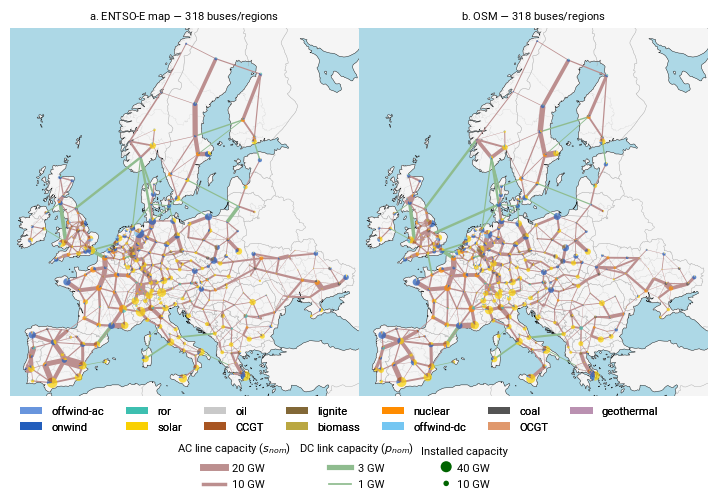

In [221]:
minx, miny, maxx, maxy = nuts_results.geometry.total_bounds
extent = [minx-1, maxx+0.5, miny-0.5, maxy-5.5]

linewidth_factor = 1e3*4
linkwidth_factor = 1e2*8
bus_size_factor = 1e5

def mwh_to_twh_formatter(x, pos):
    return '{:.1f}'.format(x * 1e-6)

crs = ccrs.Mercator()
fontsize = 8

# Set up the plot with Equal Earth projection
fig, ax = plt.subplots(1, 2, figsize=(9, 5), subplot_kw={"projection": crs}, gridspec_kw={"wspace": 0, "hspace": 0})

# Plots
nuts_results.to_crs(crs.proj4_init).plot(ax=ax[0], color="whitesmoke", edgecolor="#ccc", linewidth=0.1)
n_results_gridkit.plot(ax=ax[0],
                       bus_sizes = optimal_capacity_gridkit/bus_size_factor,
                       line_widths=n_results_gridkit.lines.s_nom/linewidth_factor, link_widths=n_results_gridkit.links.p_nom/linkwidth_factor, color_geomap=True, bus_alpha=0.7)
ax[0].set_title('a. ENTSO-E map $-$ 318 buses/regions')

nuts_results.to_crs(crs.proj4_init).plot(ax=ax[1], color="whitesmoke", edgecolor="#ccc", linewidth=0.1)
n_results_osm.plot(
    ax=ax[1],bus_sizes = optimal_capacity_osm/bus_size_factor,
    line_widths=n_results_osm.lines.s_nom/linewidth_factor,
    link_widths=n_results_osm.links.p_nom/linkwidth_factor, 
    color_geomap=True, 
    bus_alpha=0.7)           
ax[1].set_title('b. OSM $-$ 318 buses/regions')

ax[0].set_extent(extent)
ax[1].set_extent(extent)

# change font size of titles
for i in range(2):
    ax[i].title.set_fontsize(fontsize)

sizes = [20, 10]
labels = [f"{s} GW" for s in sizes]
scale = 1e3 / linewidth_factor
sizes = [s * scale for s in sizes]

# Line capacity
legend_kw = dict(
    loc="lower left",
    bbox_to_anchor=(0+0.45,-0.28),
    frameon=False,
    labelspacing=0.6,
    handletextpad=0.6,
    title="AC line capacity ($s_{nom}$)",
)

add_legend_lines(
    ax[0],
    sizes,
    labels,
    patch_kw=dict(color="rosybrown"),
    legend_kw=legend_kw,
)

sizes = [3, 1]
labels = [f"{s} GW" for s in sizes]
scale = 1e3 / linkwidth_factor
sizes = [s * scale for s in sizes]

# Link capacity
legend_kw = dict(
    loc="lower left",
    bbox_to_anchor=(0.35+0.45,-0.28),
    frameon=False,
    labelspacing=0.6,
    handletextpad=0.6,
    title="DC link capacity ($p_{nom}$)",
)

add_legend_lines(
    ax[0],
    sizes,
    labels,
    patch_kw=dict(color="darkseagreen"),
    legend_kw=legend_kw,
)

legend_kw = dict(
    loc="lower left",
    bbox_to_anchor=(0.7+0.45, -0.28),
    labelspacing=0.6,
    handletextpad=-0.4,
    frameon=False,
    title = "Installed capacity"
)

# Circles

sizes = [40, 10]
labels = [f"{s} GW" for s in sizes]
sizes = [s / bus_size_factor * 1e3 for s in sizes]

add_legend_circles(
    ax[0],
    sizes,
    labels,
    # srid=n.srid,
    patch_kw=dict(facecolor="darkgreen"),
    legend_kw=legend_kw,
)

sizes = [1500, 500]
labels = [f"{s} GWh" for s in sizes]
scale = 1e3 / linewidth_factor
sizes = [s * scale for s in sizes]

colors = list(tech_colors_subset.values())
labels = list(tech_colors_subset.keys())

legend_kw = dict(
    loc="upper left",
    bbox_to_anchor=(0, 0),
    ncol=7,
    frameon=False,
)

add_legend_patches(ax[0], colors, labels, legend_kw=legend_kw)

plt.show()

fig.savefig(f"{parent_dir}/figures/fig_results_sidebyside_capacity.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

In [222]:
#in n_results_gridkit.links find the line where bus0 or bus1 is ES30
n_results_gridkit.links[(n_results_gridkit.links.bus0 == "GBN0") | (n_results_gridkit.links.bus1 == "GBN0")]

bus0          bus1     length  underground  \
Link                                                                          
5581                             GBM9          GBN0  206.93663          0.0   
5580                             GBM9          GBN0  206.93663          0.0   
GBN0 H2 Electrolysis             GBN0       GBN0 H2    0.00000          NaN   
GBN0 H2 Fuel Cell             GBN0 H2          GBN0    0.00000          NaN   
GBN0 battery charger             GBN0  GBN0 battery    0.00000          NaN   
GBN0 battery discharger  GBN0 battery          GBN0    0.00000          NaN   

                         under_construction  \
Link                                          
5581                                    0.0   
5580                                    0.0   
GBN0 H2 Electrolysis                    NaN   
GBN0 H2 Fuel Cell                       NaN   
GBN0 battery charger                    NaN   
GBN0 battery discharger                 NaN   

                                                                      tags  \
Link                                                                         
5581                     "MW"=>"None", "TSO"=>"None", "oid"=>"32527", "...   
5580                     "MW"=>"None", "TSO"=>"None", "oid"=>"32526", "...   
GBN0 H2 Electrolysis                                                         
GBN0 H2 Fuel Cell                                                            
GBN0 battery charger                                                         
GBN0 battery discharger                                                      

                                                                  geometry  \
Link                                                                         
5581                     LINESTRING(-4.94702447012386 55.0727948492206,...   
5580                     LINESTRING(-4.94689333475508 55.0726735779237,...   
GBN0 H2 Electrolysis                                                         
GBN0 H2 Fuel Cell                                                            
GBN0 battery charger                                                         
GBN0 battery discharger                                                      

                                    carrier  p_min_pu  p_nom  ...  \
Link                                                          ...   
5581                                     DC      -1.0  500.0  ...   
5580                                     DC      -1.0  250.0  ...   
GBN0 H2 Electrolysis        H2 electrolysis       0.0    0.0  ...   
GBN0 H2 Fuel Cell              H2 fuel cell       0.0    0.0  ...   
GBN0 battery charger        battery charger       0.0    0.0  ...   
GBN0 battery discharger  battery discharger       0.0    0.0  ...   

                         shut_down_cost  min_up_time  min_down_time  \
Link                                                                  
5581                                0.0            0              0   
5580                                0.0            0              0   
GBN0 H2 Electrolysis                0.0            0              0   
GBN0 H2 Fuel Cell                   0.0            0              0   
GBN0 battery charger                0.0            0              0   
GBN0 battery discharger             0.0            0              0   

                         up_time_before  down_time_before  ramp_limit_up  \
Link                                                                       
5581                                  1                 0            NaN   
5580                                  1                 0            NaN   
GBN0 H2 Electrolysis                  1                 0            NaN   
GBN0 H2 Fuel Cell                     1                 0            NaN   
GBN0 battery charger                  1                 0            NaN   
GBN0 battery discharger               1                 0            NaN   

                         ramp_limit_down  

#### Degree of networks

In [262]:
def pypsa_networkx(network):
    network = network.copy()
    import networkx as nx
    G = nx.Graph()

    # Add buses as nodes
    for i, bus in network.buses[network.buses.carrier == "AC"].iterrows():
        G.add_node(i, **bus.to_dict())

    # Add lines as edges
    for i, line in network.lines.iterrows():
        G.add_edge(line['bus0'], line['bus1'], **line.to_dict())

    # Add links as edges
    for i, link in network.links[network.links.p_nom > 0].iterrows():
        G.add_edge(link['bus0'], link['bus1'], **link.to_dict())

    if not network.transformers.empty:
        for i, transformer in network.transformers.iterrows():
            G.add_edge(transformer['bus0'], transformer['bus1'], **transformer.to_dict())

    return G

In [263]:
n_elec_gridkit_nuts3 = pypsa.Network("data/osm-for-pypsa-eur/entsoegridkit_nuts3/networks/elec_s_1009_ec_lv1.0_.nc")
n_elec_osm_nuts3 = pypsa.Network("data/osm-for-pypsa-eur/osm-prebuilt_nuts3/networks/elec_s_1009_ec_lv1.0_.nc")

INFO:pypsa.io:Imported network elec_s_1009_ec_lv1.0_.nc has buses, carriers, generators, global_constraints, lines, links, loads, shapes, storage_units, stores
INFO:pypsa.io:Imported network elec_s_1009_ec_lv1.0_.nc has buses, carriers, generators, global_constraints, lines, links, loads, shapes, storage_units, stores


In [264]:
G_elec_gridkit_nuts3 = pypsa_networkx(n_elec_gridkit_nuts3)
G_elec_osm_nuts3 = pypsa_networkx(n_elec_osm_nuts3)

In [265]:
G_base_gridkit = pypsa_networkx(n_base_gridkit)
G_base_osm = pypsa_networkx(n_base_osm)
G_results_gridkit = pypsa_networkx(n_results_gridkit)
G_results_osm = pypsa_networkx(n_results_osm)

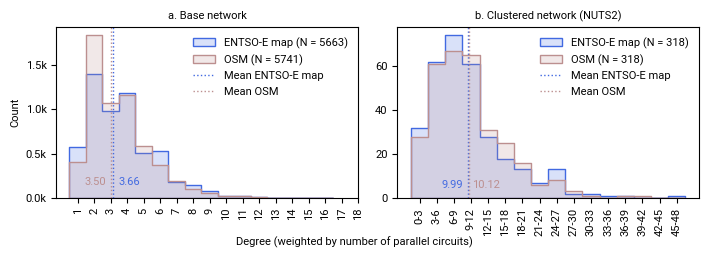

In [266]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx

fontsize = 8
title_fontsize = fontsize


# Compute degree centrality
degree_base_gridkit = dict(nx.degree(G_base_gridkit, weight="num_parallel"))
degree_base_osm = dict(nx.degree(G_base_osm, weight="num_parallel"))
degree_results_gridkit = dict(nx.degree(G_results_gridkit, weight="num_parallel"))
degree_results_osm = dict(nx.degree(G_results_osm, weight="num_parallel"))

elements_base = pd.concat([pd.Series(degree_base_gridkit), pd.Series(degree_base_osm)], axis=0).unique()
bin_edges_base = np.linspace(elements_base.min(), elements_base.max(), len(elements_base))

elements_results= pd.concat([pd.Series(degree_results_gridkit), pd.Series(degree_results_osm)], axis=0).unique()
step_results = 3
range_results = np.arange(np.floor(elements_results.min()), np.ceil(elements_results.max()), step_results)
bin_edges_results = np.concatenate([range_results, range_results.max()+ [step_results]])

bin_edges_results

elements = pd.concat([pd.Series(degree_base_gridkit), pd.Series(degree_base_osm), pd.Series(degree_results_gridkit), pd.Series(degree_results_osm)], axis=0).unique()

# Determine the bin edges based on the combined data range
bin_edges = np.linspace(elements.min(), elements.max(), len(elements))-0.5
bin_edges = np.linspace(0, 15, 16)

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.13, 2.5))

# Plot histograms with the same bins
sns.histplot(degree_base_gridkit, 
             bins=bin_edges_base, ax=ax1, color="royalblue", alpha=0.2, element="step", label="ENTSO-E map (N = 5663)", )
sns.histplot(degree_base_osm, 
             bins=bin_edges_base, ax=ax1, color="rosybrown", alpha=0.2, element="step", label="OSM (N = 5741)")
sns.histplot(degree_results_gridkit,
                bins=bin_edges_results, ax=ax2, color="royalblue", alpha=0.2, element="step", label="ENTSO-E map (N = 318)")
sns.histplot(degree_results_osm,
                bins=bin_edges_results, ax=ax2, color="rosybrown", alpha=0.2, element="step", label="OSM (N = 318)")

# add vertical line for mean
mean_base_gridkit = np.mean(list(degree_base_gridkit.values()))
mean_base_osm = np.mean(list(degree_base_osm.values()))
mean_results_gridkit = np.mean(list(degree_results_gridkit.values()))
mean_results_osm = np.mean(list(degree_results_osm.values()))

ax1.axvline(mean_base_gridkit, color='royalblue', linestyle=':', linewidth=1, label = "Mean ENTSO-E map")
ax1.text(mean_base_gridkit+0.3, 150, f'{mean_base_gridkit:.2f}', color='royalblue', fontsize=fontsize, ha='left')
ax1.axvline(mean_base_osm, color='rosybrown', linestyle=':', linewidth=1, label = "Mean OSM")
ax1.text(mean_base_osm-0.3, 150, f'{mean_base_osm:.2f}', color='rosybrown', fontsize=fontsize, ha='right')
ax2.axvline(mean_results_gridkit, color='royalblue', linestyle=':', linewidth=1, label = "Mean ENTSO-E map")
ax2.text(mean_results_gridkit-0.3*3, 4.5, f'{mean_results_gridkit:.2f}', color='royalblue', fontsize=fontsize, ha='right')
ax2.axvline(mean_results_osm, color='rosybrown', linestyle=':', linewidth=1, label = "Mean OSM")
ax2.text(mean_results_osm+0.3*2, 4.5, f'{mean_results_osm:.2f}', color='rosybrown', fontsize=fontsize, ha='left')



# add title to ax 1
ax1.set_title("a. Base network", fontsize=fontsize)
ax2.set_title("b. Clustered network (NUTS2)", fontsize=fontsize)

# Legends and stuff
# set fontsize
ax1.xaxis.label.set_fontsize(fontsize)
ax1.yaxis.label.set_fontsize(fontsize)
# ax1.set_xlabel("Degree (weighted by no. of circuits)")
ax1.set_ylabel("Count")
ax1.legend(title=None, loc='upper right', frameon=False, fontsize=fontsize, title_fontsize=title_fontsize)
ax1.set_xticks(range(int(elements_base.min()), int(elements_base.max())+2, 1))
# thousands formatter # but format 0 as 0, not 0.0k
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.1f}k'.format(x*1e-3))) 

# Offset ax1 labels and xticks
current_ticks = ax1.get_xticks()
current_labels = ax1.get_xticklabels()
new_ticks = current_ticks + 0.5
ax1.set_xticks(new_ticks)
ax1.set_xticklabels(current_labels, rotation=90)

ax2.xaxis.label.set_fontsize(fontsize)
ax2.yaxis.label.set_fontsize(fontsize)
# ax2.set_xlabel("Degree (weighted by no. of circuits)")
ax2.set_ylabel(None)
ax2.legend(title=None, loc='upper right', frameon=False, fontsize=fontsize, title_fontsize=title_fontsize)
ax2.set_xticks(range(int(bin_edges_results.min()), int(bin_edges_results.max()), step_results))

# Offset ax2 labels and xticks
tick_labels = [f'{i}-{i+step_results}' for i in ax2.get_xticks()] 
current_ticks = ax2.get_xticks()
new_ticks = current_ticks + step_results/2
ax2.set_xticks(new_ticks)
ax2.set_xticklabels(tick_labels, rotation=90)

# # Create common xlabel spanning over both ax1 and ax2
fig.text(0.5, 0.01, 'Degree (weighted by number of parallel circuits)', ha='center', fontsize=fontsize)


# Adjust layout and display the plot
plt.tight_layout()
fig.savefig(f"{parent_dir}/figures/fig_hist_degree_nuts2.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()


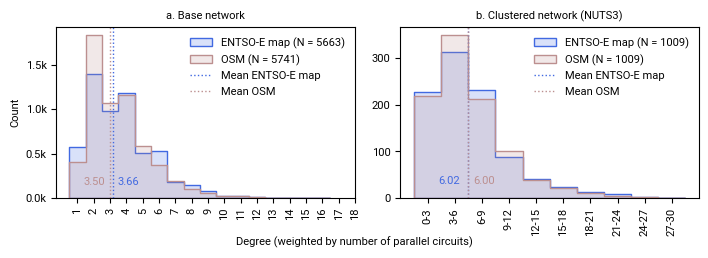

In [267]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx

fontsize = 8
title_fontsize = fontsize


# Compute degree centrality
degree_base_gridkit = dict(nx.degree(G_base_gridkit, weight="num_parallel"))
degree_base_osm = dict(nx.degree(G_base_osm, weight="num_parallel"))
degree_results_gridkit = dict(nx.degree(G_elec_gridkit_nuts3, weight="num_parallel"))
degree_results_osm = dict(nx.degree(G_elec_osm_nuts3, weight="num_parallel"))

elements_base = pd.concat([pd.Series(degree_base_gridkit), pd.Series(degree_base_osm)], axis=0).unique()
bin_edges_base = np.linspace(elements_base.min(), elements_base.max(), len(elements_base))

elements_results= pd.concat([pd.Series(degree_results_gridkit), pd.Series(degree_results_osm)], axis=0).unique()
step_results = 3
range_results = np.arange(np.floor(elements_results.min()), np.ceil(elements_results.max()), step_results)
bin_edges_results = np.concatenate([range_results, range_results.max()+ [step_results]])

bin_edges_results

elements = pd.concat([pd.Series(degree_base_gridkit), pd.Series(degree_base_osm), pd.Series(degree_results_gridkit), pd.Series(degree_results_osm)], axis=0).unique()

# Determine the bin edges based on the combined data range
bin_edges = np.linspace(elements.min(), elements.max(), len(elements))-0.5
bin_edges = np.linspace(0, 15, 16)

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.13, 2.5))

# Plot histograms with the same bins
sns.histplot(degree_base_gridkit, 
             bins=bin_edges_base, ax=ax1, color="royalblue", alpha=0.2, element="step", label="ENTSO-E map (N = 5663)", )
sns.histplot(degree_base_osm, 
             bins=bin_edges_base, ax=ax1, color="rosybrown", alpha=0.2, element="step", label="OSM (N = 5741)")
sns.histplot(degree_results_gridkit,
                bins=bin_edges_results, ax=ax2, color="royalblue", alpha=0.2, element="step", label="ENTSO-E map (N = 1009)")
sns.histplot(degree_results_osm,
                bins=bin_edges_results, ax=ax2, color="rosybrown", alpha=0.2, element="step", label="OSM (N = 1009)")

# add vertical line for mean
mean_base_gridkit = np.mean(list(degree_base_gridkit.values()))
mean_base_osm = np.mean(list(degree_base_osm.values()))
mean_results_gridkit = np.mean(list(degree_results_gridkit.values()))
mean_results_osm = np.mean(list(degree_results_osm.values()))

ax1.axvline(mean_base_gridkit, color='royalblue', linestyle=':', linewidth=1, label = "Mean ENTSO-E map")
ax1.text(mean_base_gridkit+0.3, 150, f'{mean_base_gridkit:.2f}', color='royalblue', fontsize=fontsize, ha='left')
ax1.axvline(mean_base_osm, color='rosybrown', linestyle=':', linewidth=1, label = "Mean OSM")
ax1.text(mean_base_osm-0.3, 150, f'{mean_base_osm:.2f}', color='rosybrown', fontsize=fontsize, ha='right')
ax2.axvline(mean_results_gridkit, color='royalblue', linestyle=':', linewidth=1, label = "Mean ENTSO-E map")
ax2.text(mean_results_gridkit-0.3*3, 30, f'{mean_results_gridkit:.2f}', color='royalblue', fontsize=fontsize, ha='right')
ax2.axvline(mean_results_osm, color='rosybrown', linestyle=':', linewidth=1, label = "Mean OSM")
ax2.text(mean_results_osm+0.3*2, 30, f'{mean_results_osm:.2f}', color='rosybrown', fontsize=fontsize, ha='left')



# add title to ax 1
ax1.set_title("a. Base network", fontsize=fontsize)
ax2.set_title("b. Clustered network (NUTS3)", fontsize=fontsize)

# Legends and stuff
# set fontsize
ax1.xaxis.label.set_fontsize(fontsize)
ax1.yaxis.label.set_fontsize(fontsize)
# ax1.set_xlabel("Degree (weighted by no. of circuits)")
ax1.set_ylabel("Count")
ax1.legend(title=None, loc='upper right', frameon=False, fontsize=fontsize, title_fontsize=title_fontsize)
ax1.set_xticks(range(int(elements_base.min()), int(elements_base.max())+2, 1))
# thousands formatter # but format 0 as 0, not 0.0k
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.1f}k'.format(x*1e-3))) 

# Offset ax1 labels and xticks
current_ticks = ax1.get_xticks()
current_labels = ax1.get_xticklabels()
new_ticks = current_ticks + 0.5
ax1.set_xticks(new_ticks)
ax1.set_xticklabels(current_labels, rotation=90)

ax2.xaxis.label.set_fontsize(fontsize)
ax2.yaxis.label.set_fontsize(fontsize)
# ax2.set_xlabel("Degree (weighted by no. of circuits)")
ax2.set_ylabel(None)
ax2.legend(title=None, loc='upper right', frameon=False, fontsize=fontsize, title_fontsize=title_fontsize)
ax2.set_xticks(range(int(bin_edges_results.min()), int(bin_edges_results.max()), step_results))

# Offset ax2 labels and xticks
tick_labels = [f'{i}-{i+step_results}' for i in ax2.get_xticks()] 
current_ticks = ax2.get_xticks()
new_ticks = current_ticks + step_results/2
ax2.set_xticks(new_ticks)
ax2.set_xticklabels(tick_labels, rotation=90)

# # Create common xlabel spanning over both ax1 and ax2
fig.text(0.5, 0.01, 'Degree (weighted by number of parallel circuits)', ha='center', fontsize=fontsize)


# Adjust layout and display the plot
plt.tight_layout()
fig.savefig(f"{parent_dir}/figures/fig_hist_degree_nuts3.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()


In [268]:
df_degree_base_gridkit = pd.DataFrame(degree_base_gridkit, index=[0]).T.reset_index()
df_degree_base_gridkit.columns = ["bus", "degree"]
df_degree_base_gridkit = df_degree_base_gridkit.groupby("degree").size()

df_degree_base_osm = pd.DataFrame(degree_base_osm, index=[0]).T.reset_index()
df_degree_base_osm.columns = ["bus", "degree"]
df_degree_base_osm = df_degree_base_osm.groupby("degree").size()

df_degree_results_gridkit = pd.DataFrame(degree_results_gridkit, index=[0]).T.reset_index()
df_degree_results_gridkit.columns = ["bus", "degree"]
df_degree_results_gridkit["degree_group"] = pd.cut(df_degree_results_gridkit.degree, bins=bin_edges_results, right=False)
df_degree_results_gridkit = df_degree_results_gridkit.groupby("degree_group").size()

df_degree_results_osm = pd.DataFrame(degree_results_osm, index=[0]).T.reset_index()  
df_degree_results_osm.columns = ["bus", "degree"]
df_degree_results_osm["degree_group"] = pd.cut(df_degree_results_osm.degree, bins=bin_edges_results, right=False)
df_degree_results_osm = df_degree_results_osm.groupby("degree_group").size()

df_degree_nuts3_base_gridkit = pd.DataFrame(degree_base_gridkit, index=[0]).T.reset_index()
df_degree_nuts3_base_gridkit.columns = ["bus", "degree"]
df_degree_nuts3_base_gridkit["degree_group"] = pd.cut(df_degree_nuts3_base_gridkit.degree, bins=bin_edges_base, right=False)
df_degree_nuts3_base_gridkit = df_degree_nuts3_base_gridkit.groupby("degree_group").size()

df_degree_nuts3_base_osm = pd.DataFrame(degree_base_osm, index=[0]).T.reset_index()
df_degree_nuts3_base_osm.columns = ["bus", "degree"]
df_degree_nuts3_base_osm["degree_group"] = pd.cut(df_degree_nuts3_base_osm.degree, bins=bin_edges_base, right=False)
df_degree_nuts3_base_osm = df_degree_nuts3_base_osm.groupby("degree_group").size()

/tmp/ipykernel_25530/283168663.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_25530/283168663.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_25530/283168663.py:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_25530/283168663.py:27: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=F

In [269]:
# pearson correlation df_degree_base_gridkit and df_degree_base_osm
print(f"PCC base gridkit and base osm: {df_degree_base_gridkit.corr(df_degree_base_osm, method='pearson')}")
print(f"PCC results gridkit and results osm: {df_degree_results_gridkit.corr(df_degree_results_osm, method='pearson')}")
print(f"PCC NUTS3 base gridkit and base osm: {df_degree_nuts3_base_gridkit.corr(df_degree_nuts3_base_osm, method='pearson')}")

PCC base gridkit and base osm: 0.9765432863351077
PCC results gridkit and results osm: 0.9936970594512281
PCC NUTS3 base gridkit and base osm: 0.977789667984215


/home/bobby/miniconda3/envs/pypsa-eur-dev/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

/home/bobby/miniconda3/envs/pypsa-eur-dev/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



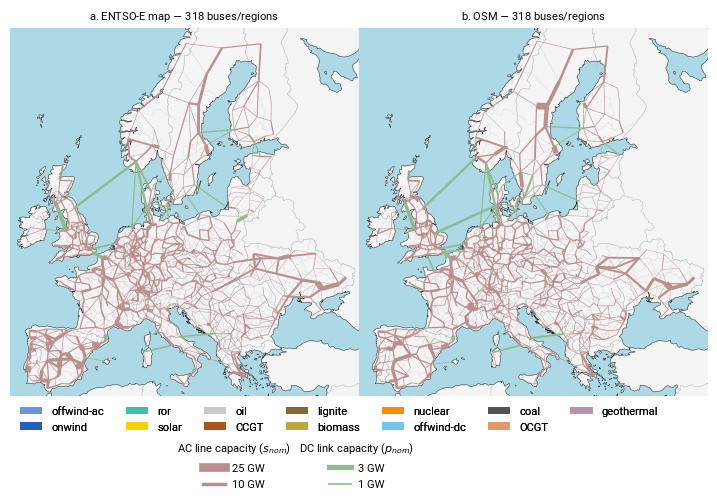

In [270]:
minx, miny, maxx, maxy = nuts_results.geometry.total_bounds
extent = [minx-1, maxx+0.5, miny-0.5, maxy-5.5]

linewidth_factor = 1e3*4
linkwidth_factor = 1e2*8
bus_size_factor = 1e5

def mwh_to_twh_formatter(x, pos):
    return '{:.1f}'.format(x * 1e-6)

crs = ccrs.Mercator()
fontsize = 8

# Set up the plot with Equal Earth projection
fig, ax = plt.subplots(1, 2, figsize=(9, 5), subplot_kw={"projection": crs}, gridspec_kw={"wspace": 0, "hspace": 0})

# Plots
nuts_results.to_crs(crs.proj4_init).plot(ax=ax[0], color="whitesmoke", edgecolor="#ccc", linewidth=0.1)
n_elec_gridkit_nuts3.plot(ax=ax[0],
                       bus_sizes = 0,
                       line_widths=n_elec_gridkit_nuts3.lines.s_nom/linewidth_factor, link_widths=n_elec_gridkit_nuts3.links.p_nom/linkwidth_factor, color_geomap=True, bus_alpha=0.7)
ax[0].set_title('a. ENTSO-E map $-$ 318 buses/regions')

nuts_results.to_crs(crs.proj4_init).plot(ax=ax[1], color="whitesmoke", edgecolor="#ccc", linewidth=0.1)
n_elec_osm_nuts3.plot(
    ax=ax[1],bus_sizes = 0,
    line_widths=n_elec_osm_nuts3.lines.s_nom/linewidth_factor,
    link_widths=n_elec_osm_nuts3.links.p_nom/linkwidth_factor, 
    color_geomap=True, 
    bus_alpha=0.7)           
ax[1].set_title('b. OSM $-$ 318 buses/regions')

ax[0].set_extent(extent)
ax[1].set_extent(extent)

# change font size of titles
for i in range(2):
    ax[i].title.set_fontsize(fontsize)

sizes = [25, 10]
labels = [f"{s} GW" for s in sizes]
scale = 1e3 / linewidth_factor
sizes = [s * scale for s in sizes]

# Line capacity
legend_kw = dict(
    loc="lower left",
    bbox_to_anchor=(0+0.45,-0.28),
    frameon=False,
    labelspacing=0.6,
    handletextpad=0.6,
    title="AC line capacity ($s_{nom}$)",
)

add_legend_lines(
    ax[0],
    sizes,
    labels,
    patch_kw=dict(color="rosybrown"),
    legend_kw=legend_kw,
)

sizes = [3, 1]
labels = [f"{s} GW" for s in sizes]
scale = 1e3 / linkwidth_factor
sizes = [s * scale for s in sizes]

# Link capacity
legend_kw = dict(
    loc="lower left",
    bbox_to_anchor=(0.35+0.45,-0.28),
    frameon=False,
    labelspacing=0.6,
    handletextpad=0.6,
    title="DC link capacity ($p_{nom}$)",
)

add_legend_lines(
    ax[0],
    sizes,
    labels,
    patch_kw=dict(color="darkseagreen"),
    legend_kw=legend_kw,
)

sizes = [1500, 500]
labels = [f"{s} GWh" for s in sizes]
scale = 1e3 / linewidth_factor
sizes = [s * scale for s in sizes]

colors = list(tech_colors_subset.values())
labels = list(tech_colors_subset.keys())

legend_kw = dict(
    loc="upper left",
    bbox_to_anchor=(0, 0),
    ncol=7,
    frameon=False,
)

add_legend_patches(ax[0], colors, labels, legend_kw=legend_kw)

plt.show()

# fig.savefig(f"{parent_dir}/figures/fig_results_sidebyside_capacity.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

### Crossregional capacity

In [271]:
# Snippets
n_results_osm.generators.marginal_cost
opt_cap_gridkit = n_results_gridkit.statistics.optimal_capacity(comps=["Generator"], groupby=["carrier", "bus"]).droplevel("component")
opt_cap_osm = n_results_osm.statistics.optimal_capacity(comps=["Generator"], groupby=["carrier", "bus"]).droplevel("component")
delta_opt_cap =opt_cap_osm-opt_cap_gridkit
delta_opt_cap.xs("solar", level="carrier").sort_values(ascending=True)


bus
GBJ4     -8643.86229
AT33     -8518.94017
ITC1     -7458.60176
CH01     -6400.87041
ES52     -6206.86659
             ...    
CH02      6959.87885
CZ01             NaN
MD3139           NaN
MD3142           NaN
MD3246           NaN
Name: p_nom_opt, Length: 315, dtype: float64

### Comparison with 50Hertz static grid model

In [48]:
# Load 50Hertz model from xlsx
df_sgm = pd.read_excel("data/Statisches Netzmodell - Datentabelle 2023.xlsx", sheet_name="Lines", header=[0,1])
df_sgm = df_sgm.droplevel(0, axis=1)

In [49]:
df_tielines = pd.read_excel("data/Statisches Netzmodell - Datentabelle 2023.xlsx", sheet_name="Tielines", header=[0,1])
df_tielines = df_tielines.droplevel(0, axis=1)

In [50]:
df_tielines = df_tielines[[
    "NE_name",
    "EIC_Code",
    "Unnamed: 5_level_1",
    "Unnamed: 6_level_1",
    "Unnamed: 10_level_1",
    "Unnamed: 11_level_1",
    "Fixed",
    "Length_(km)",
    "Voltage_level [kV]",
    "Resistance_R(Ω)",
    "Reactance_X(Ω)",
]]

df_tielines = df_tielines.rename(columns={
    "NE_name": "line",
    "EIC_Code": "eic_code",
    "Unnamed: 5_level_1": "lon0",
    "Unnamed: 6_level_1": "lat0",
    "Unnamed: 10_level_1": "lon1",
    "Unnamed: 11_level_1": "lat1",
    "Fixed": "i_nom",
    "Length_(km)": "length",
    "Voltage_level [kV]": "v_nom",
    "Resistance_R(Ω)": "r_ohm",
    "Reactance_X(Ω)": "x_ohm",
})

In [51]:
df_tielines.dropna(inplace=True)

In [52]:
df_sgm = df_sgm[[
    "NE_name",
    "EIC_Code",
    "Unnamed: 5_level_1",
    "Unnamed: 6_level_1",
    "Unnamed: 9_level_1",
    "Unnamed: 10_level_1",
    "Fixed",
    "Length_(km)",
    "Voltage_level(kV)",
    "Resistance_R(Ω)",
    "Reactance_X(Ω)",
]]

df_sgm = df_sgm.rename(columns={
    "NE_name": "line",
    "EIC_Code": "eic_code",
    "Unnamed: 5_level_1": "lon0",
    "Unnamed: 6_level_1": "lat0",
    "Unnamed: 9_level_1": "lon1",
    "Unnamed: 10_level_1": "lat1",
    "Fixed": "i_nom",
    "Length_(km)": "length",
    "Voltage_level(kV)": "v_nom",
    "Resistance_R(Ω)": "r_ohm",
    "Reactance_X(Ω)": "x_ohm",
})

In [53]:
df_sgm = pd.concat([df_sgm, df_tielines], axis=0)
df_sgm

line          eic_code     lon0     lat0  \
0            Eula - Röhrsdorf 203  11TD8L203------C  12.5171  51.1565   
1           Röhrsdorf - Weida 207  11TD8L207------H  12.8110  50.8590   
2                Eula - Weida 208  11TD8L208------9  12.5171  51.1565   
3         Bentwisch - Güstrow 275  11TD8L275------7  12.2140  54.0998   
4          Wuhlheide - Thyrow 291  11TD8L291------L  13.5059  52.4741   
..                            ...               ...      ...      ...   
15        Altenfeld - Redwitz 460  11T-D2-D8-001015  10.9903  50.5742   
16  Helmstedt - Wolmirstedt 491-1  11T-D2-D8-000205  11.0121  52.1907   
17  Helmstedt - Wolmirstedt 492-2  11T-D2-D8-000213  11.0121  52.1907   
18      Redwitz - Remptendorf 413  11T-D2-D8-00050X  11.4707  50.4300   
19      Redwitz - Remptendorf 414  11T-D2-D8-00051V  11.4707  50.4300   

       lon1     lat1  i_nom  length  v_nom    r_ohm      x_ohm  
0   12.8110  50.8590    790  51.511    220  4.09370  18.349000  
1   12.0452  50.7805    790  98.324    220  7.58950  31.888000  
2   12.0452  50.7805   1070  67.550    220  5.05370  19.541000  
3   12.1860  53.8160   1200  41.418    220  1.90900  12.055000  
4   13.3049  52.2309    960  38.882    220  2.96720  11.191000  
..      ...      ...    ...     ...    ...      ...        ...  
15  11.0309  50.3598   3600  25.800    380  0.94244  14.166687  
16  11.6390  52.2693   3600  46.900    380  0.87100   6.527000  
17  11.6390  52.2693   3600  46.900    380  0.87000   6.527000  
18  11.6465  50.5336   3600  18.400    380  0.73100   7.216000  
19  11.6465  50.5336   3600  18.400    380  0.73100   7.216000  

[157 rows x 11 columns]

In [54]:
df_sgm["x_normed"] = df_sgm["x_ohm"] / df_sgm["length"]
df_sgm["r_normed"] = df_sgm["r_ohm"] / df_sgm["length"]

In [55]:
df_sgm["i_nom"] = df_sgm["i_nom"] / 1e3 # convert to kA

In [56]:
# Create gdf and linestrings
df_sgm["geometry"] = df_sgm.apply(lambda row: LineString([(row["lon0"], row["lat0"]), (row["lon1"], row["lat1"])]) , axis=1)
df_sgm = gpd.GeoDataFrame(df_sgm, geometry="geometry", crs="EPSG:4326")

In [57]:
# Create convex hull of df_sgm polygon
sgm_hull = df_sgm.union_all().convex_hull
# Add buffer
sgm_hull = sgm_hull.buffer(0.1)
sgm_hull = gpd.GeoSeries(sgm_hull, crs="EPSG:4326")
sgm_hull = gpd.GeoDataFrame(geometry=sgm_hull, crs="EPSG:4326")

In [58]:
lines_osm_50hertz = lines_osm.copy()
# inside the hull
lines_osm_50hertz = gpd.sjoin(lines_osm_50hertz, sgm_hull, how="inner", predicate="within")
drop_lines = [
    "35336024","1089763367","174267716","174267699","39464534","28344088-1","129175345", "30269495","30601745","30269495","123105300-1",
    "123105296-1","23031561","29252734","23707819","28763712","984496577","24262688","231006629","232071584","29252732","574577691",
    "123105296-1","953757609","23704625","37231119-1","953757607","37231119-1","24262688","23031561","953757611","231006629",
    "23031561","953757611","231006638","953757607","881636323","45737386","881636336","338361032","59295320-1","192797014",
    "844516310","186397898","62251376","1017370651","48172206","157247391","58870477","23707819-a", "1185493736", "389911710", 
    "157332863", "168715556", "24968723", "126998360", "128975976", "296751942", "574218866",  "61649945", "953738998", "907014441",
    "234156601",
]
lines_osm_50hertz = lines_osm_50hertz[~lines_osm_50hertz.index.isin(drop_lines)]

In [59]:
lines_osm_50hertz["i_nom"] = lines_osm_50hertz["s_nom"]/np.sqrt(3)/lines_osm_50hertz["v_nom"]/lines_osm_50hertz["num_parallel"]

In [60]:
lines_osm_50hertz["i_nom"].unique()

array([1.29, 2.58, 2.58])

In [61]:
df_sgm["i_nom"].unique()

array([0.79 , 1.07 , 1.2  , 0.96 , 0.9  , 1.6  , 1.29 , 2.72 , 2.7  ,
       2.52 , 2.37 , 3.6  , 2.4  , 2.5  , 2.28 , 2.04 , 2.504, 2.   ,
       0.8  , 1.62 , 1.66 , 2.58 , 4.   , 2.1  ])

In [62]:
buses_osm = n_base_osm.buses.copy()
lines_osm_50hertz_simpl = lines_osm_50hertz.copy()[["bus0", "bus1", "v_nom", "i_nom", "num_parallel", "length", "s_nom", "r", "x", "r_pu", "x_pu"]]
# Calculate x and r per line (multiplied by num_parallel) (per circuit)
lines_osm_50hertz_simpl["r"] = lines_osm_50hertz_simpl["r"] * lines_osm_50hertz_simpl["num_parallel"]
lines_osm_50hertz_simpl["x"] = lines_osm_50hertz_simpl["x"] * lines_osm_50hertz_simpl["num_parallel"]
# Convert r and x to per circuit
lines_osm_50hertz_simpl = lines_osm_50hertz_simpl.rename(columns={"r": "r_ohm", "x": "x_ohm", "r_pu": "r_pu", "x_pu": "x_pu"})
lines_osm_50hertz_simpl = lines_osm_50hertz_simpl.merge(buses_osm[["x", "y"]], left_on="bus0", right_index=True)
lines_osm_50hertz_simpl = lines_osm_50hertz_simpl.merge(buses_osm[["x", "y"]], left_on="bus1", right_index=True)
lines_osm_50hertz_simpl = lines_osm_50hertz_simpl.rename(columns={"x_x": "x0", "y_x": "y0", "x_y": "x1", "y_y": "y1"})
# Create linestring
lines_osm_50hertz_simpl["geometry"] = lines_osm_50hertz_simpl.apply(lambda row: LineString([(row["x0"], row["y0"]), (row["x1"], row["y1"])]) , axis=1)
lines_osm_50hertz_simpl = gpd.GeoDataFrame(lines_osm_50hertz_simpl, geometry="geometry", crs="EPSG:4326")

In [63]:
lines_gridkit = n_base_gridkit.lines.copy()
lines_gridkit = lines_gridkit[lines_gridkit.geometry != ""]
lines_gridkit.geometry = lines_gridkit.geometry.apply(wkt.loads)
lines_gridkit = gpd.GeoDataFrame(lines_gridkit, geometry="geometry", crs="EPSG:4326")
lines_gridkit_50hertz = gpd.sjoin(lines_gridkit, sgm_hull, how="inner", predicate="within")
drop_lines = ["11306", "11307", "11308", "14997", "2406", "10058", "11828", "11827", "6461", "10056", "12741", "11274", "8567",
              "2405", "10055", "12740", "4728", "10033", "4779", "8559", "14218", "12922", "4789", "14219", "12921", "3576_2", "3576",
              "11289", "2424", "596", "4791","4713", "4712", "4711", "8404"]
lines_gridkit_50hertz = lines_gridkit_50hertz[~lines_gridkit_50hertz.index.isin(drop_lines)]
# Add line "14762" back from lines_gridkit to lines_gridkit_50hertz
lines_gridkit_50hertz = pd.concat([lines_gridkit_50hertz, lines_gridkit.loc[["14762"]]], axis=0)

In [64]:
buses_gridkit = n_base_gridkit.buses.copy()
lines_gridkit_50hertz_simpl = lines_gridkit_50hertz.copy()[["bus0", "bus1", "v_nom", "num_parallel", "length", "s_nom"]]
lines_gridkit_50hertz_simpl =  lines_gridkit_50hertz_simpl.merge(buses_gridkit[["x", "y"]], left_on="bus0", right_index=True)
lines_gridkit_50hertz_simpl = lines_gridkit_50hertz_simpl.merge(buses_gridkit[["x", "y"]], left_on="bus1", right_index=True)
lines_gridkit_50hertz_simpl = lines_gridkit_50hertz_simpl.rename(columns={"x_x": "x0", "y_x": "y0", "x_y": "x1", "y_y": "y1"})
# Create linestring
lines_gridkit_50hertz_simpl["geometry"] = lines_gridkit_50hertz_simpl.apply(lambda row: LineString([(row["x0"], row["y0"]), (row["x1"], row["y1"])]) , axis=1)
lines_gridkit_50hertz_simpl = gpd.GeoDataFrame(lines_gridkit_50hertz_simpl, geometry="geometry", crs="EPSG:4326")

/tmp/ipykernel_23943/221891639.py:23: UserWarning:

Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




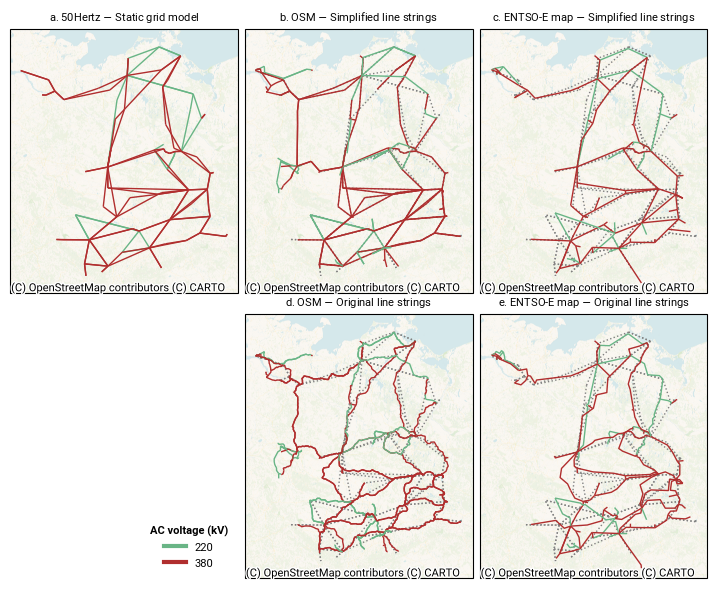

In [65]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

# Colors and colormap
sgm_ac_labels = ["220", "380"]
sgm_ac_colors = ['#69b586', '#b02e2e']
sgm_ac_cmap = mcolors.ListedColormap(sgm_ac_colors)

# Settings
zoomlevel = 10
crs = ccrs.Mercator()
fontsize = 8
title_fontsize = 8

# # OSM tiles
# osm_tiles = cimgt.OSM()

# Set up the plot with Equal Earth projection
fig, ax = plt.subplots(2, 3, figsize=(9, 7.3), subplot_kw={"projection": crs}, gridspec_kw={"wspace": 0.03, "hspace": 0.03})

# Calculate the extent of the country shapes data
minx, miny, maxx, maxy = sgm_hull.buffer(0.2).total_bounds
extent = [minx, maxx, miny, maxy]

# Set limits to zoom into the map based on the extent of country shapes
for i in range(2):
    for j in range(3):
        ax[i][j].set_extent(extent)

# # Add OSM tiles to each subplot
# for i in range(2):
#     for j in range(1,3):
#         ax[i][j].add_image(osm_tiles, 12)

df_sgm.to_crs(crs.proj4_init).plot(ax=ax[0][0], column='v_nom', cmap=sgm_ac_cmap, linewidth=1)
df_sgm.to_crs(crs.proj4_init).plot(ax=ax[0][1], color="grey", linewidth=1, linestyle=":")
# dashed line instead
df_sgm.to_crs(crs.proj4_init).plot(ax=ax[0][2], color="grey", linewidth=1, linestyle=":")
df_sgm.to_crs(crs.proj4_init).plot(ax=ax[1][1], color="grey", linewidth=1, linestyle=":")
df_sgm.to_crs(crs.proj4_init).plot(ax=ax[1][2], color="grey", linewidth=1, linestyle=":")

lines_osm_50hertz.to_crs(crs.proj4_init).plot(ax=ax[1][1], column='v_nom', cmap=sgm_ac_cmap, linewidth=1)
lines_osm_50hertz_simpl.to_crs(crs.proj4_init).plot(ax=ax[0][1], column='v_nom', cmap=sgm_ac_cmap, linewidth=1)

lines_gridkit_50hertz.to_crs(crs.proj4_init).plot(ax=ax[1][2], column='v_nom', cmap=sgm_ac_cmap, linewidth=1)
lines_gridkit_50hertz_simpl.to_crs(crs.proj4_init).plot(ax=ax[0][2], column='v_nom', cmap=sgm_ac_cmap, linewidth=1)

# Set the border of subplot [1][0] to be invisible
for spine in ax[1][0].spines.values():
    spine.set_edgecolor('none')  # Makes the spines invisible

# Title for each subplot
ax[0][0].set_title("a. 50Hertz $-$ Static grid model", fontsize=fontsize)
ax[0][1].set_title("b. OSM $-$ Simplified line strings", fontsize=fontsize)
ax[0][2].set_title("c. ENTSO-E map $-$ Simplified line strings", fontsize=fontsize)
ax[1][1].set_title("d. OSM $-$ Original line strings", fontsize=fontsize)
ax[1][2].set_title("e. ENTSO-E map $-$ Original line strings", fontsize=fontsize)

### Legend
# Plot AC voltage levels data with legend
ac_legend_elements = [Line2D([0], [0], color=color, lw=3, label=label)
                      for color, label in zip(sgm_ac_colors, sgm_ac_labels)]
for color, label in zip(sgm_ac_colors, sgm_ac_labels):
    ax[1][0].plot([], [], color=color, label=label)  # This line adds a dummy plot to associate with the label

# Add both legends to the plot
ac_legend = ax[1][0].legend(handles=ac_legend_elements, title="AC voltage (kV)", loc='lower right', fontsize=fontsize, title_fontsize=title_fontsize)
ac_legend.get_frame().set_facecolor('none')
ac_legend.get_frame().set_edgecolor('none')

ac_legend.get_title().set_fontweight('bold')

# Add OSM tiles to both subplots
cx.add_basemap(ax[0][0], crs=crs, source=cx.providers.CartoDB.VoyagerNoLabels, zoom = zoomlevel)
cx.add_basemap(ax[0][1], crs=crs, source=cx.providers.CartoDB.VoyagerNoLabels, zoom = zoomlevel)
cx.add_basemap(ax[0][2], crs=crs, source=cx.providers.CartoDB.VoyagerNoLabels, zoom = zoomlevel)
cx.add_basemap(ax[1][1], crs=crs, source=cx.providers.CartoDB.VoyagerNoLabels, zoom = zoomlevel)
cx.add_basemap(ax[1][2], crs=crs, source=cx.providers.CartoDB.VoyagerNoLabels, zoom = zoomlevel)



plt.show()

# # Save the figure
# fig.savefig(f"{parent_dir}/figures/fig_osm_vs_50Hertz_sgm.pdf", format="pdf", bbox_inches="tight", pad_inches=0)


In [67]:
# remove all numeric strings in "line column" and save only the alphabetic strings under "line_id" and remove trailing space at end of string
df_sgm["line_id"] = df_sgm["line"].str.extract(r'(\D+)')
df_sgm["line_id"] = df_sgm["line_id"].str.rstrip()
df_sgm["line_id"] = df_sgm["line_id"].str.rstrip()

In [68]:
df_sgm_grouped = df_sgm.groupby(["line_id", "v_nom"]).agg({
    "i_nom": "mean",
    "length": "mean",
    "r_ohm": "mean",
    "x_ohm": "mean",
    "line_id": "count",  # Count the number of rows in each group
    "lon0": "mean",
    "lat0": "mean",
    "lon1": "mean",
    "lat1": "mean",
    "geometry": "first",
})

# Rename the 'line_id' column to 'count'
df_sgm_grouped = df_sgm_grouped.rename(columns={"line_id": "count"})

# Reset the index if needed (optional)
df_sgm_grouped = gpd.GeoDataFrame(df_sgm_grouped, geometry="geometry", crs="EPSG:4326")

In [69]:
df_sgm_grouped.reset_index(inplace=True)
df_sgm_grouped.set_index("line_id", inplace=True)

In [70]:
# filter df_sgm_grouped for index only in vlaues of map_lines
map_50hertz = df_sgm_grouped.reset_index().explore(color = "red", popup = True)
df_sgm_grouped.reset_index().explore(color = "orange", popup = True, m = map_50hertz)
lines_osm_50hertz_simpl.explore(color = "blue", m = map_50hertz, popup = True)
map_50hertz

In [294]:
# sgm same lines, simplify to one and add in count
# need to divide all r and x by two
df_sgm_grouped.loc["Dresden/Süd - Freiberg/Nord", "count"] = 2
df_sgm_grouped.loc["Freiberg/Nord - Röhrsdorf", "count"] = 2
df_sgm_grouped = df_sgm_grouped.drop("Dresden/Süd - Röhrsdorf", errors="ignore")

df_sgm_grouped.loc["Lubmin - Altentreptow/Nord", "count"] = 2
df_sgm_grouped.loc["Altentreptow/Nord - Altentreptow/Süd", "count"] = 2
df_sgm_grouped = df_sgm_grouped.drop("Lubmin - Altentreptow/Süd", errors="ignore")

df_sgm_grouped.loc["Altentreptow/Süd - Malchow", "count"] = 2
df_sgm_grouped.loc["Neuenhagen - Malchow", "count"] = 2
df_sgm_grouped = df_sgm_grouped.drop("Gransee - Neuenhagen", errors="ignore")
df_sgm_grouped = df_sgm_grouped.drop("Altentreptow/Süd - Gransee", errors="ignore")

df_sgm_grouped.loc["Vierraden - Pasewalk", "count"] = 2
df_sgm_grouped.loc["Neuenhagen - Vierraden", "count"] = 2
df_sgm_grouped = df_sgm_grouped.drop("Bertikow - Neuenhagen", errors="ignore")
df_sgm_grouped = df_sgm_grouped.drop("Bertikow - Pasewalk", errors="ignore")

df_sgm_grouped.loc["Klostermansfeld - Lauchstädt", "count"] = 2
df_sgm_grouped.loc["Wolmirstedt - Klostermansfeld", "count"] = 2
df_sgm_grouped = df_sgm_grouped.drop("Lauchstädt - Wolmirstedt", errors="ignore")

df_sgm_grouped.loc["Remptendorf - Weida", "count"] = 2
df_sgm_grouped.loc["Röhrsdorf - Weida", "count"] = 2
df_sgm_grouped = df_sgm_grouped.drop("Remptendorf - Röhrsdorf", errors="ignore")

df_sgm_grouped.loc["Altdöbern - Streumen", "count"] = 2
df_sgm_grouped.loc["Preilack - Altdöbern", "count"] = 2
df_sgm_grouped = df_sgm_grouped.drop("Preilack - Streumen", errors="ignore")


df_sgm_grouped.loc["Förderstedt - Jessen/Nord", "count"] = 2
df_sgm_grouped.loc["Schönewalde - Jessen/Nord", "count"] = 2
df_sgm_grouped.loc["Ragow - Schönewalde", "count"] = 2
df_sgm_grouped = df_sgm_grouped.drop("Ragow - Förderstedt", errors="ignore")

df_sgm_grouped.loc["Jessen/Nord - Lauchstädt", "count"] = 2
df_sgm_grouped = df_sgm_grouped.drop("Marke - Lauchstädt", errors="ignore")
df_sgm_grouped = df_sgm_grouped.drop("Jessen/Nord - Marke", errors="ignore")

df_sgm_grouped.loc["Wuhlheide - Thyrow", "count"] = 2
df_sgm_grouped = df_sgm_grouped.drop("Wuhlheide (Abzweig) - Thyrow", errors="ignore")

df_sgm_grouped.loc["Thyrow - Ragow", "count"] = 2
df_sgm_grouped = df_sgm_grouped.drop("Wustermark - Ragow", errors="ignore")

df_sgm_grouped.loc["Heinersdorf - Neuenhagen", "count"] = 2
df_sgm_grouped.loc["Eisenhüttenstadt (Abzweig) - Heinersdorf", "count"] = 2
df_sgm_grouped = df_sgm_grouped.drop("Eisenhüttenstadt (Abzweig) - Neuenhagen", errors="ignore")

df_sgm_grouped.loc["Wessin - Güstrow", "count"] = 2
df_sgm_grouped.loc["Krümmel - Wessin", "count"] = 2
df_sgm_grouped = df_sgm_grouped.drop("Görries - Güstrow", errors="ignore")
df_sgm_grouped = df_sgm_grouped.drop("Krümmel - Görries", errors="ignore")

df_sgm_grouped.loc["Eisenach - Vieselbach", "count"] = 2
df_sgm_grouped.loc["Mecklar - Eisenach", "count"] = 2
df_sgm_grouped = df_sgm_grouped.drop("Mecklar - Vieselbach", errors="ignore")

# Berlin Diagonale
df_sgm_grouped.loc["Reuter - Mitte", "count"] = 2
df_sgm_grouped = df_sgm_grouped.drop("Reuter - Charlottenburg", errors="ignore")
df_sgm_grouped = df_sgm_grouped.drop("Charlottenburg - Mitte", errors="ignore")

# Create new row Reuter - Friedrichshain
df_sgm_grouped.loc["Reuter - Marzahn", "count"] = df_sgm_grouped.loc["Friedrichshain - Mitte", "count"]
df_sgm_grouped.loc["Reuter - Marzahn", "v_nom"] = df_sgm_grouped.loc["Friedrichshain - Mitte", "v_nom"]
df_sgm_grouped.loc["Reuter - Marzahn", "i_nom"] = df_sgm_grouped.loc["Friedrichshain - Mitte", "i_nom"]
df_sgm_grouped.loc["Reuter - Marzahn", "length"] = df_sgm_grouped.loc["Friedrichshain - Mitte", "length"] + df_sgm_grouped.loc["Reuter - Mitte", "length"] + df_sgm_grouped.loc["Friedrichshain - Marzahn", "length"]
df_sgm_grouped.loc["Reuter - Marzahn", "r_ohm"] = df_sgm_grouped.loc["Friedrichshain - Mitte", "r_ohm"] + df_sgm_grouped.loc["Reuter - Mitte", "r_ohm"] + df_sgm_grouped.loc["Friedrichshain - Marzahn", "r_ohm"]
df_sgm_grouped.loc["Reuter - Marzahn", "x_ohm"] = df_sgm_grouped.loc["Friedrichshain - Mitte", "x_ohm"] + df_sgm_grouped.loc["Reuter - Mitte", "x_ohm"] + df_sgm_grouped.loc["Friedrichshain - Marzahn", "x_ohm"]
df_sgm_grouped.loc["Reuter - Marzahn", "lon0"] = df_sgm_grouped.loc["Friedrichshain - Marzahn", "lon1"]
df_sgm_grouped.loc["Reuter - Marzahn", "lat0"] = df_sgm_grouped.loc["Friedrichshain - Marzahn", "lat1"]
df_sgm_grouped.loc["Reuter - Marzahn", "lon1"] = df_sgm_grouped.loc["Reuter - Mitte", "lon0"]
df_sgm_grouped.loc["Reuter - Marzahn", "lat1"] = df_sgm_grouped.loc["Reuter - Mitte", "lat0"]
df_sgm_grouped.loc["Reuter - Marzahn", "geometry"] = LineString([(df_sgm_grouped.loc["Reuter - Marzahn", "lon0"], df_sgm_grouped.loc["Reuter - Marzahn", "lat0"]), (df_sgm_grouped.loc["Reuter - Marzahn", "lon1"], df_sgm_grouped.loc["Reuter - Marzahn", "lat1"])])
df_sgm_grouped = df_sgm_grouped.drop("Reuter - Mitte", errors="ignore")
df_sgm_grouped = df_sgm_grouped.drop("Friedrichshain - Mitte", errors="ignore")
df_sgm_grouped = df_sgm_grouped.drop("Friedrichshain - Marzahn", errors="ignore")


df_sgm_grouped = df_sgm_grouped.drop("Wolmirstedt - Teufelsbruch", errors="ignore")

In [295]:
map_lines = {
    "750591668": "Hamburg/Nord - Brunsbüttel",
    "844516315": "Hamburg/Nord - Brunsbüttel",
    "86042599-1": "Hamburg/Ost - Hamburg/Nord",
    "164112589": "Hamburg/Ost - Hamburg/Nord",
    "164112588-1": "Hamburg/Ost - Hamburg/Nord",
    "24853874": "Hamburg/Süd - Hamburg/Ost",
    "23557550": "Hamburg/Süd - Hamburg/Ost",
    "98461114-1": "Hamburg/Ost - Krümmel",
    "220105445": "Wessin - Güstrow",
    "435842164-1": "Krümmel - Wessin",
    "43072045": "Krümmel - Wessin",
    "220105441-1": "Krümmel - Wessin",
    "729961686": "Krümmel - Wessin",
    "729961687-1": "Krümmel - Wessin",
    "148969873": "Krümmel - Wessin",
    "32699365": "Lüdershagen - Güstrow",
    "118900632": "Lüdershagen - Güstrow",
    "167046308": "Lubmin - Lüdershagen",
    "59032791": "Lubmin - Siedenbrünzow",
    "30416989": "Siedenbrünzow - Putlitz/Süd",
    "470634230": "Siedenbrünzow - Putlitz/Süd",
    "39381716": "Vierraden - Pasewalk",
    "49746081": "Vierraden - Pasewalk",
    "49746082-a": "Vierraden - Pasewalk",
    "1288572878": "Neuenhagen - Vierraden",
    "74003850": "Neuenhagen - Vierraden",
    "550112563": "Heinersdorf - Neuenhagen",
    "168502206": "Vieselbach - Wolkramshausen",
    "157162653": "Eula - Wolkramshausen",
    "176086975": "Eula - Wolkramshausen",
    "157894336": "Lauchstädt - Vieselbach",
    "353915687": "Vieselbach - Altenfeld",
    "353915686": "Vieselbach - Altenfeld",
    "353917432-1": "Vieselbach - Altenfeld",
    "353915683-1": "Vieselbach - Altenfeld",
    "168513584": "Altenfeld - Remptendorf",
    "128277649": "Vieselbach - Remptendorf - Großschwabhausen",
    "39676389": "Vieselbach - Remptendorf - Großschwabhausen",
    "193384604": "Pulgar - Vieselbach",
    "1306272834": "Pulgar - Vieselbach",
    "157807790-a": "Eula - Pulgar",
    "1305837186": "Streumen - Eula",
    "168688089": "Streumen - Eula", 
    "39676389": "Vieselbach - Remptendorf",
    "168697554": "Streumen - Röhrsdorf",
    "180844651": "Bärwalde - Streumen",
    "201204063": "Bärwalde - Schmölln",
    "154787434": "Graustein - Bärwalde",
    "156960646": "Eisenhüttenstadt (Abzweig) - Preilack",
    "172819236": "Eisenhüttenstadt (Abzweig) - Heinersdorf",
    "59049216": "Bentwisch - Güstrow",
    "58462643": "Röhrsdorf - Weida",
    "149567315": "Remptendorf - Weida",
    "38054348": "Dresden/Süd - Freiberg/Nord",
    "280729055": "Freiberg/Nord - Röhrsdorf",
    "31349206": "Lubmin - Altentreptow/Nord",
    "515358079": "Altentreptow/Nord - Altentreptow/Süd",
    "43171099": "Pasewalk - Güstrow",
    "31031057": "Pasewalk - Güstrow",
    "729102365": "Neuenhagen - Malchow",
    "617568394": "Altentreptow/Süd - Malchow",
    "786985537": "Altentreptow/Süd - Malchow",
    "26701697": "Wolmirstedt - Klostermansfeld",
    "32692953": "Klostermansfeld - Lauchstädt",
    "33623575": "Eula - Weida",
    "168715560": "Eula - Röhrsdorf",
    "168715563": "Eula - Röhrsdorf",
    "154787322": "Altdöbern - Streumen",
    "1068364858": "Preilack - Altdöbern",
    "1093670567": "Ragow - Jessen/Nord",
    "154779933": "Schönewalde - Jessen/Nord",
    "176548911": "Ragow - Schönewalde",
    "154779957": "Förderstedt - Jessen/Nord",
    "157805722": "Ragow - Streumen",
    "208256287-2": "Wustermark - Thyrow",
    "154787291": "Ragow - Preilack",
    "1306260312": "Ragow - Preilack",
    "30132577-1": "Wolmirstedt - Wustermark",
    "765260455": "Hennigsdorf - Wustermark",
    "23598077": "Wuhlheide - Thyrow",
    "156965684": "Jessen/Nord - Lauchstädt",
    "634203767": "Jessen/Nord - Lauchstädt",
    "154787387": "Graustein - Preilack",
    "49414535": "Thyrow - Ragow",
    "23499335": "Thyrow - Ragow",
    "156684001": "Thyrow - Ragow",
    "381739502": "Wustermark - Teufelsbruch",
    "259468195-1": "Parchim/Süd - Güstrow",
    "381739512": "Teufelsbruch - Reuter",
    "59025951": "Hagenwerder - Schmölln",
    "550008135": "Schmölln - Dresden/Süd",
    "156960657": "Eisenhüttenstadt (Abzweig) - Eisenhüttenstadt",
    "157331464": "Röhrsdorf - Hradec",
    "441250540": "Altenfeld - Redwitz",
    "168514022": "Redwitz - Remptendorf",
    "34132653": "Eisenach - Vieselbach",
    "34132655": "Mecklar - Eisenach",
    "39428969": "Vierraden - Krajnik",
    "32278611": "Helmstedt - Wolmirstedt",
    "164015323": "Wolmirstedt - Förderstedt",
    "40895990": "Neuenhagen - Marzahn",
    "40644990": "Reuter - Marzahn",
    "30419417": "Putlitz/Süd - Perleberg - Putlitz",
    "24530081": "Putlitz/Süd - Perleberg - Putlitz",
}

In [296]:
# filter df_sgm_grouped for index only in vlaues of map_lines
df_sgm_grouped_filtered = df_sgm_grouped[~df_sgm_grouped.index.get_level_values(0).isin(map_lines.values())]
lines_osm_50hertz_simpl_filtered = lines_osm_50hertz_simpl[~lines_osm_50hertz_simpl.index.isin(map_lines.keys())]

map_50hertz = df_sgm_grouped.reset_index().explore(color = "red", popup = True)
df_sgm_grouped_filtered.reset_index().explore(color = "orange", popup = True, m = map_50hertz)
lines_osm_50hertz_simpl.explore(color = "blue", m = map_50hertz, popup = True)
map_50hertz

In [71]:
df_sgm_grouped["length"].sum()

6897.6645

In [298]:
df_sgm_grouped_filtered

v_nom  i_nom   length    r_ohm      x_ohm  \
line_id                                                                   
Brunsbüttel - Brunsbüttel     380.0   2.10    0.200  0.00200   0.200000   
Güstrow - Putlitz/Süd         380.0   2.52  100.300  2.88200  26.429000   
Hagenwerder - Mikulowa        380.0   2.52    2.500  0.23800   2.568000   
Hamburg/Süd - Dollern         380.0   2.28   28.600  0.45700   3.548000   
Krümmel - Krümmel             380.0   4.00    0.200  0.00400   0.200000   
Lüdershagen - Bentwisch       220.0   1.20   65.349  4.69000  19.401000   
Marzahn - Wuhlheide           220.0   1.07    9.111  0.54870   2.490800   
Marzahn - Wuhlheide(Abzweig)  220.0   0.96    9.111  0.54500   2.477200   
Parchim/Süd - Wolmirstedt     220.0   0.90  141.507  9.62549  40.604700   
Perleberg - Stendal/West      380.0   2.52   75.543  2.45080  19.375000   
Putlitz/Süd - Stendal/West    380.0   2.52   86.650  2.05660  22.296400   
Siedenbrünzow - Güstrow       380.0   2.50   93.611  3.36530  25.045000   
Stendal/West - Wolmirstedt    380.0   3.06   37.245  0.88349   9.460814   

                              count      lon0      lat0      lon1     lat1  \
line_id                                                                      
Brunsbüttel - Brunsbüttel       1.0   9.20263  53.89580   9.20263  53.8958   
Güstrow - Putlitz/Süd           1.0  12.18600  53.81600  12.10890  53.2505   
Hagenwerder - Mikulowa          2.0  14.94620  51.06210  14.98750  51.1009   
Hamburg/Süd - Dollern           2.0   9.90990  53.48840   9.80200  53.4915   
Krümmel - Krümmel               2.0  10.41360  53.41340  10.41440  53.4126   
Lüdershagen - Bentwisch         1.0  13.08030  54.28570  12.21400  54.0998   
Marzahn - Wuhlheide             1.0  13.52420  52.53560  13.50590  52.4741   
Marzahn - Wuhlheide(Abzweig)    1.0  13.52420  52.53560  13.50590  52.4741   
Parchim/Süd - Wolmirstedt       1.0  11.90017  53.40724  11.63900  52.2693   
Perleberg - Stendal/West        1.0  11.85330  53.08630  11.72678  52.5689   
Putlitz/Süd - Stendal/West      1.0  12.10890  53.25050  11.72678  52.5689   
Siedenbrünzow - Güstrow         1.0  13.14340  53.90790  12.18600  53.8160   
Stendal/West - Wolmirstedt      4.0  11.72678  52.56890  11.63900  52.2693   

                                                                    geometry  
line_id                                                                       
Brunsbüttel - Brunsbüttel      LINESTRING (9.20263 53.8958, 9.20263 53.8958)  
Güstrow - Putlitz/Süd            LINESTRING (12.186 53.816, 12.1089 53.2505)  
Hagenwerder - Mikulowa         LINESTRING (14.9462 51.0621, 14.9875 51.1009)  
Hamburg/Süd - Dollern             LINESTRING (9.9099 53.4884, 9.802 53.4915)  
Krümmel - Krümmel              LINESTRING (10.4136 53.4134, 10.4144 53.4126)  
Lüdershagen - Bentwisch         LINESTRING (13.0803 54.2857, 12.214 54.0998)  
Marzahn - Wuhlheide            LINESTRING (13.5242 52.5356, 13.5059 52.4741)  
Marzahn - Wuhlheide(Abzweig)   LINESTRING (13.5242 52.5356, 13.5059 52.4741)  
Parchim/Süd - Wolmirstedt     LINESTRING (11.90017 53.40724, 11.639 52.2693)  
Perleberg - Stendal/West      LINESTRING (11.8533 53.0863, 11.72678 52.5689)  
Putlitz/Süd - Stendal/West    LINESTRING (12.1089 53.2505, 11.72678 52.5689)  
Siedenbrünzow - Güstrow          LINESTRING (13.1434 53.9079, 12.186 53.816)  
Stendal/West - Wolmirstedt     LINESTRING (11.72678 52.5689, 11.639 52.2693)

In [299]:
df_sgm_grouped["length"].sum()-df_sgm_grouped_filtered["length"].sum()

4475.194499999999

In [300]:
df_sgm_grouped.reset_index(inplace=True)
df_sgm_grouped = df_sgm_grouped[[ "line_id", "v_nom", "i_nom", "length", "r_ohm", "x_ohm", "count"]]


In [301]:
lines_osm_50hertz_map = lines_osm_50hertz_simpl.copy()[["v_nom", "i_nom", "length", "r_ohm", "x_ohm", "num_parallel"]]
# merge lines_osm_50hertz_map with df_sgm_grouped by map_lines
lines_osm_50hertz_map = lines_osm_50hertz_map.reset_index()
lines_osm_50hertz_map["line_id"] = lines_osm_50hertz_map["Line"].map(map_lines)
lines_osm_50hertz_map = lines_osm_50hertz_map.dropna()
                                                                     

In [302]:
lines_osm_50hertz_map = lines_osm_50hertz_map.groupby("line_id").agg({
    "v_nom": "min",
    "i_nom": "min",
    "length": "sum",
    "r_ohm": "sum",
    "x_ohm": "sum",
    "num_parallel": "min",
})

In [303]:
# join on line_id
lines_osm_50hertz_map = lines_osm_50hertz_map.merge(df_sgm_grouped, on="line_id", how="left", suffixes=("_osm", "_sgm"))

In [304]:
lines_osm_50hertz_map.set_index("line_id", inplace=True)

In [305]:
duplicate_indices = lines_osm_50hertz_map.index[lines_osm_50hertz_map.index.duplicated(keep=False)].unique()

is_duplicate = lines_osm_50hertz_map.index.isin(duplicate_indices)
v_non_unequal = lines_osm_50hertz_map["v_nom_osm"] != lines_osm_50hertz_map["v_nom_sgm"]

# Drop index if it is in duplicate_indices and v_nom_osm != v_nom_sgm
lines_osm_50hertz_map = lines_osm_50hertz_map[~(is_duplicate & v_non_unequal)]

In [306]:
lines_osm_50hertz_map

v_nom_osm  i_nom_osm  length_osm  \
line_id                                                                  
Altdöbern - Streumen                      380.0       2.58   70.661164   
Altenfeld - Redwitz                       380.0       2.58   27.881094   
Altenfeld - Remptendorf                   380.0       2.58   52.642846   
Altentreptow/Nord - Altentreptow/Süd      380.0       2.58   16.843323   
Altentreptow/Süd - Malchow                380.0       2.58  127.141767   
...                                         ...        ...         ...   
Wolmirstedt - Klostermansfeld             380.0       2.58  117.225595   
Wolmirstedt - Wustermark                  380.0       2.58  103.478429   
Wuhlheide - Thyrow                        220.0       1.29   37.388451   
Wustermark - Teufelsbruch                 380.0       2.58   28.614725   
Wustermark - Thyrow                       220.0       1.29   70.828521   

                                      r_ohm_osm  x_ohm_osm  num_parallel  \
line_id                                                                    
Altdöbern - Streumen                   2.119835  17.382646           2.0   
Altenfeld - Redwitz                    0.836433   6.858749           2.0   
Altenfeld - Remptendorf                1.579285  12.950140           2.0   
Altentreptow/Nord - Altentreptow/Süd   0.505300   4.143457           2.0   
Altentreptow/Süd - Malchow             3.814253  31.276875           2.0   
...                                         ...        ...           ...   
Wolmirstedt - Klostermansfeld          3.516768  28.837496           2.0   
Wolmirstedt - Wustermark               3.104353  25.455694           1.0   
Wuhlheide - Thyrow                     2.243307  11.253924           2.0   
Wustermark - Teufelsbruch              0.858442   7.039222           2.0   
Wustermark - Thyrow                    4.249711  21.319385           1.0   

                                      v_nom_sgm  i_nom_sgm  length_sgm  \
line_id                                                                  
Altdöbern - Streumen                      380.0       2.50      70.533   
Altenfeld - Redwitz                       380.0       3.60      25.800   
Altenfeld - Remptendorf                   380.0       2.37      50.254   
Altentreptow/Nord - Altentreptow/Süd      380.0       2.52      16.767   
Altentreptow/Süd - Malchow                380.0       2.04     131.262   
...                                         ...        ...         ...   
Wolmirstedt - Klostermansfeld             380.0       2.52     117.188   
Wolmirstedt - Wustermark                  380.0       2.50     104.103   
Wuhlheide - Thyrow                        220.0       0.96      38.882   
Wustermark - Teufelsbruch                 380.0       2.40      29.597   
Wustermark - Thyrow                       220.0       1.29      69.440   

                                      r_ohm_sgm  x_ohm_sgm  count  
line_id                                                            
Altdöbern - Streumen                   1.748300  18.846100    2.0  
Altenfeld - Redwitz                    0.685720  10.626843    2.0  
Altenfeld - Remptendorf                1.494581  13.537748    2.0  
Altentreptow/Nord - Altentreptow/Süd   0.395000   4.342000    2.0  
Altentreptow/Süd - Malchow             3.090000  33.950000    2.0  
...                                         ...        ...    ...  
Wolmirstedt - Klostermansfeld          3.879300  30.282000    2.0  
Wolmirstedt - Wustermark               3.183800  27.944000    1.0  
Wuhlheide - Thyrow                     2.967200  11.191000    2.0  
Wustermark - Teufelsbruch              0.717600   7.735800    1.0  
Wustermark - Thyrow                    2.063100  17.306000    1.0  

[75 rows x 12 columns]

In [307]:
lines_osm_50hertz_map["i_nom_ratio"] = abs((lines_osm_50hertz_map["i_nom_osm"]-lines_osm_50hertz_map["i_nom_sgm"])/lines_osm_50hertz_map["i_nom_sgm"])

In [308]:
lines_osm_50hertz_map["i_nom_ratio"].max()

1.4112149532710279

In [309]:
lines_osm_50hertz_map["i_nom_ratio"] = abs((lines_osm_50hertz_map["i_nom_osm"]-lines_osm_50hertz_map["i_nom_sgm"])/lines_osm_50hertz_map["i_nom_sgm"])
# lines_osm_50hertz_map["ratio"] < 1 if ratio is less than 1, > 1 if ratio is greater than 1 and = 1 if ratio is equal to 1
lines_osm_50hertz_map["ratio"] = lines_osm_50hertz_map["i_nom_ratio"].apply(lambda x: "<= 0.3" if x <= 0.3 else "> 0.3")

In [310]:
# count and num_parallel equal?
lines_osm_50hertz_map["Parallel circuits"] = lines_osm_50hertz_map["num_parallel"] == lines_osm_50hertz_map["count"]
# Rename True False to "Equal" and "Not equal"
lines_osm_50hertz_map["Parallel circuits"] = lines_osm_50hertz_map["Parallel circuits"].apply(lambda x: "equal" if x else "not equal")

In [311]:
lines_osm_50hertz_map

v_nom_osm  i_nom_osm  length_osm  \
line_id                                                                  
Altdöbern - Streumen                      380.0       2.58   70.661164   
Altenfeld - Redwitz                       380.0       2.58   27.881094   
Altenfeld - Remptendorf                   380.0       2.58   52.642846   
Altentreptow/Nord - Altentreptow/Süd      380.0       2.58   16.843323   
Altentreptow/Süd - Malchow                380.0       2.58  127.141767   
...                                         ...        ...         ...   
Wolmirstedt - Klostermansfeld             380.0       2.58  117.225595   
Wolmirstedt - Wustermark                  380.0       2.58  103.478429   
Wuhlheide - Thyrow                        220.0       1.29   37.388451   
Wustermark - Teufelsbruch                 380.0       2.58   28.614725   
Wustermark - Thyrow                       220.0       1.29   70.828521   

                                      r_ohm_osm  x_ohm_osm  num_parallel  \
line_id                                                                    
Altdöbern - Streumen                   2.119835  17.382646           2.0   
Altenfeld - Redwitz                    0.836433   6.858749           2.0   
Altenfeld - Remptendorf                1.579285  12.950140           2.0   
Altentreptow/Nord - Altentreptow/Süd   0.505300   4.143457           2.0   
Altentreptow/Süd - Malchow             3.814253  31.276875           2.0   
...                                         ...        ...           ...   
Wolmirstedt - Klostermansfeld          3.516768  28.837496           2.0   
Wolmirstedt - Wustermark               3.104353  25.455694           1.0   
Wuhlheide - Thyrow                     2.243307  11.253924           2.0   
Wustermark - Teufelsbruch              0.858442   7.039222           2.0   
Wustermark - Thyrow                    4.249711  21.319385           1.0   

                                      v_nom_sgm  i_nom_sgm  length_sgm  \
line_id                                                                  
Altdöbern - Streumen                      380.0       2.50      70.533   
Altenfeld - Redwitz                       380.0       3.60      25.800   
Altenfeld - Remptendorf                   380.0       2.37      50.254   
Altentreptow/Nord - Altentreptow/Süd      380.0       2.52      16.767   
Altentreptow/Süd - Malchow                380.0       2.04     131.262   
...                                         ...        ...         ...   
Wolmirstedt - Klostermansfeld             380.0       2.52     117.188   
Wolmirstedt - Wustermark                  380.0       2.50     104.103   
Wuhlheide - Thyrow                        220.0       0.96      38.882   
Wustermark - Teufelsbruch                 380.0       2.40      29.597   
Wustermark - Thyrow                       220.0       1.29      69.440   

                                      r_ohm_sgm  x_ohm_sgm  count  \
line_id                                                             
Altdöbern - Streumen                   1.748300  18.846100    2.0   
Altenfeld - Redwitz                    0.685720  10.626843    2.0   
Altenfeld - Remptendorf                1.494581  13.537748    2.0   
Altentreptow/Nord - Altentreptow/Süd   0.395000   4.342000    2.0   
Altentreptow/Süd - Malchow             3.090000  33.950000    2.0   
...                                         ...        ...    ...   
Wolmirstedt - Klostermansfeld          3.879300  30.282000    2.0   
Wolmirstedt - Wustermark               3.183800  27.944000    1.0   
Wuhlheide - Thyrow                     2.967200  11.191000    2.0   
Wustermark - Teufelsbruch              0.717600   7.735800    1.0   
Wustermark - Thyrow                    2.063100  17.306000    1.0   

                                      i_nom_ratio   ratio Parallel circuits  
line_id                                                                      
Altdöbern - Streumen                     0.032000  <= 0.3            

In [312]:
len(lines_osm_50hertz_map.query('bool == "$n_{osm} = n_{sgm}$, $\Delta i_{nom}$ $\leq$ 0.3"'))

<>:1: SyntaxWarning:

invalid escape sequence '\D'

<>:1: SyntaxWarning:

invalid escape sequence '\D'

/tmp/ipykernel_25530/2816902196.py:1: SyntaxWarning:

invalid escape sequence '\D'

<unknown>:1: SyntaxWarning:

invalid escape sequence '\D'

/tmp/ipykernel_25530/2816902196.py:1: SyntaxWarning:

invalid escape sequence '\D'



UndefinedVariableError: name 'bool' is not defined

In [ ]:
len(lines_osm_50hertz_map.query('bool == "$n_{osm} = n_{sgm}$, $\Delta i_{nom}$ $\leq$ 0.3"')) / len(lines_osm_50hertz_map)

<>:1: SyntaxWarning:

invalid escape sequence '\D'

<>:1: SyntaxWarning:

invalid escape sequence '\D'

/tmp/ipykernel_6177/746693496.py:1: SyntaxWarning:

invalid escape sequence '\D'

<unknown>:1: SyntaxWarning:

invalid escape sequence '\D'



0.7866666666666666

In [ ]:
lines_osm_50hertz_map["bool"] = lines_osm_50hertz_map.apply(
    lambda x: "$n_{osm} = n_{sgm}$, $\Delta i_{nom}$ $\leq$ 0.3" if x["Parallel circuits"] == "equal" and x["ratio"] == "<= 0.3" else
    "$n_{osm} = n_{sgm}$, $\Delta i_{nom}$ > 0.3" if x["Parallel circuits"] == "equal" and x["ratio"] == "> 0.3" else
    r"$n_{osm} \neq n_{sgm}, \ \Delta i_{nom} \leq 0.3$" if x["Parallel circuits"] == "not equal" and x["ratio"] == "<= 0.3" else
    r"$n_{osm} \neq n_{sgm}, \ \Delta i_{nom} > 0.3$" if x["Parallel circuits"] == "not equal" and x["ratio"] == "> 0.3" else
    "error", axis=1
)


<>:2: SyntaxWarning:

invalid escape sequence '\D'

<>:3: SyntaxWarning:

invalid escape sequence '\D'

<>:2: SyntaxWarning:

invalid escape sequence '\D'

<>:3: SyntaxWarning:

invalid escape sequence '\D'

/tmp/ipykernel_6177/3681280135.py:2: SyntaxWarning:

invalid escape sequence '\D'

/tmp/ipykernel_6177/3681280135.py:3: SyntaxWarning:

invalid escape sequence '\D'



In [313]:
lines_osm_50hertz_map["r_ohm_osm_agg"] = lines_osm_50hertz_map["r_ohm_osm"] / lines_osm_50hertz_map["num_parallel"]
lines_osm_50hertz_map["r_ohm_sgm_agg"] = lines_osm_50hertz_map["r_ohm_sgm"] / lines_osm_50hertz_map["count"]
lines_osm_50hertz_map["x_ohm_osm_agg"] = lines_osm_50hertz_map["x_ohm_osm"] / lines_osm_50hertz_map["num_parallel"]
lines_osm_50hertz_map["x_ohm_sgm_agg"] = lines_osm_50hertz_map["x_ohm_sgm"] / lines_osm_50hertz_map["count"] 

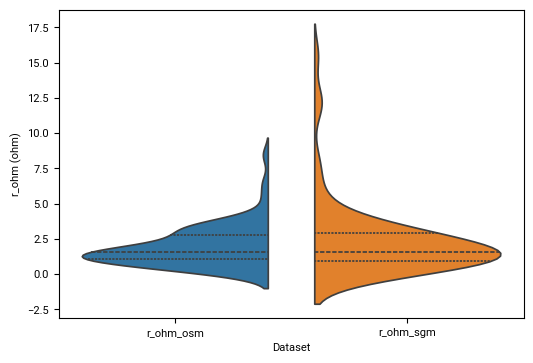

In [314]:
# Create violin_plot for r_ohm, osm_on the left, sgm_on the right
fig, ax = plt.subplots(figsize=(6, 4))
sns.violinplot(data=lines_osm_50hertz_map[["r_ohm_osm", "r_ohm_sgm"]], ax=ax, split=True, inner="quartile")
ax.set_ylabel("r_ohm (ohm)")
ax.set_xlabel("Dataset")
plt.show()

<>:44: SyntaxWarning:

invalid escape sequence '\O'

<>:45: SyntaxWarning:

invalid escape sequence '\O'

<>:50: SyntaxWarning:

invalid escape sequence '\O'

<>:51: SyntaxWarning:

invalid escape sequence '\O'

<>:56: SyntaxWarning:

invalid escape sequence '\O'

<>:57: SyntaxWarning:

invalid escape sequence '\O'

<>:62: SyntaxWarning:

invalid escape sequence '\O'

<>:63: SyntaxWarning:

invalid escape sequence '\O'

<>:44: SyntaxWarning:

invalid escape sequence '\O'

<>:45: SyntaxWarning:

invalid escape sequence '\O'

<>:50: SyntaxWarning:

invalid escape sequence '\O'

<>:51: SyntaxWarning:

invalid escape sequence '\O'

<>:56: SyntaxWarning:

invalid escape sequence '\O'

<>:57: SyntaxWarning:

invalid escape sequence '\O'

<>:62: SyntaxWarning:

invalid escape sequence '\O'

<>:63: SyntaxWarning:

invalid escape sequence '\O'

/tmp/ipykernel_25530/1628527241.py:44: SyntaxWarning:

invalid escape sequence '\O'

/tmp/ipykernel_25530/1628527241.py:45: SyntaxWarning:

invalid esca

ValueError: Could not interpret value `bool` for `hue`. An entry with this name does not appear in `data`.

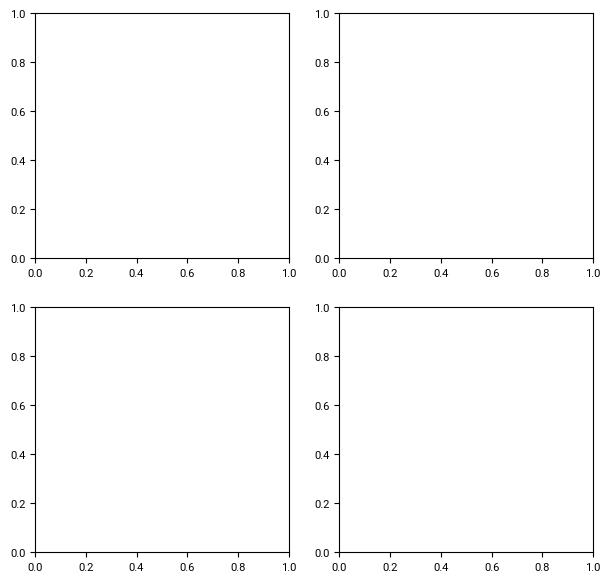

In [315]:
fontsize = 8

# create custom palette with four colors, green, red, blue, orange, use hex codes
custom_palette = sns.color_palette(["#F39200", "darkred", "royalblue", "purple"])

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(7.2, 7)) # gridspec_kw={"wspace": 0.1, "hspace": 0.1})
sns.scatterplot(data = lines_osm_50hertz_map, x="r_ohm_osm", y="r_ohm_sgm", ax=ax1, alpha=0.7, s=15, hue="bool", palette=custom_palette)
sns.scatterplot(data = lines_osm_50hertz_map, x="x_ohm_osm", y="x_ohm_sgm", ax=ax2, alpha=0.7, s=15, hue="bool", palette=custom_palette)
sns.scatterplot(data = lines_osm_50hertz_map, x="r_ohm_osm_agg", y="r_ohm_sgm_agg", ax=ax3, alpha=0.7, s=15, hue="bool", palette=custom_palette)
sns.scatterplot(data = lines_osm_50hertz_map, x="x_ohm_osm_agg", y="x_ohm_sgm_agg", ax=ax4, alpha=0.7, s=15, hue="bool", palette=custom_palette)


x_min_x = 0
x_max_x = 60
y_min_x = 0
y_max_x = 60

x_min_r = 0
x_max_r = 16
y_min_r = 0
y_max_r = 16

ax1.plot([x_min_r, x_max_r], [y_min_r, y_max_r], color="black", linewidth=0.5, linestyle="--")
ax2.plot([x_min_x, x_max_x], [y_min_x, y_max_x], color="black", linewidth=0.5, linestyle="--")
ax3.plot([x_min_r, x_max_r], [y_min_r, y_max_r], color="black", linewidth=0.5, linestyle="--")
ax4.plot([x_min_x, x_max_x], [y_min_x, y_max_x], color="black", linewidth=0.5, linestyle="--")

legend_title = "Parallel circuits"

# # Legends without border and bottom right
# ax1.legend(title=legend_title, loc='lower right', frameon=False)
# ax2.legend(title=legend_title, loc='lower right', frameon=False)
# ax3.legend(title=legend_title, loc='lower right', frameon=False)
# ax4.legend(title=legend_title, loc='lower right', frameon=False)

# remove all legends
ax1.legend().remove()
ax2.legend().remove()
ax3.legend().remove()
ax4.legend().remove()


ax1.set(title="Resistance per circuit")
ax1.set_xlabel("r ($\Omega$) — OSM")
ax1.set_ylabel("r ($\Omega$) — 50Hertz static grid model")
ax1.set_xlim(x_min_r, x_max_r)
ax1.set_ylim(y_min_r, y_max_r)

ax2.set_title("Reactance per circuit")
ax2.set_xlabel("x ($\Omega$) — OSM")
ax2.set_ylabel("x ($\Omega$) — 50Hertz static grid model")
ax2.set_xlim(x_min_x, x_max_x)
ax2.set_ylim(y_min_x, y_max_x)

ax3.set(title="Equivalent resistance")
ax3.set_xlabel("r ($\Omega$) — OSM")
ax3.set_ylabel("r ($\Omega$) — 50Hertz static grid model")
ax3.set_xlim(x_min_r, x_max_r)
ax3.set_ylim(y_min_r, y_max_r)

ax4.set(title="Equivalent reactance")
ax4.set_xlabel("x ($\Omega$) — OSM")
ax4.set_ylabel("x ($\Omega$) — 50Hertz static grid model")
ax4.set_xlim(x_min_x, x_max_x)
ax4.set_ylim(y_min_x, y_max_x)

ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')
ax3.set_aspect('equal', adjustable='box')
ax4.set_aspect('equal', adjustable='box')

ax1.title.set_fontsize(fontsize)
ax2.title.set_fontsize(fontsize)
ax3.title.set_fontsize(fontsize)
ax4.title.set_fontsize(fontsize)

handles, labels = ax1.get_legend_handles_labels()

# Create a single legend below the entire figure with 4 columns
fig.legend(handles, labels, loc='lower left', ncol=2, fontsize=fontsize, title=None, frameon=False, bbox_to_anchor=(0.25, -0.06))


plt.tight_layout()
fig.savefig(f"{parent_dir}/figures/fig_scatter_reactance_resistance.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()


In [ ]:
df_sgm_grouped.query('bool == ')

In [316]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots  # Add this line
import numpy as np

# Define vmax and colormap
vmax = 0.5

# Define the diverging colormap manually (using similar colors)
colorscale = [[0.0, 'red'], [0.5, 'black'], [1.0, 'blue']]

# Normalize the data with a center at zero (similar to TwoSlopeNorm)
def normalize(val, vmin, vmax, vcenter=0):
    if val < vcenter:
        return 0.5 * (val - vmin) / (vcenter - vmin)
    else:
        return 0.5 + 0.5 * (val - vcenter) / (vmax - vcenter)

lines_osm_50hertz_map['normalized_i_nom_ratio'] = lines_osm_50hertz_map['i_nom_ratio'].apply(lambda x: normalize(x, -vmax, vmax))

# Prepare the figures
fig = make_subplots(rows=2, cols=2, subplot_titles=("r_ohm_osm vs r_ohm_sgm", "x_ohm_osm vs x_ohm_sgm", "r_ohm_osm_agg vs r_ohm_sgm_agg", "x_ohm_osm_agg vs x_ohm_sgm_agg"))

# Scatter plot 1
fig.add_trace(
    go.Scatter(
        x=lines_osm_50hertz_map['r_ohm_osm'],
        y=lines_osm_50hertz_map['r_ohm_sgm'],
        mode='markers',
        marker=dict(
            size=5,
            color=lines_osm_50hertz_map['normalized_i_nom_ratio'],
            colorscale=colorscale,
            showscale=True,
            opacity=0.4
        ),
        text=lines_osm_50hertz_map.index,  # Add the index for hover
        hoverinfo='text+x+y'  # Show index, x, and y values on hover
    ),
    row=1, col=1
)

# 1:1 line for scatter plot 1
x_max = max(lines_osm_50hertz_map["r_ohm_osm"].max(), lines_osm_50hertz_map["r_ohm_sgm"].max())
fig.add_trace(
    go.Scatter(
        x=[0, x_max],
        y=[0, x_max],
        mode='lines',
        line=dict(color='black', dash='dash', width=1),
    ),
    row=1, col=1
)

# Scatter plot 2
fig.add_trace(
    go.Scatter(
        x=lines_osm_50hertz_map['x_ohm_osm'],
        y=lines_osm_50hertz_map['x_ohm_sgm'],
        mode='markers',
        marker=dict(
            size=5,
            color=lines_osm_50hertz_map['normalized_i_nom_ratio'],
            colorscale=colorscale,
            showscale=False,
            opacity=0.4
        ),
        text=lines_osm_50hertz_map.index,  # Add the index for hover
        hoverinfo='text+x+y'  # Show index, x, and y values on hover
    ),
    row=1, col=2
)

# 1:1 line for scatter plot 2
x_max = max(lines_osm_50hertz_map["x_ohm_osm"].max(), lines_osm_50hertz_map["x_ohm_sgm"].max())
fig.add_trace(
    go.Scatter(
        x=[0, x_max],
        y=[0, x_max],
        mode='lines',
        line=dict(color='black', dash='dash', width=1),
    ),
    row=1, col=2
)

# Scatter plot 3
fig.add_trace(
    go.Scatter(
        x=lines_osm_50hertz_map['r_ohm_osm_agg'],
        y=lines_osm_50hertz_map['r_ohm_sgm_agg'],
        mode='markers',
        marker=dict(
            size=5,
            color=lines_osm_50hertz_map['normalized_i_nom_ratio'],
            colorscale=colorscale,
            showscale=False,
            opacity=0.4
        ),
        text=lines_osm_50hertz_map.index,  # Add the index for hover
        hoverinfo='text+x+y'  # Show index, x, and y values on hover
    ),
    row=2, col=1
)

# 1:1 line for scatter plot 3
x_max = max(lines_osm_50hertz_map["r_ohm_osm_agg"].max(), lines_osm_50hertz_map["r_ohm_sgm_agg"].max())
fig.add_trace(
    go.Scatter(
        x=[0, x_max],
        y=[0, x_max],
        mode='lines',
        line=dict(color='black', dash='dash', width=1),
    ),
    row=2, col=1
)

# Scatter plot 4
fig.add_trace(
    go.Scatter(
        x=lines_osm_50hertz_map['x_ohm_osm_agg'],
        y=lines_osm_50hertz_map['x_ohm_sgm_agg'],
        mode='markers',
        marker=dict(
            size=5,
            color=lines_osm_50hertz_map['normalized_i_nom_ratio'],
            colorscale=colorscale,
            showscale=False,
            opacity=0.4
        ),
        text=lines_osm_50hertz_map.index,  # Add the index for hover
        hoverinfo='text+x+y'  # Show index, x, and y values on hover
    ),
    row=2, col=2
)

# 1:1 line for scatter plot 4
x_max = max(lines_osm_50hertz_map["x_ohm_osm_agg"].max(), lines_osm_50hertz_map["x_ohm_sgm_agg"].max())
fig.add_trace(
    go.Scatter(
        x=[0, x_max],
        y=[0, x_max],
        mode='lines',
        line=dict(color='black', dash='dash', width=1),
    ),
    row=2, col=2
)

# Update layout
fig.update_layout(
    height=700,
    width=900,
    title_text="Scatter Plots",
    showlegend=False,
    template="simple_white"
)

fig.update_xaxes(title_text="OSM")
fig.update_yaxes(title_text="SGM")

fig.show()


In [317]:
lines_osm_50hertz_map.loc[["Vieselbach - Altenfeld", "Ragow - Streumen"]]

v_nom_osm  i_nom_osm  length_osm  r_ohm_osm  \
line_id                                                               
Vieselbach - Altenfeld      380.0       2.58   56.997152   1.709915   
Ragow - Streumen            380.0       2.58   88.586897   2.657607   

                        x_ohm_osm  num_parallel  v_nom_sgm  i_nom_sgm  \
line_id                                                                 
Vieselbach - Altenfeld  14.021299           2.0      380.0      3.600   
Ragow - Streumen        21.792377           2.0      380.0      2.504   

                        length_sgm  r_ohm_sgm  x_ohm_sgm  count  i_nom_ratio  \
line_id                                                                        
Vieselbach - Altenfeld      56.081     1.1669    14.5030    2.0     0.283333   
Ragow - Streumen            88.719     2.9365    22.6101    2.0     0.030351   

                         ratio Parallel circuits  r_ohm_osm_agg  \
line_id                                                           
Vieselbach - Altenfeld  <= 0.3             equal       0.854957   
Ragow - Streumen        <= 0.3             equal       1.328803   

                        r_ohm_sgm_agg  x_ohm_osm_agg  x_ohm_sgm_agg  \
line_id                                                               
Vieselbach - Altenfeld        0.58345       7.010650        7.25150   
Ragow - Streumen              1.46825      10.896188       11.30505   

                        normalized_i_nom_ratio  
line_id                                         
Vieselbach - Altenfeld                0.783333  
Ragow - Streumen                      0.530351

<>:14: SyntaxWarning:

invalid escape sequence '\O'

<>:20: SyntaxWarning:

invalid escape sequence '\O'

<>:29: SyntaxWarning:

invalid escape sequence '\O'

<>:33: SyntaxWarning:

invalid escape sequence '\O'

<>:14: SyntaxWarning:

invalid escape sequence '\O'

<>:20: SyntaxWarning:

invalid escape sequence '\O'

<>:29: SyntaxWarning:

invalid escape sequence '\O'

<>:33: SyntaxWarning:

invalid escape sequence '\O'

/tmp/ipykernel_25530/3338990771.py:14: SyntaxWarning:

invalid escape sequence '\O'

/tmp/ipykernel_25530/3338990771.py:20: SyntaxWarning:

invalid escape sequence '\O'

/tmp/ipykernel_25530/3338990771.py:29: SyntaxWarning:

invalid escape sequence '\O'

/tmp/ipykernel_25530/3338990771.py:33: SyntaxWarning:

invalid escape sequence '\O'



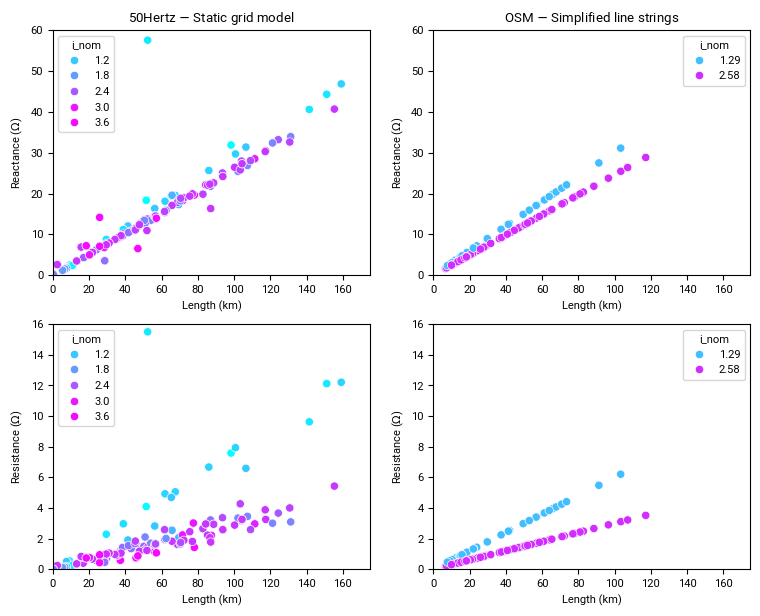

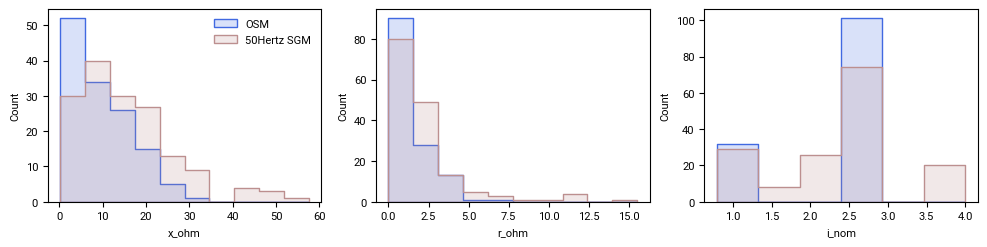

In [318]:
# Corrected code
# Define colormap for links (viridis colormap)
unique_i_nom = sorted(pd.concat([df_sgm.i_nom, lines_osm_50hertz_simpl.i_nom], axis=0).unique())
colors_i_nom = cm.cool(np.linspace(0, 1, len(unique_i_nom)))  # unique_i_nom, not unique_p_nom
cmap_i_nom = mcolors.ListedColormap(colors_i_nom)
norm_i_nom = mcolors.BoundaryNorm(boundaries=np.append(unique_i_nom, unique_i_nom[-1] + 1), ncolors=len(unique_i_nom))

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(9, 7))

# First plot
sns.scatterplot(data=df_sgm, x="length", y="x_ohm", hue="i_nom", palette=cmap_i_nom, ax=ax1, hue_norm=norm_i_nom)
ax1.set_title("50Hertz $-$ Static grid model")
ax1.set_xlabel("Length (km)")
ax1.set_ylabel("Reactance ($\Omega$)")

# Second plot
sns.scatterplot(data=lines_osm_50hertz_simpl, x="length", y="x_ohm", hue="i_nom", palette=cmap_i_nom, ax=ax2, hue_norm=norm_i_nom)
ax2.set_title("OSM $-$ Simplified line strings")
ax2.set_xlabel("Length (km)")
ax2.set_ylabel("Reactance ($\Omega$)")

ax1.set_xlim(0, 175)
ax1.set_ylim(0, 60)
ax2.set_xlim(0, 175)
ax2.set_ylim(0, 60)

sns.scatterplot(data=df_sgm, x="length", y="r_ohm", hue="i_nom", palette=cmap_i_nom, ax=ax3, hue_norm=norm_i_nom)
ax3.set_xlabel("Length (km)")
ax3.set_ylabel("Resistance ($\Omega$)")

sns.scatterplot(data=lines_osm_50hertz_simpl, x="length", y="r_ohm", hue="i_nom", palette=cmap_i_nom, ax=ax4, hue_norm=norm_i_nom)
ax4.set_xlabel("Length (km)")
ax4.set_ylabel("Resistance ($\Omega$)")

ax3.set_xlim(0, 175)
ax3.set_ylim(0, 16)
ax4.set_xlim(0, 175)
ax4.set_ylim(0, 16)

plt.show()

# Histograms electric parameters
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx

fontsize = 8
title_fontsize = fontsize

# Calculate common bins for each dimension
x_min = min(lines_osm_50hertz_simpl["x_ohm"].min(), df_sgm["x_ohm"].min())
x_max = max(lines_osm_50hertz_simpl["x_ohm"].max(), df_sgm["x_ohm"].max())
x_bins = np.linspace(x_min, x_max, 11)  # 10 bins

r_min = min(lines_osm_50hertz_simpl["r_ohm"].min(), df_sgm["r_ohm"].min())
r_max = max(lines_osm_50hertz_simpl["r_ohm"].max(), df_sgm["r_ohm"].max())
r_bins = np.linspace(r_min, r_max, 11)  # 10 bins

i_min = min(lines_osm_50hertz_simpl["i_nom"].min(), df_sgm["i_nom"].min())
i_max = max(lines_osm_50hertz_simpl["i_nom"].max(), df_sgm["i_nom"].max())
i_bins = np.linspace(i_min, i_max, 7)  # 10 bins

# Create the figure and axes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 2.5))

# Plot histograms with the same bins
sns.histplot(lines_osm_50hertz_simpl["x_ohm"], 
             bins=x_bins, ax=ax1, color="royalblue", alpha=0.2, element="step", label="OSM", )
sns.histplot(df_sgm["x_ohm"], 
             bins=x_bins, ax=ax1, color="rosybrown", alpha=0.2, element="step", label="50Hertz SGM")
sns.histplot(lines_osm_50hertz_simpl["r_ohm"], 
             bins=r_bins, ax=ax2, color="royalblue", alpha=0.2, element="step", label="OSM", )
sns.histplot(df_sgm["r_ohm"], 
             bins=r_bins, ax=ax2, color="rosybrown", alpha=0.2, element="step", label="50Hertz SGM")
sns.histplot(lines_osm_50hertz_simpl["i_nom"], 
             bins=i_bins, ax=ax3, color="royalblue", alpha=0.2, element="step", label="OSM", )
sns.histplot(df_sgm["i_nom"], 
             bins=i_bins, ax=ax3, color="rosybrown", alpha=0.2, element="step", label="50Hertz SGM")

# Legends and stuff
# set fontsize
ax1.xaxis.label.set_fontsize(fontsize)
ax1.yaxis.label.set_fontsize(fontsize)
# ax1.set_xlabel("Degree (weighted by no. of circuits)")
ax1.set_ylabel("Count")
ax1.legend(title=None, loc='upper right', frameon=False, fontsize=fontsize, title_fontsize=title_fontsize)

plt.show()


## Numbers

#### Route length

In [319]:
# Pearson
lines_base.corr()

length_routes_stats  length_circuits_stats  \
length_routes_stats                 1.000000               0.924017   
length_circuits_stats               0.924017               1.000000   
length_routes_gridkit               0.949748               0.964051   
length_circuits_gridkit             0.917322               0.986209   
length_routes_osm                   0.963625               0.976390   
length_circuits_osm                 0.925232               0.998018   

                         length_routes_gridkit  length_circuits_gridkit  \
length_routes_stats                   0.949748                 0.917322   
length_circuits_stats                 0.964051                 0.986209   
length_routes_gridkit                 1.000000                 0.974746   
length_circuits_gridkit               0.974746                 1.000000   
length_routes_osm                     0.988519                 0.967046   
length_circuits_osm                   0.971157                 0.988501   

                         length_routes_osm  length_circuits_osm  
length_routes_stats               0.963625             0.925232  
length_circuits_stats             0.976390             0.998018  
length_routes_gridkit             0.988519             0.971157  
length_circuits_gridkit           0.967046             0.988501  
length_routes_osm                 1.000000             0.982194  
length_circuits_osm               0.982194             1.000000

In [320]:

# Calculate RMSE between GridKit and ENTSO-E statistics
rmse_routes_gridkit = np.sqrt(np.mean(((lines_base["length_routes_gridkit"] - lines_base["length_routes_stats"]))**2))
rmse_routes_osm = np.sqrt(np.mean(((lines_base["length_routes_osm"] - lines_base["length_routes_stats"]))**2))

print(f"RMSE route lengths between GridKit and ENTSO-E statistics: {rmse_routes_gridkit:.0f} km")
print(f"RMSE route lengths between OSM and ENTSO-E statistics: {rmse_routes_osm:.0f} km")

RMSE route lengths between GridKit and ENTSO-E statistics: 2742 km
RMSE route lengths between OSM and ENTSO-E statistics: 2468 km


In [321]:
# Calculate RMSE between GridKit and ENTSO-E statistics
rmse_circuits_gridkit = np.sqrt(np.mean(((lines_base["length_circuits_gridkit"] - lines_base["length_circuits_stats"]))**2))
rmse_circuits_osm = np.sqrt(np.mean(((lines_base["length_circuits_osm"] - lines_base["length_circuits_stats"]))**2))

print(f"RMSE circuit lengths between GridKit and ENTSO-E statistics: {rmse_circuits_gridkit:.0f} km")
print(f"RMSE circuit lengths between OSM and ENTSO-E statistics: {rmse_circuits_osm:.0f} km")

RMSE circuit lengths between GridKit and ENTSO-E statistics: 2051 km
RMSE circuit lengths between OSM and ENTSO-E statistics: 828 km


#### Total line volumes

Line volumes

In [322]:
metrics_lines_grouped_nuts1

length_gridkit  line_volume_gridkit   length_osm  \
region_code                                                     
AL0             1551.925865         1.897748e+06  1492.767527   
AT1             1564.289647         3.241346e+06  1413.196907   
AT2              997.268812         1.693263e+06   924.159475   
AT3             1950.935435         3.798961e+06  2138.677318   
BABIH           2017.464885         1.875482e+06  2249.245342   
...                     ...                  ...          ...   
UKJ             1290.761169         3.538392e+06  1249.808976   
UKK             1217.412962         3.575357e+06  1127.302028   
UKL              958.717401         2.737216e+06  1047.878828   
UKM             2853.653827         5.008557e+06  2911.742593   
UKN              423.095213         3.836237e+05   415.775799   

             line_volume_osm country  
region_code                           
AL0             1.809562e+06      AL  
AT1             3.471045e+06      AT  
AT2             1.577521e+06      AT  
AT3             3.482573e+06      AT  
BABIH           2.129464e+06      BA  
...                      ...     ...  
UKJ             4.265045e+06      UK  
UKK             3.873697e+06      UK  
UKL             3.120458e+06      UK  
UKM             6.142186e+06      UK  
UKN             7.664141e+05      UK  

[131 rows x 5 columns]

In [323]:
metrics_lines_grouped_nuts1[["line_volume_gridkit", "line_volume_osm"]].corr?

Object `corr` not found.


In [324]:
# Pearson
metrics_lines_grouped_nuts1[["line_volume_gridkit", "line_volume_osm"]].corr()

line_volume_gridkit  line_volume_osm
line_volume_gridkit             1.000000         0.947919
line_volume_osm                 0.947919         1.000000

In [325]:
rmsre_line_volume_nuts1 = np.sqrt(np.mean(((metrics_lines_grouped_nuts1["line_volume_gridkit"] - metrics_lines_grouped_nuts1["line_volume_osm"])/metrics_lines_grouped_nuts1["line_volume_gridkit"]*100)**2))
rmsre_line_volume_nuts2 = np.sqrt(np.mean(((metrics_lines_grouped_nuts2["line_volume_gridkit"] - metrics_lines_grouped_nuts2["line_volume_osm"])/metrics_lines_grouped_nuts2["line_volume_gridkit"]*100)**2))

print(f"RMSRE line volume between GridKit and OSM (NUTS1): {rmsre_line_volume_nuts1:.1f}%")
print(f"RMSRE line volume between GridKit and OSM (NUTS2): {rmsre_line_volume_nuts2:.1f}%")



RMSRE line volume between GridKit and OSM (NUTS1): 33.1%
RMSRE line volume between GridKit and OSM (NUTS2): 105.0%


In [326]:
rmse_line_volume_nuts1 = np.sqrt(np.mean(((metrics_lines_grouped_nuts1["line_volume_gridkit"] - metrics_lines_grouped_nuts1["line_volume_osm"]))**2))
rmse_line_volume_nuts2 = np.sqrt(np.mean(((metrics_lines_grouped_nuts2["line_volume_gridkit"] - metrics_lines_grouped_nuts2["line_volume_osm"]))**2))

print(f"RMSE line volumes between GridKit and OSM for NUTS1: {rmse_line_volume_nuts1:.0f} MVAkm")
print(f"RMSE line volumes between GridKit and OSM for NUTS2: {rmse_line_volume_nuts2:.0f} MVAkm")

RMSE line volumes between GridKit and OSM for NUTS1: 1085027 MVAkm
RMSE line volumes between GridKit and OSM for NUTS2: 716145 MVAkm


#### RMSE cross-region

In [327]:
# Pearson
metrics_crossborder[["s_nom_gridkit", "s_nom_osm"]].corr()

s_nom_gridkit  s_nom_osm
s_nom_gridkit       1.000000   0.849139
s_nom_osm           0.849139   1.000000

In [328]:
rmse_crossborder_s_nom = np.sqrt(np.mean(((metrics_crossborder["s_nom_gridkit"] - metrics_crossborder["s_nom_osm"]))**2))
rmse_crossborder_count = np.sqrt(np.mean(((metrics_crossborder["num_parallel_gridkit"] - metrics_crossborder["num_parallel_osm"]))**2))

print(f"RMSE cross-border capacity between GridKit and OSM: {rmse_crossborder_s_nom:.0f} MVA")
print(f"RMSE cross-border line count between GridKit and OSM: {rmse_crossborder_count:.1f}")

RMSE cross-border capacity between GridKit and OSM: 3346 MVA
RMSE cross-border line count between GridKit and OSM: 3.0


In [329]:
metrics_crossborder

s_nom_gridkit  num_parallel_gridkit     s_nom_osm  num_parallel_osm
border                                                                      
AL0-GR5    1698.102612                   1.0   1787.476433               1.0
AL0-ME0    2189.658631                   2.0   2279.032453               2.0
AT1-AT2    4379.317262                   4.0   4379.317262               4.0
AT1-AT3    5362.429300                   6.0   4379.317262               4.0
AT1-CZ0    4379.317262                   4.0   4558.064905               4.0
...                ...                   ...           ...               ...
UKH-UKI   14523.246021                  11.0   9160.816721               9.0
UKH-UKJ   15595.731882                  10.0   5418.287939               4.0
UKI-UKJ    5027.277469                   5.0   1843.335072               2.0
UKJ-UKK   10188.615670                   6.0  10724.858600               6.0
UKK-UKL    8803.321435                   6.0   5418.287939               4.0

[228 rows x 4 columns]

In [330]:
# Pearson line crossings
metrics_crossborder[["num_parallel_gridkit", "num_parallel_osm"]].corr()

num_parallel_gridkit  num_parallel_osm
num_parallel_gridkit               1.00000           0.85734
num_parallel_osm                   0.85734           1.00000

#### Route lengths

In [331]:
print(f"Length Gridkit: {round((n_base_gridkit.lines.length.sum()+n_base_gridkit.links.length.sum()))} km")
print(f"Length OSM: {round((n_base_osm.lines.length.sum()+n_base_osm.links.length.sum()))} km")

Length Gridkit: 250627 km
Length OSM: 261746 km


In [332]:
# Clustered
print(f"Length Gridkit clustered: {round((n_results_gridkit.lines.length.sum()+n_results_gridkit.links.length.sum()))} km")
print(f"Length OSM clustered: {round((n_results_osm.lines.length.sum()+n_results_osm.links.length.sum()))} km")

Length Gridkit clustered: 111854 km
Length OSM clustered: 109359 km


## Tables

### DC links

In [333]:
def create_osm_url(str):
    url_prefix = r"\href{https://www.openstreetmap.org/"
    url = url_prefix + str + "}" + "{" + str + "}"

    return url

In [334]:
dc_links = pd.read_csv("data/dc_link_names.csv", index_col=0)

In [335]:
dc_links = dc_links.merge(n_base_osm.links[["voltage", "p_nom", "length"]], left_index=True, right_index=True)

In [336]:
dc_links["voltage"] = dc_links["voltage"].astype(int)
dc_links["p_nom"] = dc_links["p_nom"].astype(int)
dc_links["length"] = np.round(dc_links["length"], 0)
dc_links["length"] = dc_links["length"].astype(int)
dc_links.reset_index(inplace=True)

In [337]:
dc_links["url"] = dc_links["Link"].apply(lambda x: create_osm_url(x))

In [338]:
columns = ["url", "name", "from", "to", "voltage", "p_nom", "length"]

In [339]:
dc_links.loc[dc_links.Link == "relation/9934065", "url"].iloc[0]

'\\href{https://www.openstreetmap.org/relation/9934065}{relation/9934065}'

In [340]:
r'dc_links.loc[dc_links.Link == "relation/9934065", "url"].iloc[0]' + ", " + r'dc_links.loc[dc_links.Link == "relation/9934066", "url"].iloc[0]'

'dc_links.loc[dc_links.Link == "relation/9934065", "url"].iloc[0], dc_links.loc[dc_links.Link == "relation/9934066", "url"].iloc[0]'

In [341]:
inelfe_combined = {
    "Link": "relation/9934065, relation/9934066",  # Combined link
    "url": (dc_links.loc[dc_links.Link == "relation/9934065", "url"].iloc[0] + "; " +
            dc_links.loc[dc_links.Link == "relation/9934066", "url"].iloc[0]),
    "name": "Interconnexion Electrique France-Espagne (INELFE)", 
    "from": dc_links.loc[dc_links.Link == "relation/9934065", "from"].iloc[0], 
    "to": dc_links.loc[dc_links.Link == "relation/9934065", "to"].iloc[0], 
    "voltage": dc_links.loc[dc_links.Link == "relation/9934065", "voltage"].iloc[0], 
    "p_nom": dc_links.loc[dc_links.Link == "relation/9934065", "p_nom"].iloc[0]*2, 
    "length": dc_links.loc[dc_links.Link == "relation/9934065", "length"].iloc[0],
}

# Convert the test dictionary into a DataFrame row
inelfe_combined = pd.DataFrame([inelfe_combined])

# Append the new row to the existing DataFrame
dc_links = pd.concat([dc_links, inelfe_combined], ignore_index=True)
dc_links.drop(dc_links[dc_links["Link"] == "relation/9934065"].index, inplace=True)
dc_links.drop(dc_links[dc_links["Link"] == "relation/9934066"].index, inplace=True)

In [342]:
dc_links = dc_links.sort_values(by="name")
dc_links

Link  \
8                     relation/8193755   
10                    relation/3918230   
30                   relation/14126301   
3                     relation/8099179   
1                    relation/17631956   
11                    relation/8185420   
22                    relation/2127794   
28                    relation/8184641   
27                   relation/15772117   
35                    relation/8184630   
17                    relation/6886400   
20                    relation/8184631   
21                    relation/3391954   
34                    relation/3392001   
0                     relation/5487095   
37  relation/9934065, relation/9934066   
26                   relation/10377412   
6                     relation/8185664   
24                    relation/9982798   
23                    relation/3391794   
9                     relation/2505320   
36                    relation/8184629   
31                    relation/8185767   
2                     relation/6914309   
7                     relation/8185487   
12                    relation/9965201   
32                    relation/8185455   
13                   relation/16213216   
29                   relation/13295785   
25                    relation/8185711   
14                    relation/3391931   
15                    relation/8184632   
33                    relation/3392010   
5                     relation/8184633   
16                   relation/15781671   
4                    relation/15775538   

                                                 name    from      to  \
8    Aachen Lüttich Electricity Grid Overlay (ALEGrO)      BE      DE   
10                                       Baltic Cable      DE      SE   
30                                            BritNed  GB-ENG      NL   
3                                Caithness-Moray Link  GB-SCT  GB-SCT   
1   Conexión Mediterránea Transporte Alta tensión ...      ES      ES   
11   Copenhagen-Brussels-Amsterdam cable (COBRAcable)      DK      NL   
22                           Cross-Channel (IFA 2000)      FR  GB-ENG   
28                           East-West Interconnector      IE  GB-WLS   
27                                           ElecLink      FR  GB-ENG   
35                                          Estlink 1      EE      FI   
17                                          Estlink 2      EE      FI   
20                                         Fenno-Skan      FI      SE   
21                                       Fenno-Skan 2      FI      SE   
34                       Gotlandslänken (Gotland 2+3)      SE      SE   
0                               Great Belt power link      DK      DK   
37  Interconnexion Electrique France-Espagne (INELFE)      ES      FR   
26         Interconnexion France-Angleterre 2 (IFA-2)      FR  GB-ENG   
6                                        Italy-Greece      GR      IT   
24  Italy–Corsica–Sardinia (SACOI) - Corsica-Sardinia      FR      IT   
23     Italy–Corsica–Sardinia (SACOI) - Italy-Corsica      FR      IT   
9                                              KONTEK      DE      DK   
36                                         Konti-Skan      DK      SE   
31                         Montenegro-Italy (MON.ITA)      IT      ME   
2                                Moyle interconnector  GB-NIR  GB-SCT   
7                                           Nemo Link      BE  GB-ENG   
12                                             NorNed      NL      NO   
32                                           NordBalt      LT      SE   
13                                           NordLink      DE      NO   
29                                     North Sea Link  GB-ENG      NO   
25                 Sardegna-Penisola Italiana (SAPEI)      IT      IT   
14                                    Skagerrak (1-3)      DK      NO   
15                                      Skagerrak (4)      DK      NO   
33                                             SwePol      PL      SE 

In [343]:
dc_links[columns].to_csv(f"{parent_dir}/datatables/dc_links.csv", index=False)

### Results table

In [344]:
n_results_osm.loads_t["p_set"].sum().sum()/1e6

3377.0792985558683

In [345]:
n_results_gridkit.loads_t["p_set"].sum().sum()/1e6

3377.0792985558687

In [346]:
sum(n_results_osm.lines.length*n_results_osm.lines.num_parallel)-sum(n_results_gridkit.lines.length*n_results_gridkit.lines.num_parallel)

-4969.38713084301

In [347]:
supply = pd.concat([
    n_results_gridkit.statistics.energy_balance().droplevel("component").groupby("carrier").sum(),
    n_results_osm.statistics.energy_balance().droplevel("component").groupby("carrier").sum()],
    axis=1
)

supply.columns = ["GridKit", "OSM"]
supply["Difference OSM-GridKit"] = supply["OSM"] - supply["GridKit"]
supply.div(1e6)

GridKit           OSM  Difference OSM-GridKit
carrier                                                                 
-                    -3.377079e+03 -3.377079e+03            0.000000e+00
AC                   -5.501242e+01 -5.008573e+01            4.926693e+00
Battery Storage       4.852000e-08  1.280000e-08           -3.572000e-08
Combined-Cycle Gas    2.923308e+02  2.884659e+02           -3.864895e+00
H2 electrolysis      -5.251214e-01 -1.513290e-02            5.099885e-01
H2 fuel cell         -4.314939e-01 -1.243487e-02            4.190591e-01
Hydrogen Storage      9.200600e-07  2.490600e-07           -6.710000e-07
Offshore Wind (AC)    4.223047e+01  3.859443e+01           -3.636040e+00
Offshore Wind (DC)    7.442512e+01  8.627300e+01            1.184788e+01
Onshore Wind          7.839962e+02  7.768724e+02           -7.123828e+00
Open-Cycle Gas        4.937612e-02  5.254495e-02            3.168831e-03
Pumped Hydro Storage -2.908496e+01 -2.885446e+01            2.305009e-01
Reservoir & Dam       3.468707e+02  3.468829e+02            1.212041e-02
Run of River          1.710741e+02  1.711868e+02            1.127164e-01
Solar                 8.598887e+02  8.532097e+02           -6.678918e+00
battery charger      -2.411805e+00 -2.326898e+00            8.490746e-02
battery discharger   -2.363077e+00 -2.279885e+00            8.319199e-02
biomass               1.204236e+02  1.195187e+02           -9.049371e-01
coal                  4.770239e+00  5.662246e+00            8.920070e-01
geothermal            4.338669e-01  4.431163e-01            9.249419e-03
lignite               7.500938e+00  7.156292e+00           -3.446458e-01
nuclear               7.629120e+02  7.663353e+02            3.423333e+00
oil                   2.106862e-03  5.484823e-04           -1.558379e-03

In [348]:
optimal_capacity = pd.concat([
    n_results_gridkit.statistics.optimal_capacity(groupby = n_results_gridkit.statistics.groupers.get_bus_and_carrier).droplevel("component").groupby("carrier").sum(),
    n_results_osm.statistics.optimal_capacity(groupby = n_results_osm.statistics.groupers.get_bus_and_carrier).droplevel("component").groupby("carrier").sum()],
    axis=1
)

optimal_capacity.columns = ["GridKit", "OSM"]
optimal_capacity["Difference OSM-GridKit"] = optimal_capacity["OSM"] - optimal_capacity["GridKit"]
optimal_capacity

GridKit           OSM  Difference OSM-GridKit
carrier                                                                 
AC                    2.626746e+06  2.639402e+06             12655.74893
Battery Storage       3.386809e+05  3.287620e+05             -9918.96995
Combined-Cycle Gas    1.642287e+05  1.639489e+05              -279.80139
DC                    2.649000e+04  3.022000e+04              3730.00000
H2 electrolysis       2.335716e+02  9.817560e+00              -223.75409
H2 fuel cell          1.416039e+03  2.480014e+02             -1168.03737
Hydrogen Storage      7.337436e+05  2.309289e+04           -710650.74359
Offshore Wind (AC)    1.151040e+04  1.041837e+04             -1092.03512
Offshore Wind (DC)    1.776983e+04  2.049251e+04              2722.68606
Onshore Wind          4.240069e+05  4.191941e+05             -4812.74648
Open-Cycle Gas        4.715015e+01  4.715018e+01                 0.00003
Pumped Hydro Storage  5.729207e+04  5.729207e+04                 0.00000
Reservoir & Dam       1.043480e+05  1.043480e+05                -0.00001
Run of River          4.626457e+04  4.626457e+04                 0.00000
Solar                 7.312659e+05  7.263301e+05             -4935.77148
battery charger       5.597292e+04  5.362092e+04             -2352.00763
battery discharger    5.712713e+04  5.472662e+04             -2400.50779
biomass               1.674506e+04  1.674506e+04                 0.00000
coal                  5.664463e+04  5.664463e+04                 0.00000
geothermal            5.900000e+01  5.900000e+01                 0.00000
lignite               3.874214e+04  3.874214e+04                -0.00002
nuclear               1.226491e+05  1.226491e+05                 0.00000
oil                   3.864943e+03  3.864943e+03                 0.00000

In [349]:
n_results_osm.statistics.optimal_capacity(groupby = n_results_osm.statistics.groupers.get_bus_and_carrier) \
    .drop(["AC", "DC"], level="carrier").droplevel("component").groupby("carrier").sum()

carrier
Battery Storage         328761.95364
Combined-Cycle Gas      163948.92538
H2 electrolysis              9.81756
H2 fuel cell               248.00142
Hydrogen Storage         23092.89310
Offshore Wind (AC)       10418.36769
Offshore Wind (DC)       20492.51441
Onshore Wind            419194.12390
Open-Cycle Gas              47.15018
Pumped Hydro Storage     57292.07300
Reservoir & Dam         104348.00672
Run of River             46264.57355
Solar                   726330.12166
battery charger          53620.91676
battery discharger       54726.61895
biomass                  16745.05898
coal                     56644.62760
geothermal                  59.00000
lignite                  38742.13594
nuclear                 122649.10000
oil                       3864.94296
dtype: float64

In [350]:
cell_capex_gridkit = n_results_gridkit.statistics.capex(groupby = n_results_gridkit.statistics.groupers.get_bus_and_carrier) \
    .drop(["AC", "DC"], level="carrier").droplevel("component").groupby("bus").sum()

cell_capex_gridkit.index = cell_capex_gridkit.index.get_level_values('bus').map(lambda x: x.split(' ')[0])

cell_capex_gridkit = cell_capex_gridkit[common_index].div(1e9).sum()
cell_capex_gridkit

274.4620620742543

In [351]:
cell_capex_osm = n_results_osm.statistics.capex(groupby = n_results_osm.statistics.groupers.get_bus_and_carrier) \
    .drop(["AC", "DC"], level="carrier").droplevel("component").groupby("bus").sum()

cell_capex_osm.index = cell_capex_osm.index.get_level_values('bus').map(lambda x: x.split(' ')[0])

cell_capex_osm = cell_capex_osm[common_index].div(1e9).sum()
cell_capex_osm

273.4664052078672

In [352]:
cell_opex_gridkit = n_results_gridkit.statistics.opex(groupby = n_results_gridkit.statistics.groupers.get_bus_and_carrier) \
    .drop(["DC"], level="carrier").droplevel("component").groupby("bus").sum()

cell_opex_gridkit.index = cell_opex_gridkit.index.get_level_values('bus').map(lambda x: x.split(' ')[0])

cell_opex_gridkit = cell_opex_gridkit[common_index].div(1e9).sum()
cell_opex_gridkit

38.482755125305374

In [353]:
cell_opex_osm = n_results_osm.statistics.opex(groupby = n_results_osm.statistics.groupers.get_bus_and_carrier) \
    .drop(["DC"], level="carrier").droplevel("component").groupby("bus").sum()

cell_opex_osm.index = cell_opex_osm.index.get_level_values('bus').map(lambda x: x.split(' ')[0])

cell_opex_osm = cell_opex_osm[common_index].div(1e9).sum()

In [354]:
cell_curtailement_gridkit = n_results_gridkit.statistics.curtailment(comps=["Generator"], groupby=["bus"]).droplevel("component").loc[common_index].div(1e6).sum()
cell_curtailement_osm = n_results_osm.statistics.curtailment(comps=["Generator"], groupby=["bus"]).droplevel("component").loc[common_index].div(1e6).sum()
cell_optimal_supply_gridkit = n_results_gridkit.statistics.supply(comps=["Generator"], groupby=["bus"]).droplevel("component").loc[common_index].div(1e6).sum()
cell_optimal_supply_osm = n_results_osm.statistics.supply(comps=["Generator"], groupby=["bus"]).droplevel("component").loc[common_index].div(1e6).sum()
cell_degree_base_gridkit = np.mean(list(dict(nx.degree(G_base_gridkit, weight='num_parallel')).values()))
cell_degree_base_osm = np.mean(list(dict(nx.degree(G_base_osm, weight='num_parallel')).values()))
cell_degree_results_gridkit = np.mean(list(dict(nx.degree(G_results_gridkit, weight='num_parallel')).values()))
cell_degree_results_osm = np.mean(list(dict(nx.degree(G_results_osm, weight='num_parallel')).values()))
cell_nodal_prices_gridkit = n_results_gridkit.buses_t.marginal_price.mean().loc[common_index]
cell_length_base_gridkit = sum(n_base_gridkit.lines.length*n_base_gridkit.lines.num_parallel)+n_base_gridkit.links.length.sum()
cell_length_base_osm = sum(n_base_osm.lines.length*n_base_osm.lines.num_parallel)+n_base_osm.links.length.sum()
cell_length_results_gridkit = sum(n_results_gridkit.lines.length*n_results_gridkit.lines.num_parallel)+n_results_gridkit.links.length.sum()
cell_length_results_osm = sum(n_results_osm.lines.length*n_results_osm.lines.num_parallel)+n_results_osm.links.length.sum()

In [355]:
(n_base_gridkit.links.length*n_base_gridkit.links.p_nom).sum()

8569478.0361555

In [356]:
cell_linevolume_base_gridkit = (n_base_gridkit.lines.length*n_base_gridkit.lines.s_nom).sum()+(n_base_gridkit.links.length*n_base_gridkit.links.p_nom).sum()
cell_linevolume_base_osm = (n_base_osm.lines.length*n_base_osm.lines.s_nom).sum()+(n_base_osm.links.length*n_base_osm.links.p_nom).sum()
cell_linevolume_results_gridkit = (n_results_gridkit.lines.length*n_results_gridkit.lines.s_nom).sum()+(n_results_gridkit.links.length*n_results_gridkit.links.p_nom).sum()
cell_linevolume_results_osm = (n_results_osm.lines.length*n_results_osm.lines.s_nom).sum()+(n_results_osm.links.length*n_results_osm.links.p_nom).sum()

In [357]:
print(cell_linevolume_base_gridkit/1e6)
print(cell_linevolume_base_osm/1e6)
print(cell_linevolume_results_gridkit/1e6)
print(cell_linevolume_results_osm/1e6)

410.8851888132325
424.44806578411584
431.4683030875984
424.9380124002794


In [358]:
nodal_prices = pd.DataFrame({
    "prices_gridkit": n_results_gridkit.buses_t.marginal_price.mean().loc[common_index],
    "prices_osm": n_results_osm.buses_t.marginal_price.mean().loc[common_index]
})
nodal_prices["country"] = nodal_prices.index.str[:2]


nodal_capex = pd.DataFrame({
    "capex_gridkit": n_results_gridkit.statistics.capex(comps=["Generator"], groupby=["bus"]).droplevel("component").loc[common_index].div(1e9),
    "capex_osm": n_results_osm.statistics.capex(comps=["Generator"], groupby=["bus"]).droplevel("component").loc[common_index].div(1e9)
})
nodal_capex["country"] = nodal_capex.index.str[:2]

nodal_opex = pd.DataFrame({
    "opex_gridkit": n_results_gridkit.statistics.opex(comps=["Generator"], groupby=["bus"]).droplevel("component").loc[common_index].div(1e9),
    "opex_osm": n_results_osm.statistics.opex(comps=["Generator"], groupby=["bus"]).droplevel("component").loc[common_index].div(1e9)
})
nodal_opex["country"] = nodal_opex.index.str[:2]

In [359]:
find_inliers_outliers(nodal_prices, "prices_gridkit", "prices_osm", 0.98)[1]

['DE11', 'DE25', 'DEA3', 'GBI3', 'GBI4', 'GBI6', 'GBI7', 'PL41']

In [360]:
find_inliers_outliers(nodal_capex, "capex_gridkit", "capex_osm", 0.97)[1]

['AL01',
 'BG41',
 'CZ04',
 'FRC1',
 'RS12',
 'UA12',
 'UA21',
 'UA23',
 'UA35',
 'UA48']

In [361]:
find_inliers_outliers(nodal_opex, "opex_gridkit", "opex_osm", 0.97)[1]

['AL01',
 'AT12',
 'BASRP',
 'MD3152',
 'PL82',
 'UA12',
 'UA23',
 'UA30',
 'UA35',
 'UA48']

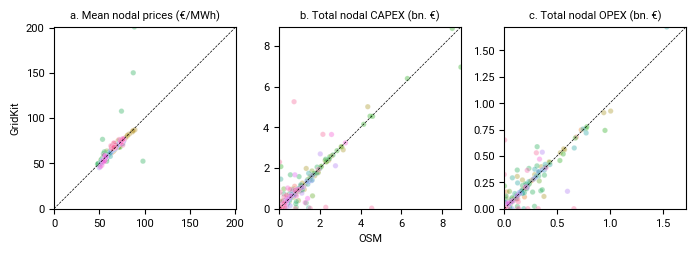

In [362]:
nodal_prices = pd.DataFrame({
    "prices_gridkit": n_results_gridkit.buses_t.marginal_price.mean().loc[common_index],
    "prices_osm": n_results_osm.buses_t.marginal_price.mean().loc[common_index]
})
nodal_prices["country"] = nodal_prices.index.str[:2]


nodal_capex = pd.DataFrame({
    "capex_gridkit": n_results_gridkit.statistics.capex(comps=["Generator"], groupby=["bus"]).droplevel("component").loc[common_index].div(1e9),
    "capex_osm": n_results_osm.statistics.capex(comps=["Generator"], groupby=["bus"]).droplevel("component").loc[common_index].div(1e9)
})
nodal_capex["country"] = nodal_capex.index.str[:2]

nodal_opex = pd.DataFrame({
    "opex_gridkit": n_results_gridkit.statistics.opex(comps=["Generator"], groupby=["bus"]).droplevel("component").loc[common_index].div(1e9),
    "opex_osm": n_results_osm.statistics.opex(comps=["Generator"], groupby=["bus"]).droplevel("component").loc[common_index].div(1e9)
})
nodal_opex["country"] = nodal_opex.index.str[:2]

# Joined plot
fontsize = 8
# change font size of titles

fig, ax = plt.subplots(1, 3, figsize=(7, 2.4))
sns.scatterplot(data = nodal_prices, x="prices_osm", y="prices_gridkit", ax=ax[0], alpha=0.4, hue="country", s=15)
sns.scatterplot(data = nodal_capex, x="capex_osm", y="capex_gridkit", ax=ax[1], alpha=0.4, hue="country", s=15)
sns.scatterplot(data = nodal_opex, x="opex_osm", y="opex_gridkit", ax=ax[2], alpha=0.4, hue="country", s=15)

# remove legend
ax[0].legend().remove()
ax[1].legend().remove()
ax[2].legend().remove()


# Line volume
x_min = 0
x_max = max(nodal_prices["prices_gridkit"].max(), nodal_prices["prices_osm"].max())
y_min = 0
y_max = max(nodal_prices["prices_gridkit"].max(), nodal_prices["prices_osm"].max())
ax[0].plot([x_min, x_max], [y_min, y_max], color="black", linewidth=0.5, linestyle="--")
ax[0].set_title("a. Mean nodal prices (€/MWh)")
ax[0].set_xlabel("")
ax[0].set_ylabel("GridKit")
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)

x_min = 0
x_max = max(nodal_capex["capex_gridkit"].max(), nodal_capex["capex_osm"].max())
y_min = 0
y_max = max(nodal_capex["capex_gridkit"].max(), nodal_capex["capex_osm"].max())
ax[1].plot([x_min, x_max], [y_min, y_max], color="black", linewidth=0.5, linestyle="--")
ax[1].set_title("b. Total nodal CAPEX (bn. €)")
ax[1].set_xlabel("OSM")
ax[1].set_ylabel("")
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylim(y_min, y_max)


x_min = 0
x_max = max(nodal_opex["opex_gridkit"].max(), nodal_opex["opex_osm"].max())
y_min = 0
y_max = max(nodal_opex["opex_gridkit"].max(), nodal_opex["opex_osm"].max())
ax[2].plot([x_min, x_max], [y_min, y_max], color="black", linewidth=0.5, linestyle="--")
ax[2].set_title("c. Total nodal OPEX (bn. €)")
ax[2].set_xlabel("")
ax[2].set_ylabel("")
ax[2].set_xlim(x_min, x_max)
ax[2].set_ylim(y_min, y_max)

ax[0].set_aspect('equal', adjustable='box')
ax[1].set_aspect('equal', adjustable='box')
ax[2].set_aspect('equal', adjustable='box')

for i in range(3):
    ax[i].title.set_fontsize(fontsize)

plt.tight_layout()
fig.savefig(f"{parent_dir}/figures/fig_results_cost_scatter.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

# interactive plotly version
import plotly.express as px

fig = px.scatter(nodal_capex, x="capex_osm", y="capex_gridkit", color="country", hover_name=nodal_capex.index)
fig.update_traces(marker=dict(size=5))

fig.update_layout(
    showlegend=True,
    width=600,
    height=500
)
fig.show()


In [363]:
nodal_prices.loc[nodal_prices["prices_gridkit"] - nodal_prices["prices_osm"] < 25, ["prices_gridkit", "prices_osm"]].corr()

prices_gridkit  prices_osm
prices_gridkit        1.000000    0.918169
prices_osm            0.918169    1.000000

In [364]:
nodal_prices[["prices_gridkit", "prices_osm"]].corr()

prices_gridkit  prices_osm
prices_gridkit         1.00000     0.75738
prices_osm             0.75738     1.00000

In [365]:
nodal_capex[["capex_gridkit", "capex_osm"]].corr()

capex_gridkit  capex_osm
capex_gridkit       1.000000   0.891902
capex_osm           0.891902   1.000000

In [366]:
nodal_opex[["opex_gridkit", "opex_osm"]].corr()

opex_gridkit  opex_osm
opex_gridkit      1.000000  0.913196
opex_osm          0.913196  1.000000

In [367]:
# create results table with metrics, columns are gridkit and osm, rows are system costs, route length
results_table = pd.DataFrame({
    "System costs (bn. €)": [cell_capex_gridkit + cell_opex_gridkit, cell_capex_osm + cell_opex_osm],
    "CAPEX (bn. €)": [cell_capex_gridkit, cell_capex_osm],
    "OPEX (bn. €)": [cell_opex_gridkit, cell_opex_osm],
    "Curtailment (TWh)": [cell_curtailement_gridkit, cell_curtailement_osm],
    "Generation (TWh)": [cell_optimal_supply_gridkit, cell_optimal_supply_osm],
    # "Degree base (mean)": [cell_degree_base_gridkit, cell_degree_base_osm],
    # "Degree clustered (mean)": [cell_degree_results_gridkit, cell_degree_results_osm],
    "Line volume base (MVAkm)": [cell_linevolume_base_gridkit/1e6, cell_linevolume_base_osm/1e6],
    "Line volume clustered (MVAkm)": [cell_linevolume_results_gridkit/1e6, cell_linevolume_results_osm/1e6],
}, index = ["GridKit", "OSM"])

# Add row on relative changes for each column
results_table.loc["Delta (Percent)", :] = (results_table.loc["OSM", :] - results_table.loc["GridKit", :]) / results_table.loc["GridKit", :] * 100 
results_table = results_table.round(2)

results_table.to_csv(f"{parent_dir}/datatables/tab_results.csv", index=True)
results_table

System costs (bn. €)  CAPEX (bn. €)  OPEX (bn. €)  \
GridKit                        312.94         274.46         38.48   
OSM                            311.70         273.47         38.24   
Delta (Percent)                 -0.40          -0.36         -0.64   

                 Curtailment (TWh)  Generation (TWh)  \
GridKit                    2177.91           3120.00   
OSM                        2175.57           3110.03   
Delta (Percent)              -0.11             -0.32   

                 Line volume base (MVAkm)  Line volume clustered (MVAkm)  
GridKit                            410.89                         431.47  
OSM                                424.45                         424.94  
Delta (Percent)                      3.30                          -1.51

### Line types

In [137]:
## Tables
s_nom = lines_osm.copy().groupby(["v_nom", "num_parallel"]).agg(
    length=("length", lambda x: round(sum(x))),
    s_nom=("s_nom", lambda x: round(x.unique()[0]) if len(x.unique()) == 1 else None),
    
).reset_index()

dict_linetype = dict({
    200: "Al/St 240/40 2-bundle 220.0",
    220: "Al/St 240/40 2-bundle 220.0",
    225: "Al/St 240/40 2-bundle 220.0",
    236: "Al/St 240/40 2-bundle 220.0",
    275: "Al/St 240/40 3-bundle 300.0",
    300: "Al/St 240/40 3-bundle 300.0",
    330: "Al/St 240/40 3-bundle 300.0",
    380: "Al/St 240/40 4-bundle 380.0",
    400: "Al/St 240/40 4-bundle 380.0",
    412: "Al/St 240/40 4-bundle 380.0",
    420: "Al/St 240/40 4-bundle 380.0",
    500: "Al/St 240/40 4-bundle 380.0",
    750: "Al/St 560/50 4-bundle 750.0",
})

dict_i_nom = dict({
    "Al/St 240/40 2-bundle 220.0": 1.290,
    "Al/St 240/40 3-bundle 300.0": 1.935,
    "Al/St 240/40 4-bundle 380.0": 2.580,
    "Al/St 560/50 4-bundle 750.0": 4.160,
})

s_nom["line_type"] = s_nom["v_nom"].map(dict_linetype)
s_nom["i_nom"] = s_nom["line_type"].map(dict_i_nom)
s_nom["v_nom"] = s_nom["v_nom"].astype(int)
s_nom["num_parallel"] = s_nom["num_parallel"].astype(int)
s_nom["i_nom"] = s_nom["i_nom"].apply(lambda x: f"{x:.3f}")
s_nom = s_nom[["v_nom", "line_type", "i_nom", "num_parallel", "s_nom", "length"]]
s_nom.columns = ["Voltage", "Line type", "Nominal current", "Circuits", "Total rating", "Length"]
# export to csv
s_nom.to_csv(f"{parent_dir}/datatables/tab_s_nom.csv", index=False)
s_nom

Voltage                    Line type Nominal current  Circuits  \
0       220  Al/St 240/40 2-bundle 220.0           1.290         1   
1       220  Al/St 240/40 2-bundle 220.0           1.290         2   
2       220  Al/St 240/40 2-bundle 220.0           1.290         3   
3       220  Al/St 240/40 2-bundle 220.0           1.290         4   
4       225  Al/St 240/40 2-bundle 220.0           1.290         1   
5       225  Al/St 240/40 2-bundle 220.0           1.290         2   
6       236  Al/St 240/40 2-bundle 220.0           1.290         1   
7       275  Al/St 240/40 3-bundle 300.0           1.935         1   
8       275  Al/St 240/40 3-bundle 300.0           1.935         2   
9       300  Al/St 240/40 3-bundle 300.0           1.935         1   
10      300  Al/St 240/40 3-bundle 300.0           1.935         2   
11      330  Al/St 240/40 3-bundle 300.0           1.935         1   
12      330  Al/St 240/40 3-bundle 300.0           1.935         2   
13      380  Al/St 240/40 4-bundle 380.0           2.580         1   
14      380  Al/St 240/40 4-bundle 380.0           2.580         2   
15      380  Al/St 240/40 4-bundle 380.0           2.580         3   
16      380  Al/St 240/40 4-bundle 380.0           2.580         4   
17      400  Al/St 240/40 4-bundle 380.0           2.580         1   
18      400  Al/St 240/40 4-bundle 380.0           2.580         2   
19      400  Al/St 240/40 4-bundle 380.0           2.580         4   
20      412  Al/St 240/40 4-bundle 380.0           2.580         1   
21      420  Al/St 240/40 4-bundle 380.0           2.580         1   
22      420  Al/St 240/40 4-bundle 380.0           2.580         3   
23      500  Al/St 240/40 4-bundle 380.0           2.580         1   
24      750  Al/St 560/50 4-bundle 750.0           4.160         1   

    Total rating  Length  
0            492   52897  
1            983   22719  
2           1475     524  
3           1966      37  
4            503   19355  
5           1005    4465  
6            527      19  
7            922    1097  
8           1843    2845  
9           1005    4127  
10          2011      20  
11          1106   17335  
12          2212    1115  
13          1698   13971  
14          3396   13989  
15          5094     362  
16          6792     259  
17          1787   56750  
18          3575   30977  
19          7150      84  
20          1841      32  
21          1877    4839  
22          5631      11  
23          2234     248  
24          5404    4148

In [138]:
s_nom.Length.sum()

252225

## Snippets

In [139]:
print(s_nom.to_latex())

\begin{tabular}{lrllrrr}
\toprule
 & Voltage & Line type & Nominal current & Circuits & Total rating & Length \\
\midrule
0 & 220 & Al/St 240/40 2-bundle 220.0 & 1.290 & 1 & 492 & 52897 \\
1 & 220 & Al/St 240/40 2-bundle 220.0 & 1.290 & 2 & 983 & 22719 \\
2 & 220 & Al/St 240/40 2-bundle 220.0 & 1.290 & 3 & 1475 & 524 \\
3 & 220 & Al/St 240/40 2-bundle 220.0 & 1.290 & 4 & 1966 & 37 \\
4 & 225 & Al/St 240/40 2-bundle 220.0 & 1.290 & 1 & 503 & 19355 \\
5 & 225 & Al/St 240/40 2-bundle 220.0 & 1.290 & 2 & 1005 & 4465 \\
6 & 236 & Al/St 240/40 2-bundle 220.0 & 1.290 & 1 & 527 & 19 \\
7 & 275 & Al/St 240/40 3-bundle 300.0 & 1.935 & 1 & 922 & 1097 \\
8 & 275 & Al/St 240/40 3-bundle 300.0 & 1.935 & 2 & 1843 & 2845 \\
9 & 300 & Al/St 240/40 3-bundle 300.0 & 1.935 & 1 & 1005 & 4127 \\
10 & 300 & Al/St 240/40 3-bundle 300.0 & 1.935 & 2 & 2011 & 20 \\
11 & 330 & Al/St 240/40 3-bundle 300.0 & 1.935 & 1 & 1106 & 17335 \\
12 & 330 & Al/St 240/40 3-bundle 300.0 & 1.935 & 2 & 2212 & 1115 \\
13 & 380 & A

In [140]:
# System costs
df = pd.concat([
    pd.concat([n_results_gridkit.statistics.capex(), n_results_gridkit.statistics.opex()], axis=1).sum(axis=1).div(1e9).round(2),
    pd.concat([n_results_osm.statistics.capex(), n_results_osm.statistics.opex()], axis=1).sum(axis=1).div(1e9).round(2),
], axis=1)

df

n_results_gridkit.statistics.optimal_capacity(comps="Generator", groupby=["bus", "carrier"]).sum()/1e6
n_results_osm.statistics.optimal_capacity(comps="Generator", groupby=["bus", "carrier"]).sum()/1e6

1.625400642292157

In [141]:
n_results_osm.statistics.supply()/1e6-n_results_gridkit.statistics.supply()/1e6

n_results_gridkit.statistics.capex(groupby = n_results_gridkit.statistics.groupers.get_bus_and_carrier) \
    .drop(["AC", "DC"], level="carrier") \
    .groupby("bus").sum() 

n_results_gridkit.statistics.supply(comps=["Generator"], groupby=["bus"]).droplevel("component").loc[common_index]



n_results_osm.statistics.supply(comps=["Generator"], groupby=["bus", "carrier"]).droplevel("component").unstack().loc[common_index].sum()/1e6 - n_results_gridkit.statistics.supply(comps=["Generator"], groupby=["bus", "carrier"]).droplevel("component").unstack().loc[common_index].sum()/1e6

n_results_osm.statistics.withdrawal().div(1e6) - n_results_gridkit.statistics.withdrawal().div(1e6)


component    carrier             
Store        Battery Storage          -3.780516
             Hydrogen Storage         -0.838287
Line         AC                     -127.366267
Link         DC                       32.573004
             H2 electrolysis          -1.348106
             H2 fuel cell             -0.838118
             battery charger          -4.202486
             battery discharger       -4.117579
Load         -                         0.000000
StorageUnit  Pumped Hydro Storage     -1.004485
dtype: float64

In [142]:
n_results_gridkit.statistics.energy_balance(comps=["Line"])/1e6
n_results_osm.statistics.energy_balance(comps=["Line"])/1e6
n_results_gridkit.statistics.energy_balance(comps=["Line"])/1e6-n_results_osm.statistics.energy_balance(comps=["Line"])/1e6
(n_results_osm.statistics.supply(comps=["Generator"], groupby=["carrier"])-n_results_gridkit.statistics.supply(comps=["Generator"], groupby=["carrier"])).sum()

grouper = n_results_osm.statistics.groupers
n_results_osm.statistics.withdrawal(groupby=grouper.get_carrier_and_bus_carrier).groupby("bus_carrier")

n_results_osm.statistics.withdrawal(groupby=grouper.get_carrier_and_bus_carrier).groupby("bus_carrier").sum()/1e6-n_results_gridkit.statistics.withdrawal(groupby=grouper.get_carrier_and_bus_carrier).groupby("bus_carrier").sum()/1e6
n_results_osm.statistics.withdrawal()/1e6-n_results_gridkit.statistics.withdrawal()/1e6
n_results_osm.statistics.withdrawal()/1e6

component    carrier             
Store        Battery Storage          112.754100
             Hydrogen Storage           0.023953
Line         AC                      3929.595300
Link         DC                       232.071138
             H2 electrolysis            0.040002
             H2 fuel cell               0.024870
             battery charger          115.169575
             battery discharger       112.842677
Load         -                       3377.079299
StorageUnit  Pumped Hydro Storage     115.220218
dtype: float64